## Loading Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

## Loading Data
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- store.csv - supplemental information about the stores

In [2]:
train_df = pd.read_csv('train.csv')
store_df = pd.read_csv('store.csv')
test_df = pd.read_csv('test.csv')

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Assess
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are  closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g.    "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#### train data

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [4]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [6]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [7]:
train_df[train_df.duplicated()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [8]:
train_df.columns[train_df.isnull().sum() != 0]

Index([], dtype='object')

In [9]:
train_df[(train_df.Open==0)& (train_df.Sales==0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1
3105,876,3,2015-07-29,0,0,0,1,0,1
3636,292,2,2015-07-28,0,0,0,1,0,1
4220,876,2,2015-07-28,0,0,0,1,0,1
4751,292,1,2015-07-27,0,0,0,1,0,1
5335,876,1,2015-07-27,0,0,0,1,0,1


In [10]:
train_df[(train_df.Open!=0)& (train_df.Sales==0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
86825,971,5,2015-05-15,0,0,1,0,0,1
142278,674,4,2015-03-26,0,0,1,0,0,0
196938,699,4,2015-02-05,0,0,1,1,0,0
322053,708,3,2014-10-01,0,0,1,1,0,0
330176,357,1,2014-09-22,0,0,1,0,0,0
340348,227,4,2014-09-11,0,0,1,0,0,0
340860,835,4,2014-09-11,0,0,1,0,0,0
341795,835,3,2014-09-10,0,0,1,0,0,0
346232,548,5,2014-09-05,0,0,1,1,0,1
346734,28,4,2014-09-04,0,0,1,1,0,0


#### store data

In [11]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
store_df.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [14]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [15]:
store_df.columns[store_df.isnull().sum() != 0]

Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval'],
      dtype='object')

In [16]:
store_df[store_df.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [17]:
store_df[store_df.CompetitionOpenSinceMonth.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [18]:
store_df[store_df.Promo2 == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


In [19]:
store_df[store_df.Promo2SinceWeek.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


#### test data

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [21]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [22]:
test_df.tail()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [23]:
test_df.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [24]:
test_df[test_df.Open.isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


## Data Wrangle

### Tidy
- merge the train_df and store_df
- merge the test_df and store_df

#### merge the train_df and store_df
using pandas.merge function to merge train_df, test_df and store_df.

#### Code

In [25]:
train_store_df = pd.merge(train_df, store_df, on='Store')
test_store_df = pd.merge(test_df, store_df, on='Store')

#### Test

In [26]:
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [27]:
train_store_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [28]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null f

In [29]:
test_store_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [30]:
test_store_df.tail()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
41083,37664,1115,3,2015-08-05,1.0,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41084,38520,1115,2,2015-08-04,1.0,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41085,39376,1115,1,2015-08-03,1.0,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41086,40232,1115,7,2015-08-02,0.0,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
41087,41088,1115,6,2015-08-01,1.0,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [31]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null object
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          40992 non-null float64
CompetitionOpenSinceMonth    25872 non-null float64
CompetitionOpenSinceYear     25872 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                23856 non-null object
dtypes: float64(6), int6

### Quality

`train_store_df`:
- incorrect data type: `Date`
- missing data : `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

`test_store_df`:
- incorrect data type: `Date`
- missing data : `Open`, `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

### `train_store_df` : 

#### incorrect data type: `Date`
Using pandas.to_datetime to do it.

#### code

In [32]:
train_store_df.Date = pd.to_datetime(train_store_df.Date)

#### Test

In [33]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 no

#### missing data : `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, `PromoInterval`

Using pandas.DataFrame.fillna to fill `CompetitionDistance`,`CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`with 0.

Using pandas.DataFrame.fillna to fill `Promo2SinceWeek`,`Promo2SinceYear` and `PromoInterval` with 0.


#### Code

In [34]:
train_store_df.CompetitionDistance.fillna(0, inplace=True)
train_store_df.CompetitionOpenSinceMonth.fillna(0, inplace=True)
train_store_df.CompetitionOpenSinceYear.fillna(0, inplace=True)

In [35]:
train_store_df.Promo2SinceWeek.fillna(0, inplace=True)
train_store_df.Promo2SinceYear.fillna(0, inplace=True)
train_store_df.PromoInterval.fillna(0, inplace=True)

#### Test

In [36]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              101720

In [37]:
train_store_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [38]:
train_store_df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
67539,74,6,2013-05-25,4798,678,1,0,0,0,a,a,330.0,0.0,0.0,0,0.0,0.0,0
924441,1014,2,2014-01-21,15673,1706,1,1,0,0,a,c,210.0,0.0,0.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
784049,861,2,2014-12-02,5307,657,1,1,0,0,c,c,740.0,0.0,0.0,1,14.0,2013.0,"Mar,Jun,Sept,Dec"
833406,915,2,2014-01-07,7753,650,1,1,0,0,d,c,650.0,3.0,2013.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
933093,1023,1,2013-01-28,4317,524,1,0,0,0,c,a,3740.0,2.0,2002.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


### `test_store_df`:

#### incorrect data type: `Date`
Using pandas.to_datetime to do it.

#### Code

In [39]:
test_store_df.Date = pd.to_datetime(test_store_df.Date)

#### Test

In [40]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          40992 non-null float64
CompetitionOpenSinceMonth    25872 non-null float64
CompetitionOpenSinceYear     25872 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                23856 non-null object
dtypes: datetime

#### missing data : `Open`
Using pandas.DataFrame.fillna to fill Open with 1.

#### Code

In [41]:
test_store_df.Open.fillna(1, inplace=True)

In [42]:
#test
test_store_df.CompetitionDistance.fillna(0, inplace=True)
test_store_df.CompetitionOpenSinceMonth.fillna(0, inplace=True)
test_store_df.CompetitionOpenSinceYear.fillna(0, inplace=True)

test_store_df.Promo2SinceWeek.fillna(0, inplace=True)
test_store_df.Promo2SinceYear.fillna(0, inplace=True)
test_store_df.PromoInterval.fillna(0, inplace=True)

#### Test

In [43]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
dtypes: datetime

In [44]:
test_store_df[test_store_df.Store == 622]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
22992,480,622,4,2015-09-17,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22993,1336,622,3,2015-09-16,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22994,2192,622,2,2015-09-15,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22995,3048,622,1,2015-09-14,1.0,1,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22996,3904,622,7,2015-09-13,0.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22997,4760,622,6,2015-09-12,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22998,5616,622,5,2015-09-11,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
22999,6472,622,4,2015-09-10,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
23000,7328,622,3,2015-09-09,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0
23001,8184,622,2,2015-09-08,1.0,0,0,0,a,c,0.0,0.0,0.0,0,0.0,0.0,0


## EDA

### Univariate Analysis

#### Sales

In [45]:
train_store_df.Sales.describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

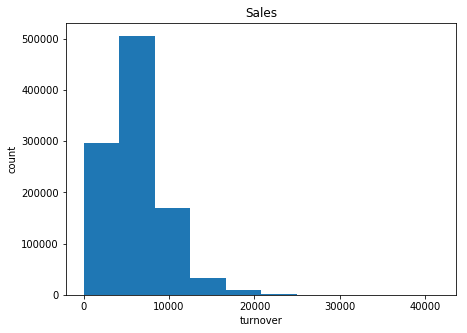

In [46]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Sales)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Sales")

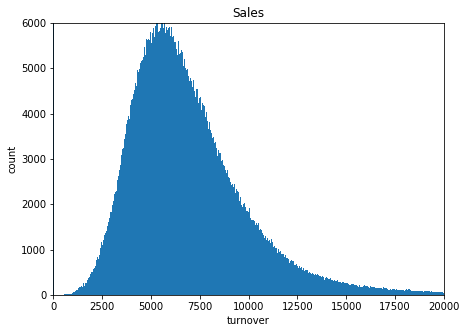

In [47]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Sales, bins=1000)
plt.xlim(0,20000)
plt.ylim(0,6000)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Sales")

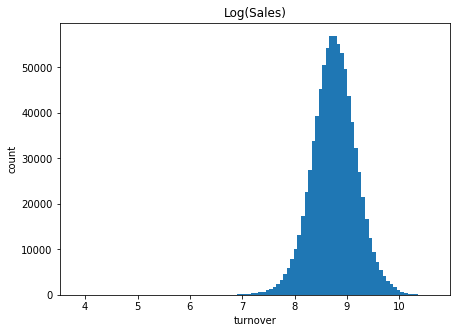

In [48]:
plt.figure(figsize=(7,5))
plt.hist(np.log1p(train_store_df[train_store_df.Sales != 0].Sales), bins= 100)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Log(Sales)")

Sales is positive skewed distribution。

#### Date

In [49]:
train_store_df.Date.describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

In [50]:
train_store_df.Date.unique()

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000', '2015-07-18T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000', '2015-07-12T00:00:00.000000000',
       '2015-07-11T00:00:00.000000000', '2015-07-10T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-07-08T00:00:00.000000000',
       '2015-07-07T00:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-05T00:00:00.000000000', '2015-07-04

In [51]:
test_store_df.Date.describe()

count                   41088
unique                     48
top       2015-09-15 00:00:00
freq                      856
first     2015-08-01 00:00:00
last      2015-09-17 00:00:00
Name: Date, dtype: object

In [52]:
test_store_df.Date.unique()

array(['2015-09-17T00:00:00.000000000', '2015-09-16T00:00:00.000000000',
       '2015-09-15T00:00:00.000000000', '2015-09-14T00:00:00.000000000',
       '2015-09-13T00:00:00.000000000', '2015-09-12T00:00:00.000000000',
       '2015-09-11T00:00:00.000000000', '2015-09-10T00:00:00.000000000',
       '2015-09-09T00:00:00.000000000', '2015-09-08T00:00:00.000000000',
       '2015-09-07T00:00:00.000000000', '2015-09-06T00:00:00.000000000',
       '2015-09-05T00:00:00.000000000', '2015-09-04T00:00:00.000000000',
       '2015-09-03T00:00:00.000000000', '2015-09-02T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-08-30T00:00:00.000000000', '2015-08-29T00:00:00.000000000',
       '2015-08-28T00:00:00.000000000', '2015-08-27T00:00:00.000000000',
       '2015-08-26T00:00:00.000000000', '2015-08-25T00:00:00.000000000',
       '2015-08-24T00:00:00.000000000', '2015-08-23T00:00:00.000000000',
       '2015-08-22T00:00:00.000000000', '2015-08-21

The Date in train data is from 2013-01-01 to 2015-07-31, while the date in test data is from 2015-08-01 to 2015-09-17.

#### Customers

In [53]:
train_store_df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

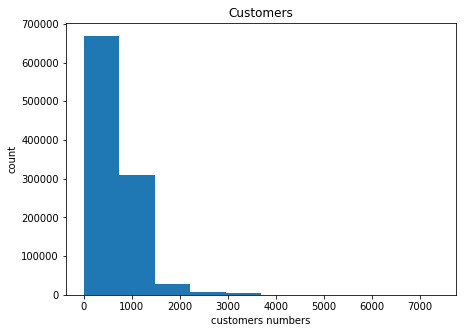

In [54]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Customers)
plt.xlabel("customers numbers")
plt.ylabel("count")
plt.title("Customers")

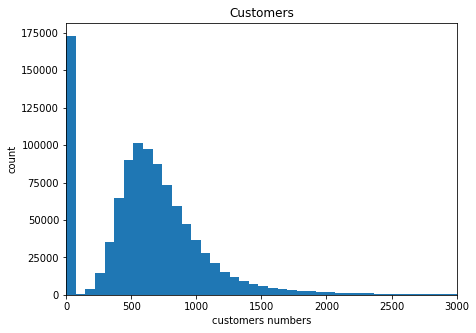

In [55]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Customers, bins=100)
plt.xlim(0,3000)
plt.xlabel("customers numbers")
plt.ylabel("count")
plt.title("Customers")

Customers has a lot of zero values and is positive skewed distribution.

#### CompetitionDistance

In [56]:
train_store_df.CompetitionDistance.describe()

count    1.017209e+06
mean     5.415982e+03
std      7.710253e+03
min      0.000000e+00
25%      7.000000e+02
50%      2.320000e+03
75%      6.880000e+03
max      7.586000e+04
Name: CompetitionDistance, dtype: float64

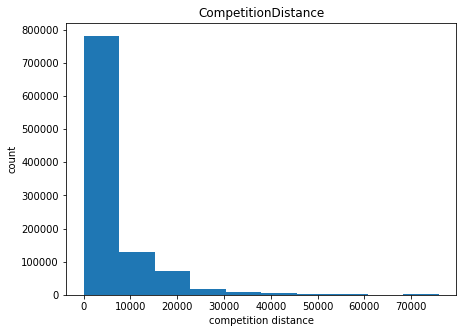

In [57]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.CompetitionDistance)
plt.xlabel("competition distance")
plt.ylabel("count")
plt.title("CompetitionDistance")

CompetitionDistance is positive skewed distribution.

#### CompetitionOpenSinceMonth

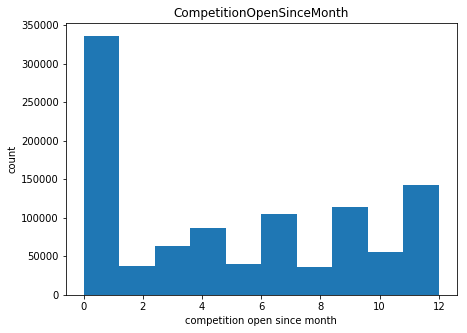

In [58]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.CompetitionOpenSinceMonth)
plt.xlabel("competition open since month")
plt.ylabel("count")
plt.title("CompetitionOpenSinceMonth")

In [59]:
train_store_df.CompetitionOpenSinceMonth.value_counts()

0.0     323348
9.0     114254
4.0      87076
11.0     84455
3.0      63548
7.0      59434
12.0     57896
10.0     55622
6.0      45444
5.0      39608
2.0      37886
8.0      36186
1.0      12452
Name: CompetitionOpenSinceMonth, dtype: int64

The zero value accounts for the majority.

#### CompetitionOpenSinceYear

In [60]:
train_store_df.CompetitionOpenSinceYear.unique()

array([ 2008.,  2007.,  2006.,  2009.,  2015.,  2013.,  2014.,  2000.,
        2011.,     0.,  2010.,  2005.,  1999.,  2003.,  2012.,  2004.,
        2002.,  1961.,  1995.,  2001.,  1990.,  1994.,  1900.,  1998.])

In [61]:
train_store_df.CompetitionOpenSinceYear.value_counts()

0.0       323348
2013.0     75426
2012.0     74299
2014.0     63732
2005.0     56564
2010.0     51258
2011.0     49396
2009.0     49396
2008.0     48476
2007.0     43744
2006.0     42802
2015.0     35060
2002.0     24882
2004.0     19804
2003.0     16794
2001.0     14704
2000.0      9236
1999.0      7352
1990.0      4710
1994.0      1884
1995.0      1700
1998.0       942
1961.0       942
1900.0       758
Name: CompetitionOpenSinceYear, dtype: int64

The zero value accounts for the majority.

#### Promo2SinceWeek

In [62]:
train_store_df.Promo2SinceWeek.unique()

array([  0.,  13.,  14.,   1.,  45.,  40.,  26.,  22.,   5.,   6.,  10.,
        31.,  37.,   9.,  39.,  27.,  18.,  35.,  23.,  48.,  36.,  50.,
        44.,  49.,  28.])

In [63]:
train_store_df.Promo2SinceWeek.value_counts()

0.0     508031
14.0     72990
40.0     62598
31.0     39976
10.0     38828
5.0      35818
37.0     32786
1.0      32418
13.0     29820
45.0     29268
22.0     28694
18.0     27318
35.0     22814
9.0      12452
27.0      9626
36.0      9236
48.0      8294
39.0      4732
23.0      4342
44.0      2642
28.0       942
50.0       942
6.0        942
26.0       942
49.0       758
Name: Promo2SinceWeek, dtype: int64

The zero value accounts for the majority.

#### Promo2SinceYear

In [64]:
train_store_df.Promo2SinceYear.unique()

array([    0.,  2010.,  2011.,  2012.,  2009.,  2014.,  2015.,  2013.])

In [65]:
train_store_df.Promo2SinceYear.value_counts()

0.0       508031
2011.0    115056
2013.0    110464
2014.0     79922
2012.0     73174
2009.0     65270
2010.0     56240
2015.0      9052
Name: Promo2SinceYear, dtype: int64

The zero value accounts for the majority.

#### PromoInterval

In [66]:
train_store_df.PromoInterval.unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype=object)

In [67]:
train_store_df.PromoInterval.value_counts()

0                   508031
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

The zero value accounts for the majority. Jan,Apr,Jul,Oct follows the following.

### Construct some new variables

#### Construct new variables `Year`, `Month`, `Day` and `WeekOfYear`  based on `Date` .

In [68]:
#train_store_df
train_store_df['Year'] = train_store_df.Date.dt.year
train_store_df['Month'] = train_store_df.Date.dt.month
train_store_df['Day'] = train_store_df.Date.dt.day
train_store_df['WeekOfYear'] = train_store_df.Date.dt.weekofyear

In [69]:
#test_store_df
test_store_df['Year'] = test_store_df.Date.dt.year
test_store_df['Month'] = test_store_df.Date.dt.month
test_store_df['Day'] = test_store_df.Date.dt.day
test_store_df['WeekOfYear'] = test_store_df.Date.dt.weekofyear

CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code

#### Construct new variables `CompetitionOpen`

In [70]:
#train_store_df
train_store_df['CompetitionOpen'] = 12*(train_store_df.Year - train_store_df.CompetitionOpenSinceYear) + \
                                   (train_store_df.Month - train_store_df.CompetitionOpenSinceMonth)
#test_store_df
test_store_df['CompetitionOpen'] = 12*(test_store_df.Year - test_store_df.CompetitionOpenSinceYear) + \
                                   (test_store_df.Month - test_store_df.CompetitionOpenSinceMonth)

#### Construct new variables `PromoOpen` 

In [71]:
#train_store_df
train_store_df['PromoOpen'] = 12*(train_store_df.Year - train_store_df.Promo2SinceYear) + \
                                 (train_store_df.WeekOfYear - train_store_df.Promo2SinceWeek) / 4.0

train_store_df['PromoOpen'] = train_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
train_store_df.loc[train_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

#test_store_df
test_store_df['PromoOpen'] = 12*(test_store_df.Year - test_store_df.Promo2SinceYear) + \
                                (test_store_df.WeekOfYear - test_store_df.Promo2SinceWeek) / 4.0

test_store_df['PromoOpen'] = test_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
test_store_df.loc[test_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

### Bivariate Analysis

#### Sales & Open

In [72]:
train_store_df[train_store_df.Open == 0].Sales.sum()

0

In [73]:
train_store_df[(train_store_df.Open == 1) & (train_store_df.Sales == 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen
22589,25,4,2014-02-13,0,0,1,0,0,0,c,...,0,0.0,0.0,0,2014,2,13,7,130.0,0.00
22590,25,3,2014-02-12,0,0,1,0,0,0,c,...,0,0.0,0.0,0,2014,2,12,7,130.0,0.00
25212,28,4,2014-09-04,0,0,1,1,0,0,a,...,1,6.0,2015.0,"Mar,Jun,Sept,Dec",2014,9,4,36,-1.0,0.00
25213,28,3,2014-09-03,0,0,1,1,0,1,a,...,1,6.0,2015.0,"Mar,Jun,Sept,Dec",2014,9,3,36,-1.0,0.00
25214,28,2,2014-09-02,0,0,1,1,0,1,a,...,1,6.0,2015.0,"Mar,Jun,Sept,Dec",2014,9,2,36,-1.0,0.00
51491,57,2,2014-07-01,0,0,1,1,0,0,d,...,0,0.0,0.0,0,2014,7,1,27,1.0,0.00
92570,102,4,2014-07-24,0,0,1,0,0,1,a,...,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2014,7,24,30,79.0,5.00
92582,102,6,2014-07-12,0,0,1,0,0,0,a,...,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2014,7,12,28,79.0,4.50
205303,227,4,2014-09-11,0,0,1,0,0,0,a,...,0,0.0,0.0,0,2014,9,11,37,24177.0,0.00
210424,232,4,2013-01-24,0,0,1,1,0,0,c,...,1,10.0,2013.0,"Mar,Jun,Sept,Dec",2013,1,24,4,32.0,0.00


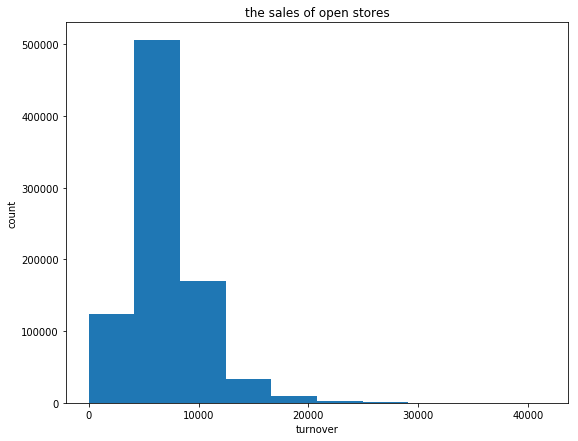

In [74]:
plt.figure(figsize=(9,7))
plt.hist(train_store_df[train_store_df.Open == 1].Sales)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("the sales of open stores")

There are some opened stores which have zero sales.

#### Analysis of sales!=0 and open != 0

In [75]:
train_store_sales_df = train_store_df[(train_store_df.Sales != 0) & (train_store_df.Open != 0)]

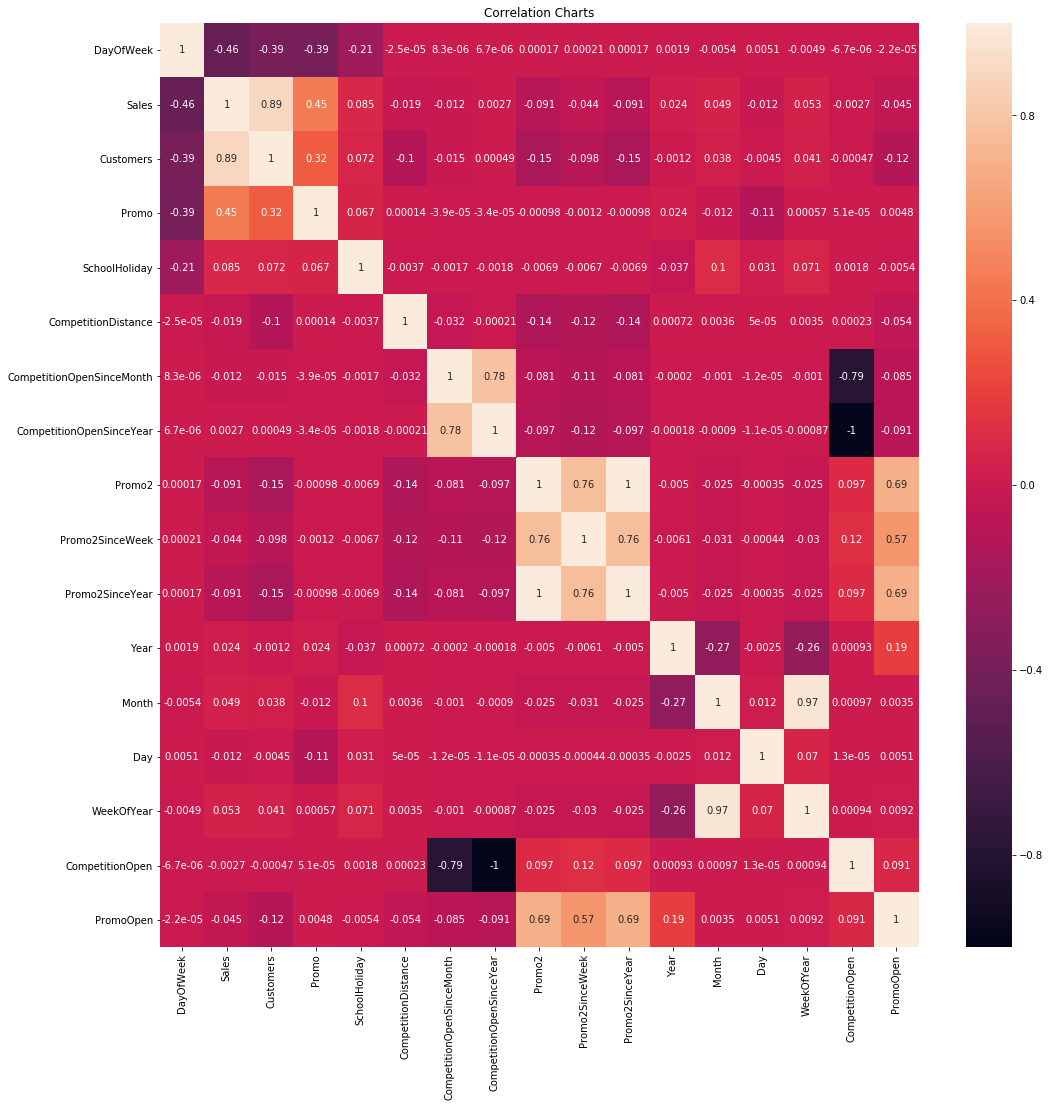

In [76]:
plt.figure(figsize=(17,17))
corr_mat = train_store_df.drop(['Store','Open'], axis=1).corr()
sns.heatmap(corr_mat,annot=True)
plt.title('Correlation Charts')

####  Sales & DayOfWeek

In [77]:
train_store_sales_df.groupby('DayOfWeek').Sales.mean()

DayOfWeek
1    8216.252259
2    7088.409086
3    6728.786679
4    6768.214973
5    7073.034133
6    5875.084935
7    8224.723908
Name: Sales, dtype: float64

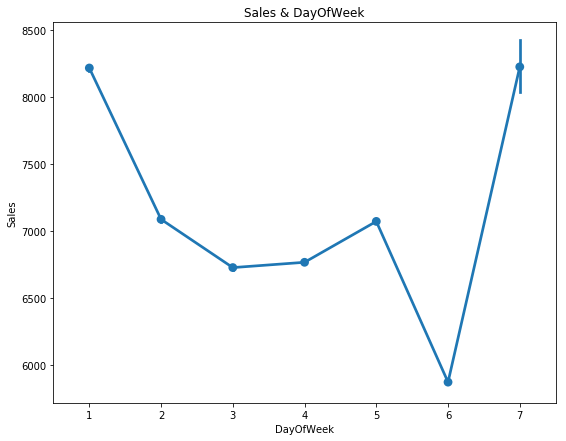

In [78]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['DayOfWeek'], train_store_sales_df['Sales'])
plt.title("Sales & DayOfWeek")

Sales on Saturday are the lowest.

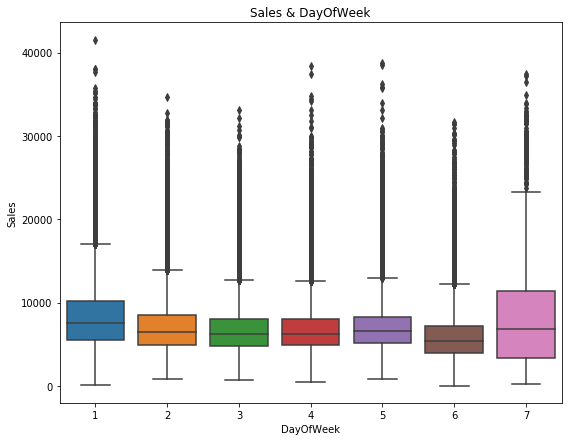

In [79]:
plt.figure(figsize=(9,7))
sns.boxplot(train_store_sales_df['DayOfWeek'], train_store_sales_df['Sales'])
plt.title("Sales & DayOfWeek")

There seems to be some abnormal points. The daily sales are almost the same.

####  Sales & WeekOfYear

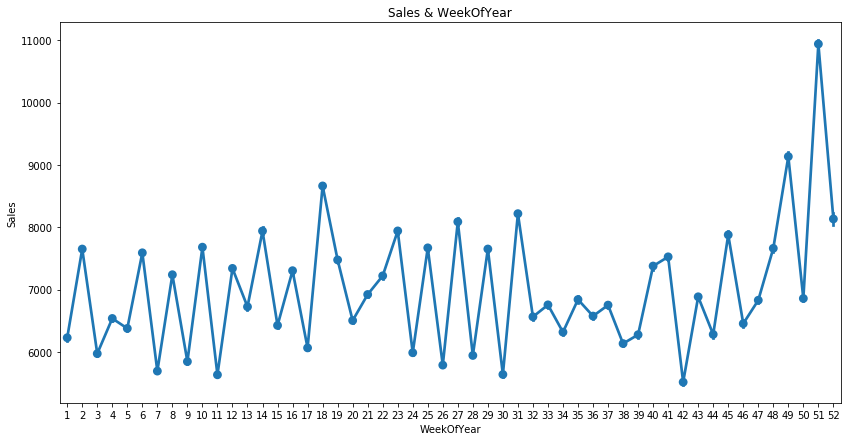

In [80]:
plt.figure(figsize=(14,7))
sns.pointplot(train_store_sales_df['WeekOfYear'], train_store_sales_df['Sales'])
plt.title("Sales & WeekOfYear")

#### Sales & Year

In [81]:
train_store_sales_df.groupby('Year').Sales.sum()

Year
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64

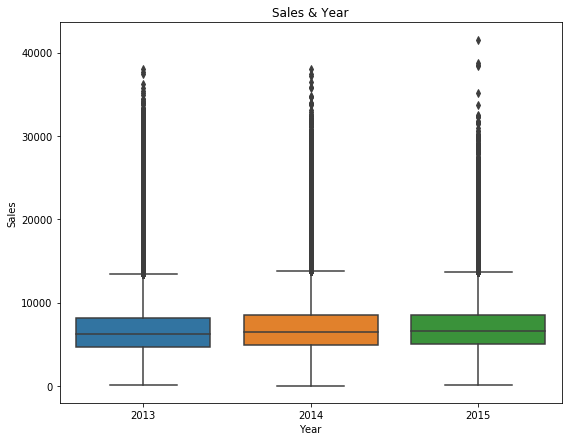

In [82]:
plt.figure(figsize=(9,7))
sns.boxplot(train_store_sales_df['Year'], train_store_sales_df['Sales'])
plt.title("Sales & Year")

The three years sales are almost the same.

#### Sales & Month

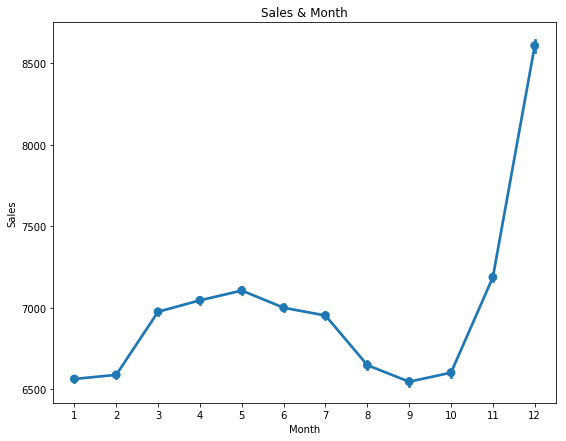

In [83]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['Month'], train_store_sales_df['Sales'])
plt.title("Sales & Month")

The December sales is the largest.

#### Sales & Day

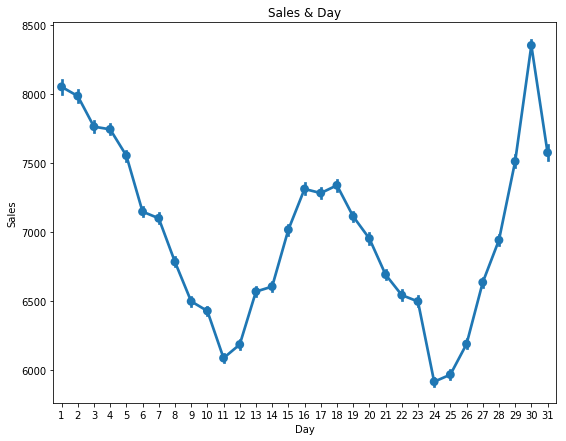

In [84]:
plt.figure(figsize=(9,7))
sns.pointplot(train_store_sales_df['Day'], train_store_sales_df['Sales'])
plt.title("Sales & Day")

we see that sales are the most at the beginning of the month, the monthly, and the end of the month.
There is a strong rule between the two variables.

#### Sales & Customers

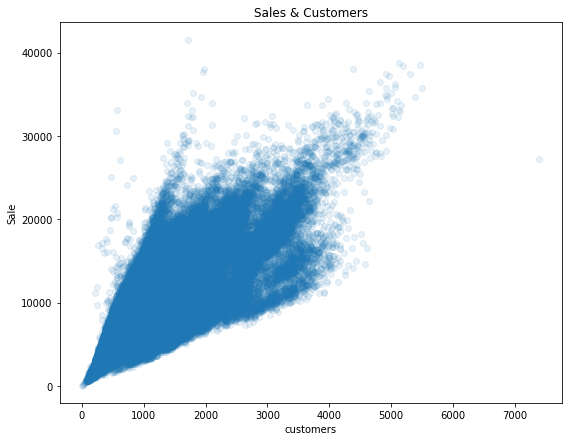

In [85]:
plt.figure(figsize=(9,7))
plt.scatter(data=train_store_sales_df, x='Customers', y='Sales', alpha=0.1)
plt.xlabel('customers')
plt.ylabel('Sale')
plt.title("Sales & Customers")

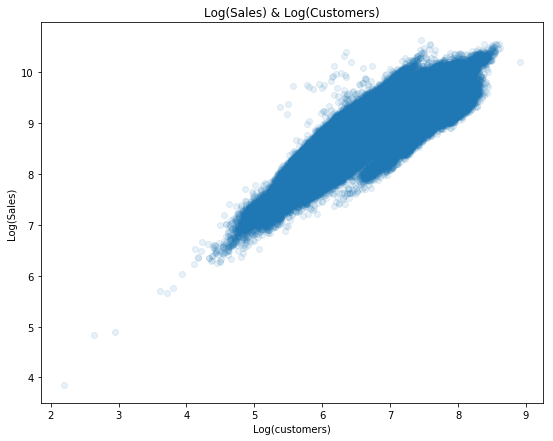

In [86]:
plt.figure(figsize=(9,7))
plt.scatter(np.log1p(train_store_sales_df.Customers), np.log1p(train_store_sales_df.Sales), alpha=0.1)
plt.xlabel('Log(customers)')
plt.ylabel('Log(Sales)')
plt.title("Log(Sales) & Log(Customers)")

There is a strong positive correlation between sales and customer.

#### Sales & Promo

In [87]:
train_store_sales_df.groupby('Promo').Sales.mean()

Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64

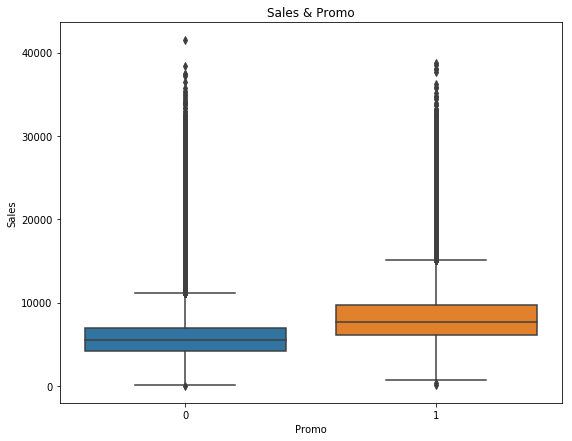

In [88]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo', y='Sales')
plt.title("Sales & Promo")

We can know that promotion is benifit to improve sales.

#### Sales & StateHoliday

In [89]:
train_store_sales_df.StateHoliday = train_store_sales_df.StateHoliday.astype('str')
train_store_sales_df[train_store_sales_df.StateHoliday == '0'].StateHoliday = train_store_sales_df[train_store_sales_df.StateHoliday == '0'].StateHoliday.astype('int')

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [90]:
train_store_sales_df.groupby('StateHoliday').Sales.mean()

StateHoliday
0    6953.960229
a    8487.471182
b    9887.889655
c    9743.746479
Name: Sales, dtype: float64

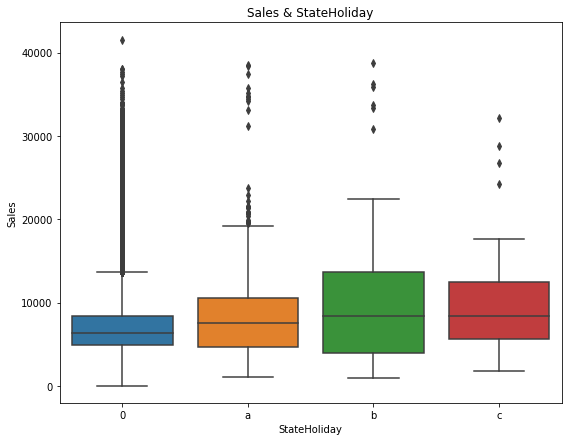

In [91]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='StateHoliday', y='Sales')
plt.title("Sales & StateHoliday")

#### Sales & SchoolHoliday

In [92]:
train_store_sales_df.groupby('SchoolHoliday').Sales.mean()

SchoolHoliday
0    6897.207830
1    7200.710282
Name: Sales, dtype: float64

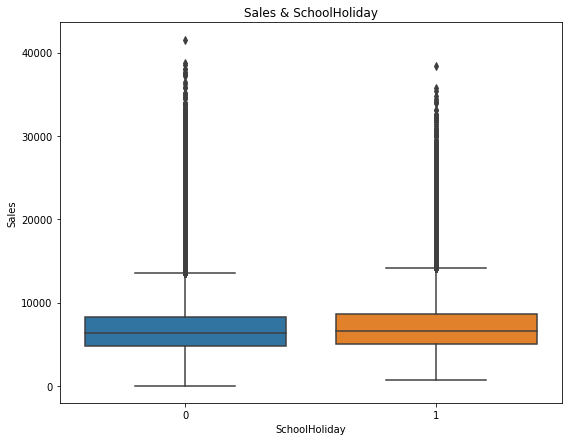

In [93]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='SchoolHoliday', y='Sales')
plt.title("Sales & SchoolHoliday")

#### Sales & StoreType

In [94]:
train_store_sales_df.groupby('StoreType').Sales.mean()

StoreType
a     6925.697986
b    10233.380141
c     6933.126425
d     6822.300064
Name: Sales, dtype: float64

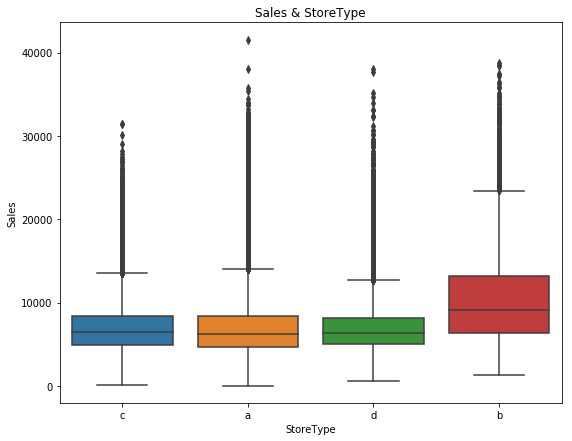

In [95]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='StoreType', y='Sales')
plt.title("Sales & StoreType")

Store sales of 'b' type are the most.

#### Sales & Assortment

In [96]:
train_store_sales_df.groupby('Assortment').Sales.mean()

Assortment
a    6621.523057
b    8642.503594
c    7300.843547
Name: Sales, dtype: float64

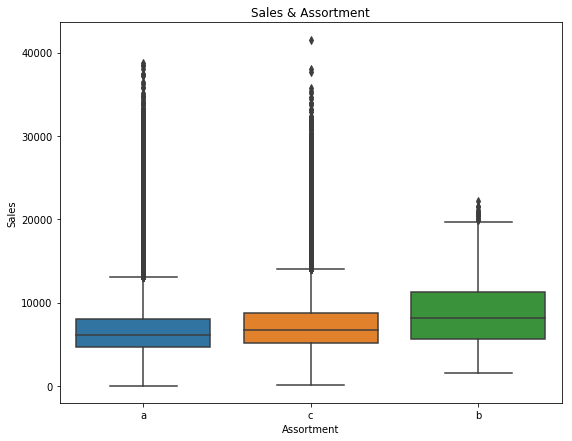

In [97]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Assortment', y='Sales')
plt.title("Sales & Assortment")

Store sales of  'b' assortment are the most.

#### Sales & CompetitionDistance

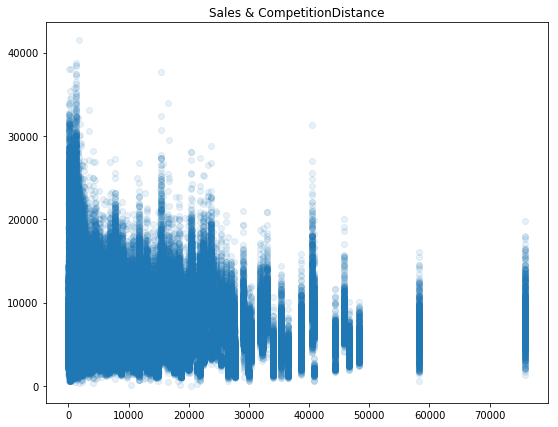

In [98]:
plt.figure(figsize=(9,7))
plt.scatter(data=train_store_sales_df, x='CompetitionDistance', y='Sales', alpha=0.1)
plt.title("Sales & CompetitionDistance")

There is no correlation between sales and CompetitionDistance.

#### Sales & CompetitionOpen

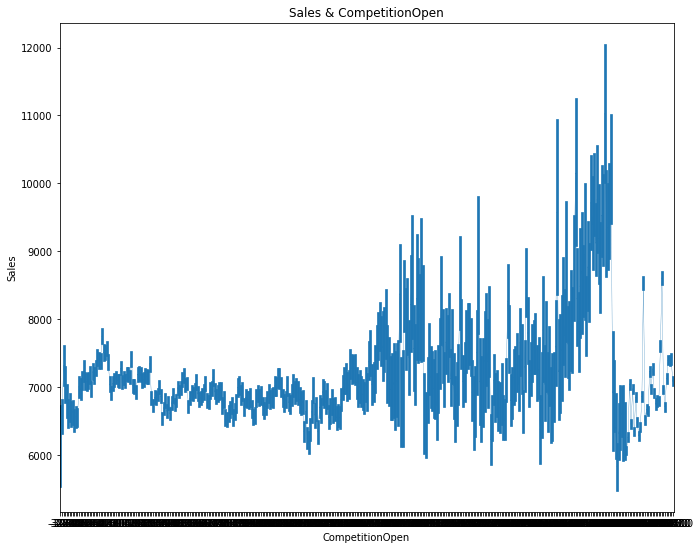

In [99]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='CompetitionOpen', y='Sales',scale=0.1)
plt.title("Sales & CompetitionOpen")

There is a weak rule between sales and CompetitionOpen.

#### Sales & Promo2

In [100]:
train_store_sales_df.groupby('Promo2').Sales.sum()

Promo2
0    3111542628
1    2761637995
Name: Sales, dtype: int64

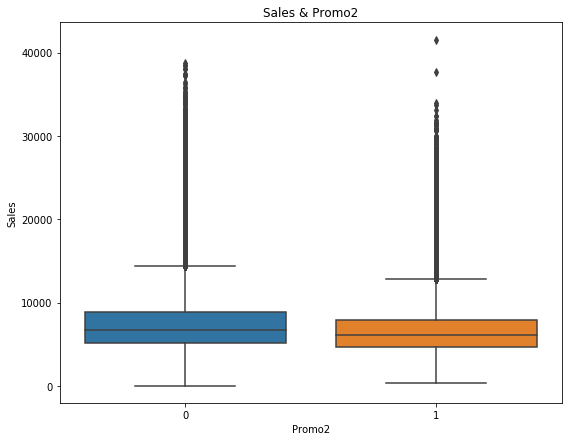

In [101]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo2', y='Sales')
plt.title("Sales & Promo2")

The stores with promos tend to make lower sales. This does not necessary mean that the promos don’t help or are counterproductive. They are possibly measures that are taken mainly by stores with low sales in the first place.

#### Sales & PromoOpen

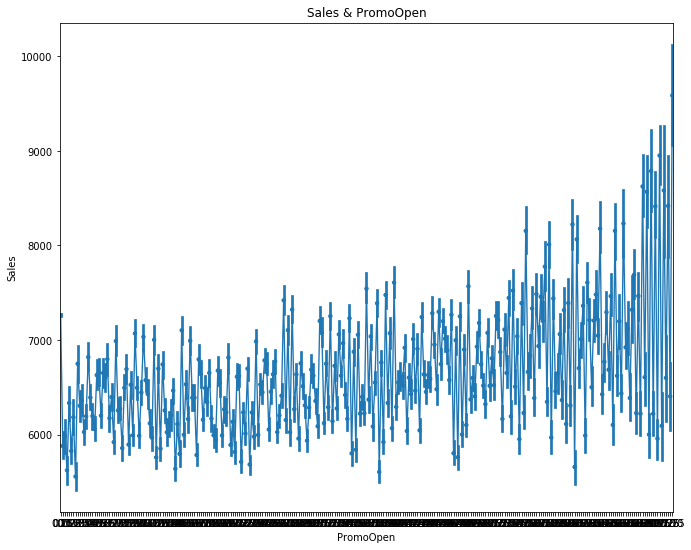

In [102]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='PromoOpen', y='Sales',scale=0.5)
plt.title("Sales & PromoOpen")

It seems that the longer the time is, the bigger the sales are.

There is no correlation between sales and Promo2SinceYear.

#### Sales & PromoInterval

In [103]:
train_store_sales_df.groupby('PromoInterval').Sales.mean()

PromoInterval
0                   7350.818414
Feb,May,Aug,Nov     6427.367069
Jan,Apr,Jul,Oct     6726.367401
Mar,Jun,Sept,Dec    6215.888185
Name: Sales, dtype: float64

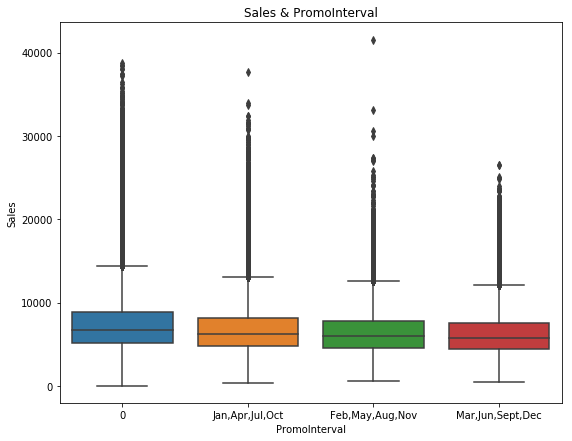

In [104]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='PromoInterval', y='Sales')
plt.title("Sales & PromoInterval")

There is no correlation between sales and PromoInterval.

#### Brief Summary

From above bivariate analysis, we can see that there is a strong positive correlation between sales and customer.
There is a certain relationship between variables Sales and  Day, DayofWeek, WeekofYear, CompetitionOpen, PromoOpen.

### Multivariate Analysis

#### Sales & DayOfWeek & StoreType & Promo 

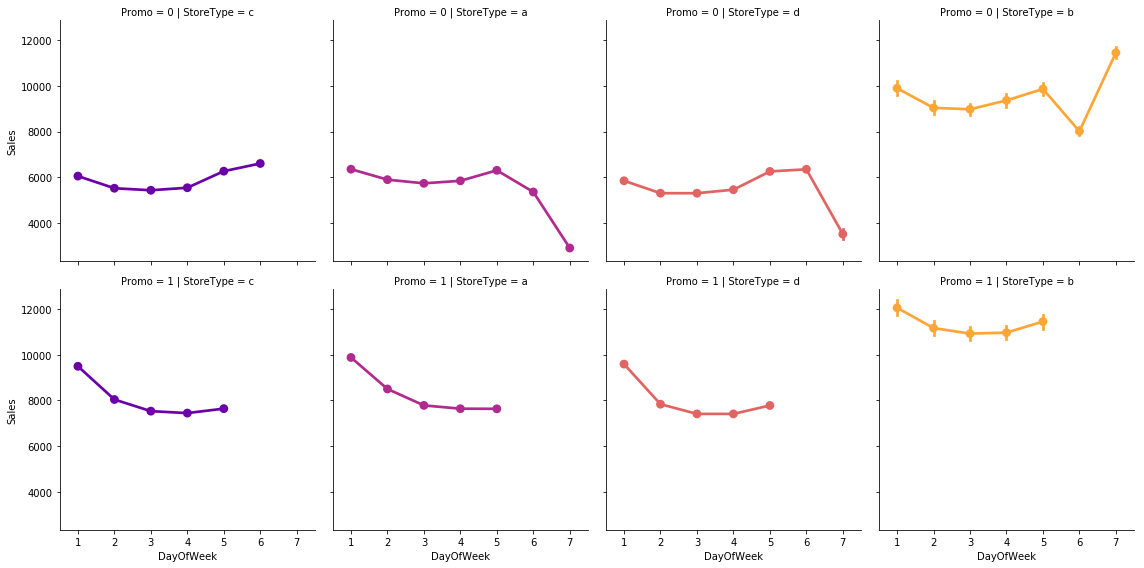

In [105]:
sns.factorplot(data = train_store_sales_df, x = 'DayOfWeek', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

We can see that stores are never promoted at the weekend.

#### Sales & WeekOfYear & StoreType & Promo 

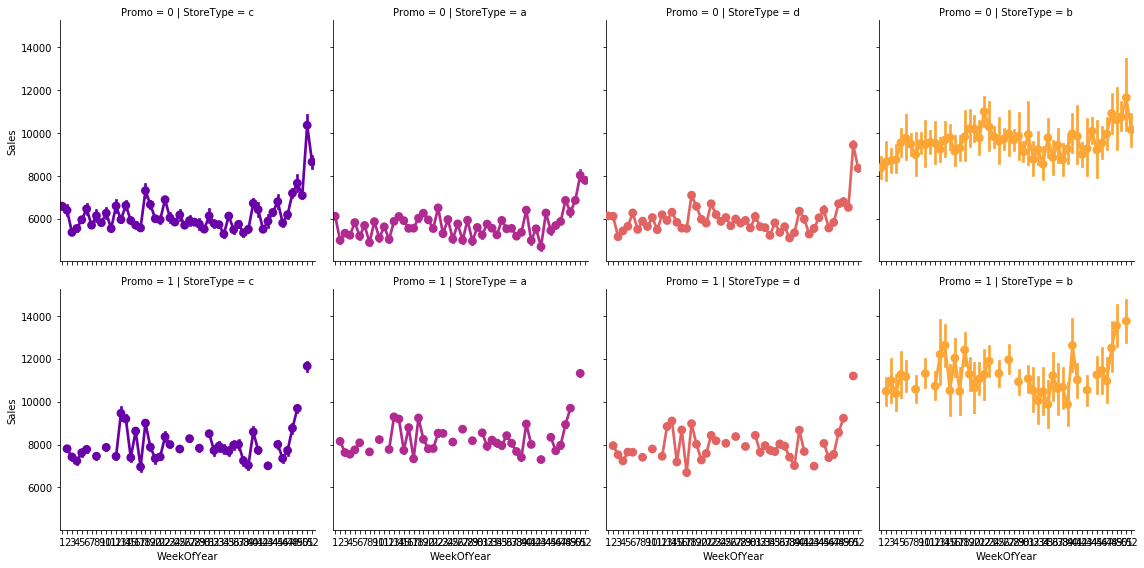

In [106]:
sns.factorplot(data = train_store_sales_df, x = 'WeekOfYear', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

#### Sales & Month & StoreType & Promo 

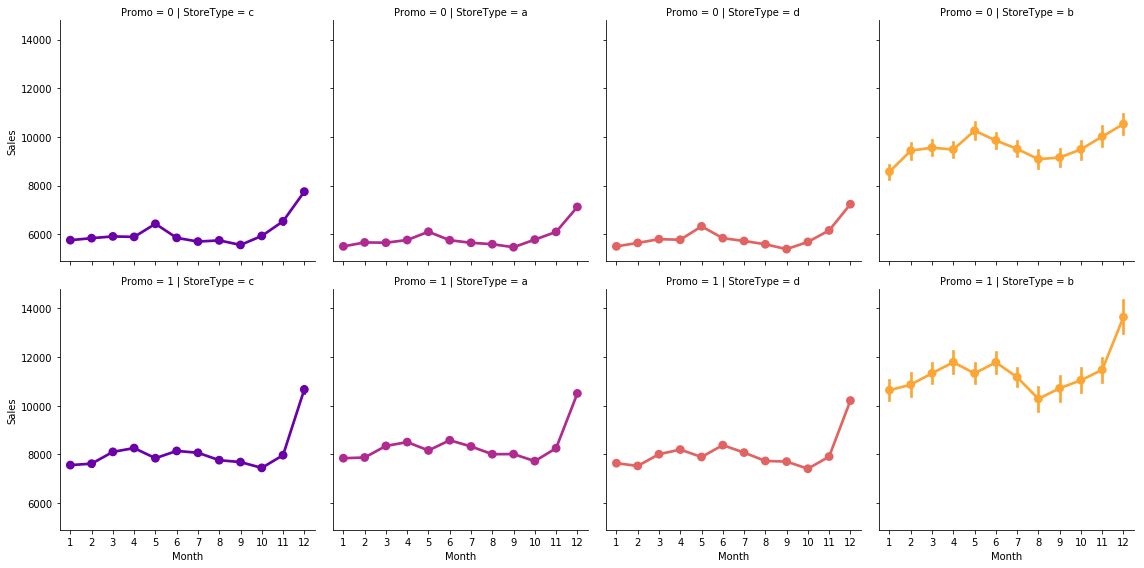

In [107]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

Sales promotion can improve sales to a certain extent. There is a distinct increase in sales in the fourth quarter.

#### Sales & Month & Assortment	 & StoreType

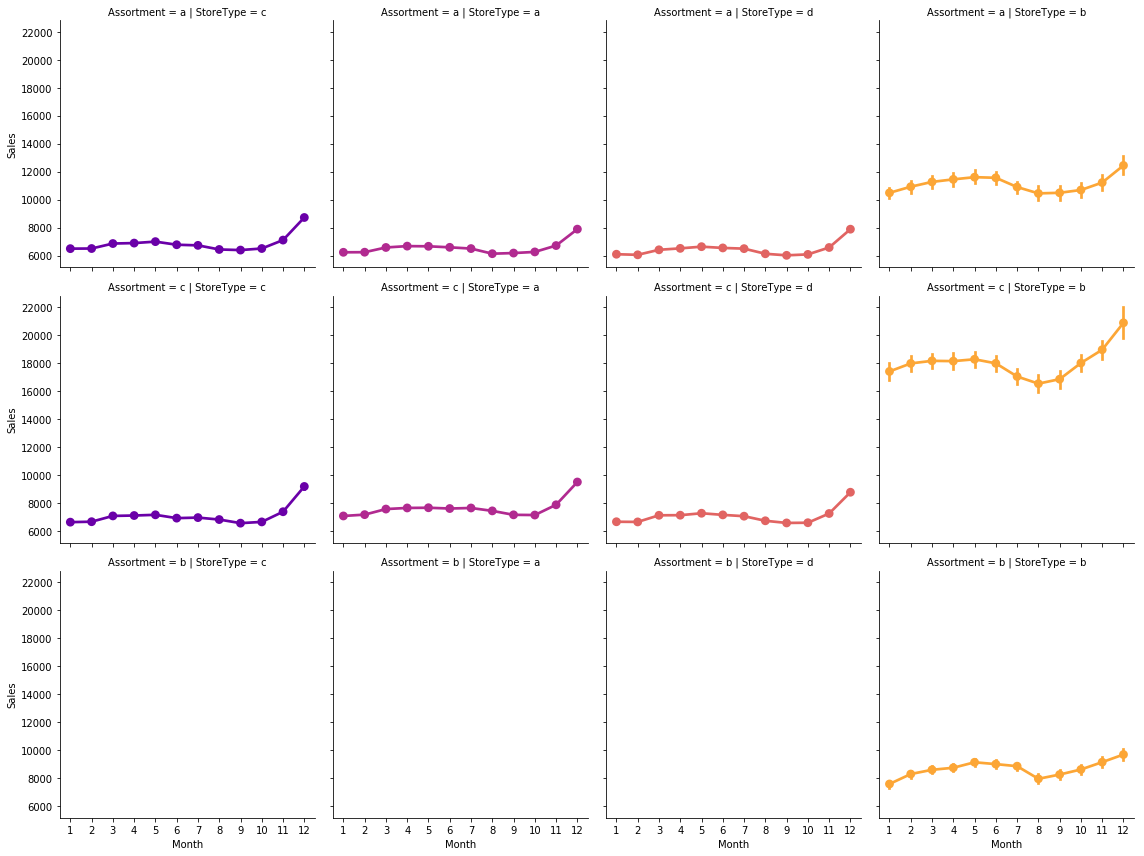

In [108]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Assortment')

Only 'b' type stores have 'b' assortment level.

#### Sales & Day & StoreType & Promo 

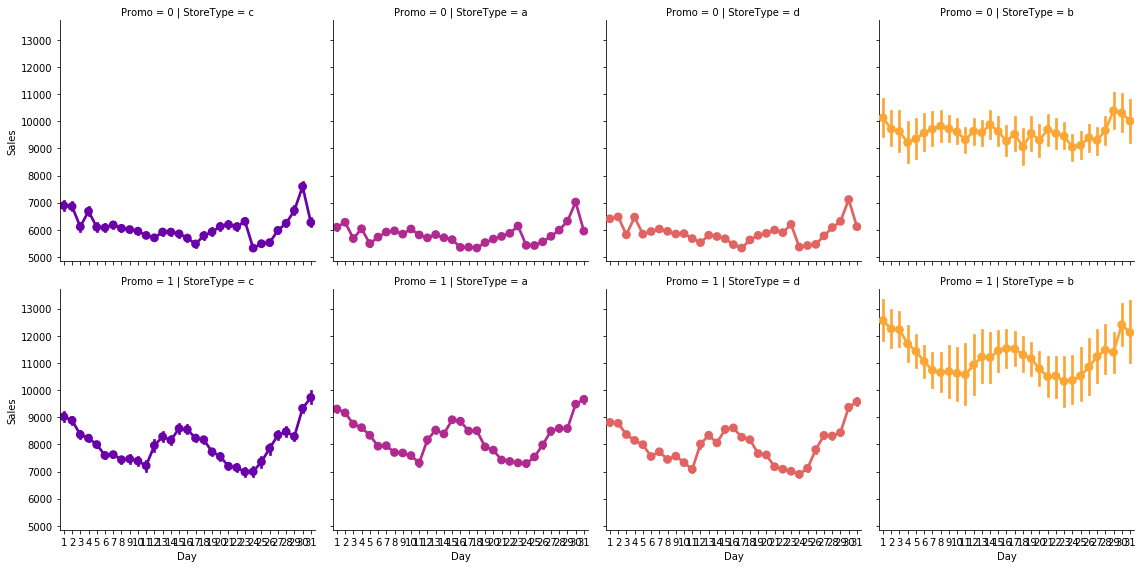

In [109]:
sns.factorplot(data = train_store_sales_df, x = 'Day', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

All types of stores have a similar trend, and sales are the most at the beginning of the month, the monthly, and the end of the month.

#### Sales & Month & DayOfWeek & StoreType

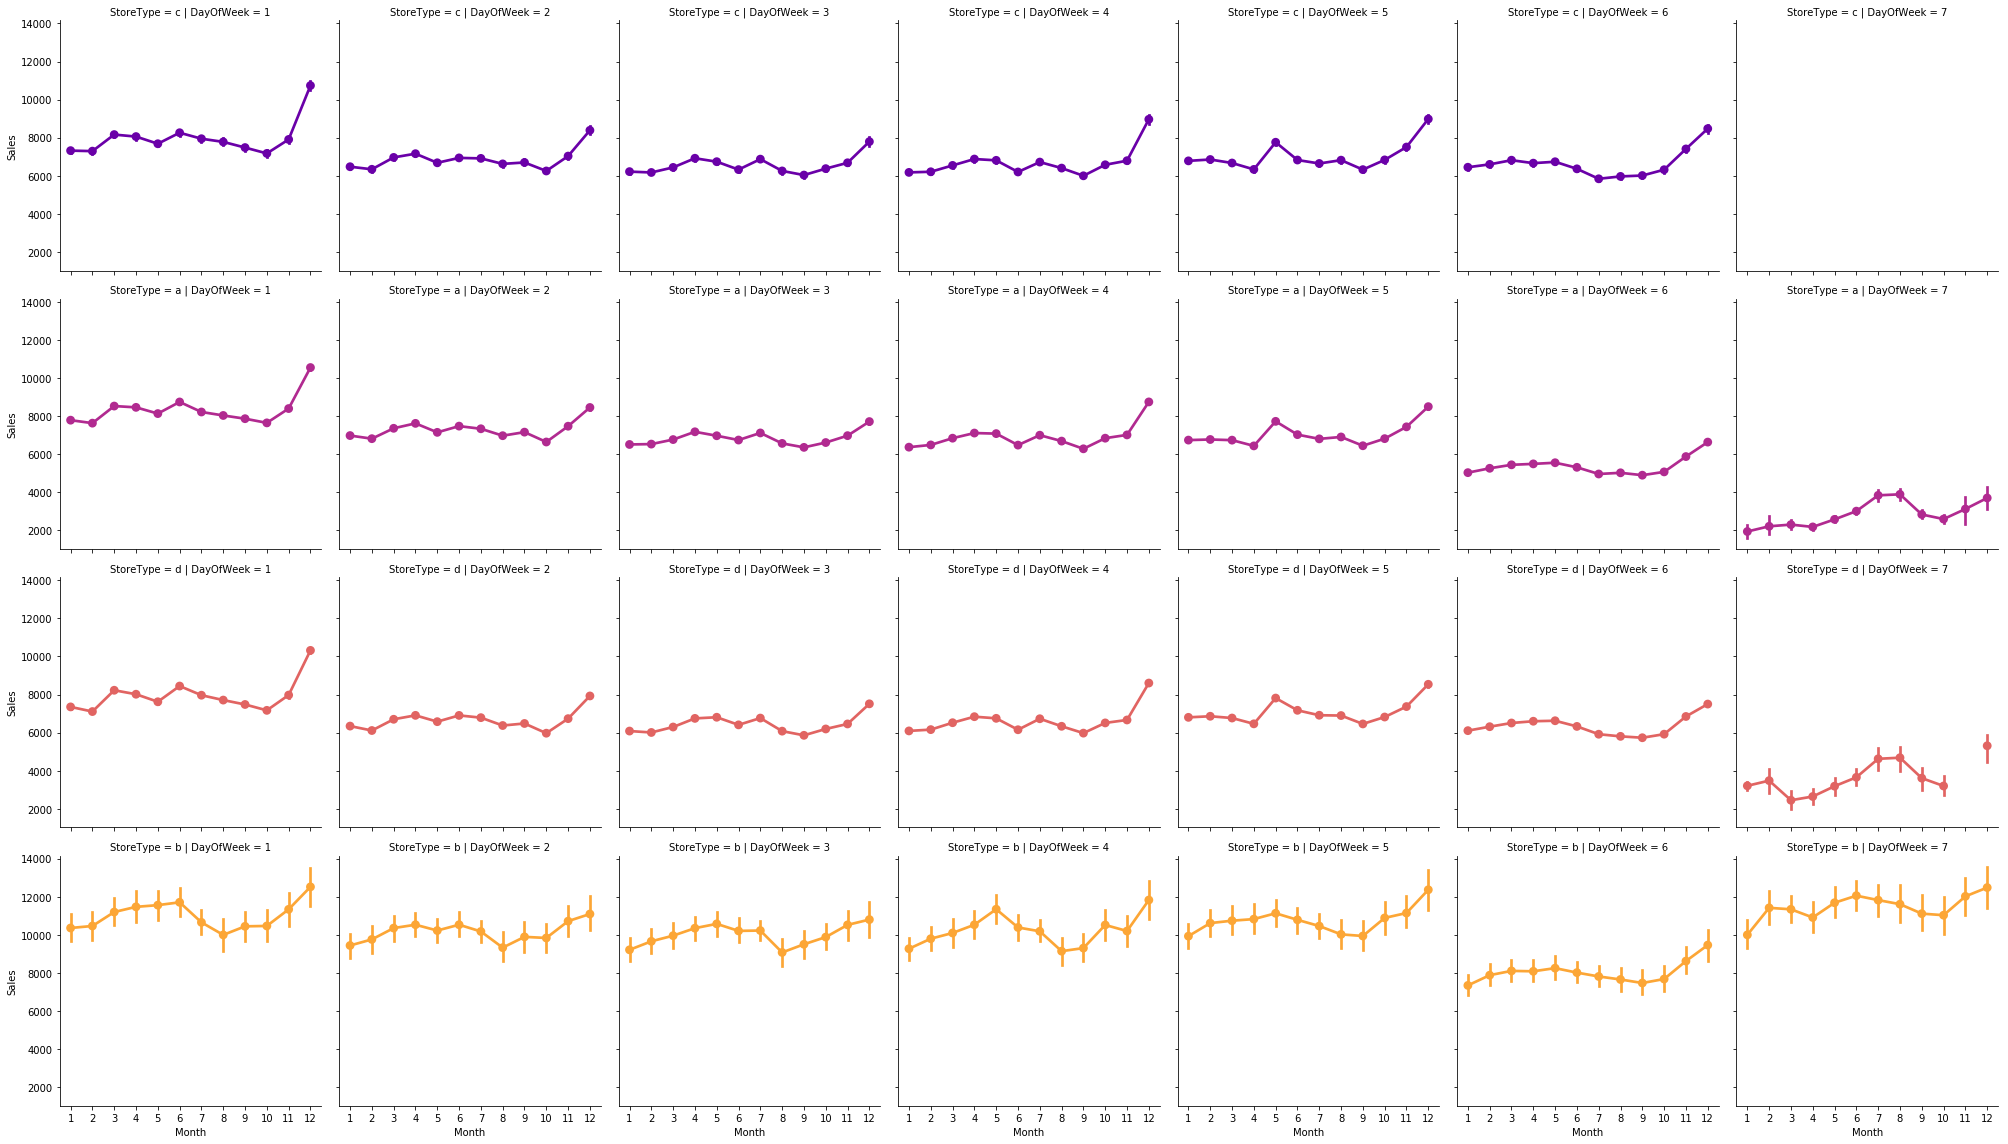

In [110]:
sns.factorplot(data = train_store_sales_df, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType') 

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

#### Sales & StateHoliday & Promo & StoreType

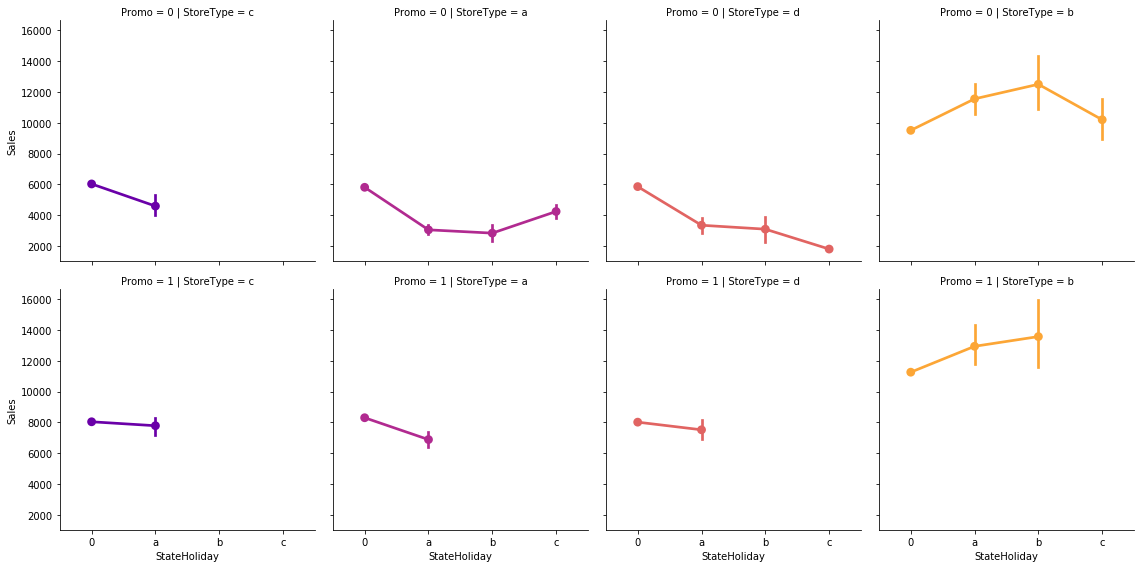

In [111]:
sns.factorplot(data = train_store_sales_df, x = 'StateHoliday', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

Only B type stores will be promoted on Easter, and there is no promotion on Christmas.

#### Sales & SchoolHoliday & Promo & StoreType

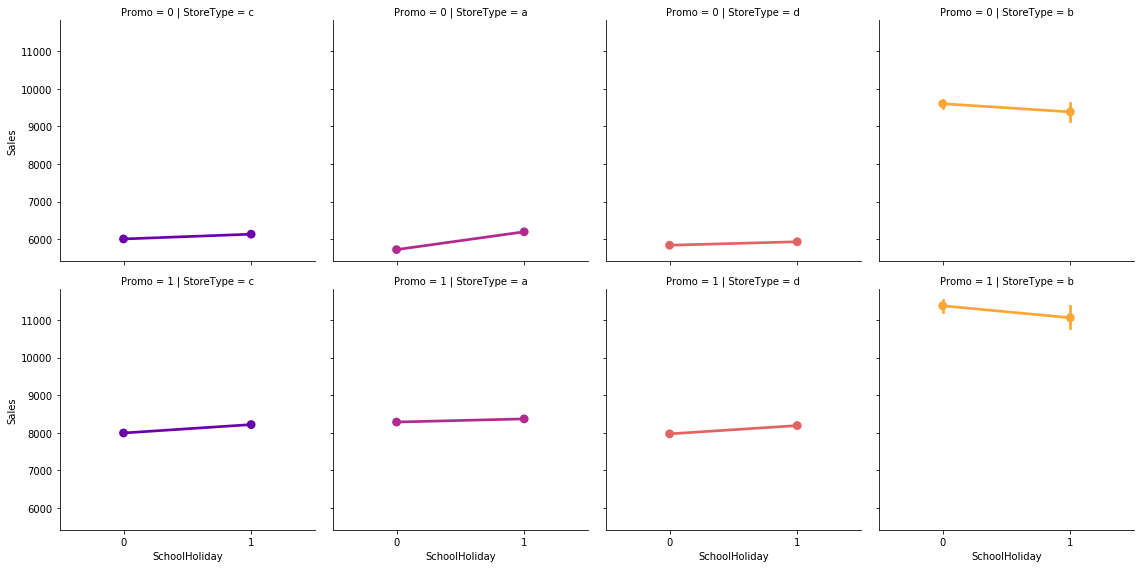

In [112]:
sns.factorplot(data = train_store_sales_df, x = 'SchoolHoliday', y = "Sales", 
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

## Feature Engineering

In [113]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 24 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              101720

In [114]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 23 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
Year            

#### Encoding

In [115]:
#train
mappings = {'0':0,'a':1, 'b':2, 'c':3, 'd':4}
train_store_df.StateHoliday.replace(mappings, inplace=True)
train_store_df.StoreType.replace(mappings, inplace=True)
train_store_df.Assortment.replace(mappings, inplace=True)

#test
test_store_df.StateHoliday.replace(mappings, inplace=True)
test_store_df.StoreType.replace(mappings, inplace=True)
test_store_df.Assortment.replace(mappings, inplace=True)

In [116]:
mappings = {'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3}
train_store_df.PromoInterval.replace(mappings, inplace=True)
test_store_df.PromoInterval.replace(mappings, inplace=True)

#### Choice X,y for training

In [117]:
#Choice the Date within 2015/7/18-2015/7/31 for valid data.
Xy_valid_df = train_store_df[train_store_df.Date > '7/17/2015']
Xy_train_df = train_store_df[train_store_df.Date <= '7/17/2015']

# Consider only open stores which Sales bigger then zero for training.
train_drop_features = ['Customers', 'Sales','Date']
#train data
X_train = Xy_train_df[(Xy_train_df.Open != 0 ) & (Xy_train_df.Sales != 0)].drop(train_drop_features, axis=1)
y_train = Xy_train_df[(Xy_train_df.Open != 0 ) & (Xy_train_df.Sales != 0)].Sales
y_train = np.log1p(y_train)

#valid data
X_valid = Xy_valid_df[(Xy_valid_df.Open != 0 ) & (Xy_valid_df.Sales != 0)].drop(train_drop_features, axis=1)
y_valid = Xy_valid_df[(Xy_valid_df.Open != 0 ) & (Xy_valid_df.Sales != 0)].Sales
y_valid = np.log1p(y_valid)

In [118]:
test_drop_features = ['Id','Date']
X_test = test_store_df.drop(test_drop_features, axis=1)

## Model

In [119]:
"""
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe
"""
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

#xgboost
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

#lightgbm
def rmspe_lgb(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat), False

#sklearn interface
def rmspe_gscv(y, yhat):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    return rmspe(y, yhat)

rmspe_score = make_scorer(rmspe_gscv)
kfold = KFold(n_splits=5, random_state=23)

### xgboost

In [120]:
xgbtrain = xgb.DMatrix(X_train, label=y_train)
xgbvalid = xgb.DMatrix(X_valid, label=y_valid)

#### Origin Model

In [121]:
xgb_params = {'booster': 'gbtree',
              'objective': 'reg:linear',
              'seed': 23,
             }

In [122]:
%%time
watchlist = [(xgbtrain, 'train'), (xgbvalid, 'eval')]
xgb_model = xgb.train(xgb_params, xgbtrain, num_boost_round=3000, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)
print("Validating")
yhat = xgb_model.predict(xgb.DMatrix(X_valid))
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[0]	train-rmse:5.79374	eval-rmse:5.80262	train-rmspe:0.996833	eval-rmspe:0.996876
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:4.06337	eval-rmse:4.07816	train-rmspe:0.981443	eval-rmspe:0.981796
[2]	train-rmse:2.8552	eval-rmse:2.86392	train-rmspe:0.937656	eval-rmspe:0.93846
[3]	train-rmse:2.01315	eval-rmse:2.0257	train-rmspe:0.855671	eval-rmspe:0.857888
[4]	train-rmse:1.42957	eval-rmse:1.44207	train-rmspe:0.742475	eval-rmspe:0.745731
[5]	train-rmse:1.02872	eval-rmse:1.04	train-rmspe:0.618755	eval-rmspe:0.621794
[6]	train-rmse:0.757509	eval-rmse:0.766507	train-rmspe:0.507291	eval-rmspe:0.507326
[7]	train-rmse:0.579464	eval-rmse:0.585354	train-rmspe:0.423428	eval-rmspe:0.417517
[8]	train-rmse:0.465721	eval-rmse:0.470222	train-rmspe:0.373071	eval-rmspe:0.360413
[9]	train-rmse:0.398682	eval-rmse:0.392868	train-rmspe:0.351328	eval-rmspe:0.328824
[10]	train-rmse:0.357856	eval-rms

[96]	train-rmse:0.155922	eval-rmse:0.164522	train-rmspe:0.214414	eval-rmspe:0.172698
[97]	train-rmse:0.155526	eval-rmse:0.164535	train-rmspe:0.214277	eval-rmspe:0.172703
[98]	train-rmse:0.154902	eval-rmse:0.164013	train-rmspe:0.213682	eval-rmspe:0.172092
[99]	train-rmse:0.154362	eval-rmse:0.163505	train-rmspe:0.213095	eval-rmspe:0.171758
[100]	train-rmse:0.154203	eval-rmse:0.163392	train-rmspe:0.212751	eval-rmspe:0.171651
[101]	train-rmse:0.153551	eval-rmse:0.162883	train-rmspe:0.212164	eval-rmspe:0.170747
[102]	train-rmse:0.153034	eval-rmse:0.16241	train-rmspe:0.211449	eval-rmspe:0.170046
[103]	train-rmse:0.152414	eval-rmse:0.16179	train-rmspe:0.211077	eval-rmspe:0.169432
[104]	train-rmse:0.151476	eval-rmse:0.161023	train-rmspe:0.21026	eval-rmspe:0.168462
[105]	train-rmse:0.150388	eval-rmse:0.160154	train-rmspe:0.20943	eval-rmspe:0.16749
[106]	train-rmse:0.149587	eval-rmse:0.15953	train-rmspe:0.208589	eval-rmspe:0.166785
[107]	train-rmse:0.149289	eval-rmse:0.159087	train-rmspe:0.20834

[192]	train-rmse:0.123699	eval-rmse:0.138028	train-rmspe:0.187472	eval-rmspe:0.139464
[193]	train-rmse:0.123532	eval-rmse:0.13796	train-rmspe:0.18743	eval-rmspe:0.139367
[194]	train-rmse:0.123344	eval-rmse:0.137765	train-rmspe:0.187261	eval-rmspe:0.139135
[195]	train-rmse:0.123049	eval-rmse:0.137453	train-rmspe:0.187017	eval-rmspe:0.138732
[196]	train-rmse:0.122949	eval-rmse:0.137354	train-rmspe:0.186899	eval-rmspe:0.138644
[197]	train-rmse:0.122787	eval-rmse:0.137233	train-rmspe:0.186764	eval-rmspe:0.138482
[198]	train-rmse:0.12264	eval-rmse:0.137072	train-rmspe:0.186595	eval-rmspe:0.13824
[199]	train-rmse:0.122463	eval-rmse:0.1369	train-rmspe:0.186455	eval-rmspe:0.138071
[200]	train-rmse:0.122382	eval-rmse:0.136838	train-rmspe:0.186366	eval-rmspe:0.137998
[201]	train-rmse:0.122273	eval-rmse:0.136809	train-rmspe:0.186188	eval-rmspe:0.137964
[202]	train-rmse:0.122192	eval-rmse:0.136724	train-rmspe:0.186083	eval-rmspe:0.137886
[203]	train-rmse:0.122016	eval-rmse:0.136524	train-rmspe:0.1

[288]	train-rmse:0.111812	eval-rmse:0.130426	train-rmspe:0.176056	eval-rmspe:0.12938
[289]	train-rmse:0.111714	eval-rmse:0.130378	train-rmspe:0.175944	eval-rmspe:0.129318
[290]	train-rmse:0.111624	eval-rmse:0.130332	train-rmspe:0.175895	eval-rmspe:0.129237
[291]	train-rmse:0.111499	eval-rmse:0.13016	train-rmspe:0.175804	eval-rmspe:0.129045
[292]	train-rmse:0.111403	eval-rmse:0.130078	train-rmspe:0.174949	eval-rmspe:0.128968
[293]	train-rmse:0.111352	eval-rmse:0.129974	train-rmspe:0.17492	eval-rmspe:0.128864
[294]	train-rmse:0.111232	eval-rmse:0.129911	train-rmspe:0.174905	eval-rmspe:0.128806
[295]	train-rmse:0.111127	eval-rmse:0.129856	train-rmspe:0.174853	eval-rmspe:0.128763
[296]	train-rmse:0.111014	eval-rmse:0.129815	train-rmspe:0.174619	eval-rmspe:0.128705
[297]	train-rmse:0.110877	eval-rmse:0.129659	train-rmspe:0.174636	eval-rmspe:0.128538
[298]	train-rmse:0.11079	eval-rmse:0.129535	train-rmspe:0.174601	eval-rmspe:0.128404
[299]	train-rmse:0.110701	eval-rmse:0.129303	train-rmspe:0

[384]	train-rmse:0.104656	eval-rmse:0.125611	train-rmspe:0.156608	eval-rmspe:0.123964
[385]	train-rmse:0.104619	eval-rmse:0.125615	train-rmspe:0.15656	eval-rmspe:0.123961
[386]	train-rmse:0.104565	eval-rmse:0.125581	train-rmspe:0.156516	eval-rmspe:0.123912
[387]	train-rmse:0.104529	eval-rmse:0.125511	train-rmspe:0.156487	eval-rmspe:0.123797
[388]	train-rmse:0.104437	eval-rmse:0.125476	train-rmspe:0.156332	eval-rmspe:0.12376
[389]	train-rmse:0.104391	eval-rmse:0.124892	train-rmspe:0.1563	eval-rmspe:0.123129
[390]	train-rmse:0.10435	eval-rmse:0.124828	train-rmspe:0.156324	eval-rmspe:0.123054
[391]	train-rmse:0.104213	eval-rmse:0.124776	train-rmspe:0.156242	eval-rmspe:0.123077
[392]	train-rmse:0.104151	eval-rmse:0.124466	train-rmspe:0.156193	eval-rmspe:0.123049
[393]	train-rmse:0.104088	eval-rmse:0.12433	train-rmspe:0.156142	eval-rmspe:0.122907
[394]	train-rmse:0.103908	eval-rmse:0.124206	train-rmspe:0.15582	eval-rmspe:0.122758
[395]	train-rmse:0.103883	eval-rmse:0.124104	train-rmspe:0.15

[480]	train-rmse:0.100102	eval-rmse:0.122448	train-rmspe:0.151064	eval-rmspe:0.120818
[481]	train-rmse:0.100068	eval-rmse:0.122459	train-rmspe:0.15103	eval-rmspe:0.120807
[482]	train-rmse:0.100009	eval-rmse:0.122441	train-rmspe:0.150984	eval-rmspe:0.120794
[483]	train-rmse:0.099975	eval-rmse:0.122398	train-rmspe:0.150824	eval-rmspe:0.120766
[484]	train-rmse:0.099936	eval-rmse:0.122352	train-rmspe:0.15073	eval-rmspe:0.120723
[485]	train-rmse:0.099902	eval-rmse:0.122311	train-rmspe:0.150647	eval-rmspe:0.120693
[486]	train-rmse:0.099856	eval-rmse:0.122262	train-rmspe:0.150614	eval-rmspe:0.120637
[487]	train-rmse:0.099829	eval-rmse:0.122208	train-rmspe:0.150583	eval-rmspe:0.120594
[488]	train-rmse:0.099797	eval-rmse:0.122204	train-rmspe:0.150562	eval-rmspe:0.120592
[489]	train-rmse:0.099737	eval-rmse:0.122198	train-rmspe:0.150524	eval-rmspe:0.120601
[490]	train-rmse:0.099689	eval-rmse:0.122162	train-rmspe:0.150482	eval-rmspe:0.120574
[491]	train-rmse:0.099649	eval-rmse:0.122163	train-rmspe

[576]	train-rmse:0.09688	eval-rmse:0.120073	train-rmspe:0.147791	eval-rmspe:0.119146
[577]	train-rmse:0.096856	eval-rmse:0.12006	train-rmspe:0.147774	eval-rmspe:0.119135
[578]	train-rmse:0.096822	eval-rmse:0.12004	train-rmspe:0.147758	eval-rmspe:0.119112
[579]	train-rmse:0.096811	eval-rmse:0.120034	train-rmspe:0.147751	eval-rmspe:0.119107
[580]	train-rmse:0.096768	eval-rmse:0.119998	train-rmspe:0.147709	eval-rmspe:0.119081
[581]	train-rmse:0.096747	eval-rmse:0.119916	train-rmspe:0.147583	eval-rmspe:0.11907
[582]	train-rmse:0.096707	eval-rmse:0.11989	train-rmspe:0.147543	eval-rmspe:0.119038
[583]	train-rmse:0.096647	eval-rmse:0.11994	train-rmspe:0.147516	eval-rmspe:0.119051
[584]	train-rmse:0.096636	eval-rmse:0.119927	train-rmspe:0.147501	eval-rmspe:0.119045
[585]	train-rmse:0.096607	eval-rmse:0.119885	train-rmspe:0.147506	eval-rmspe:0.118962
[586]	train-rmse:0.096572	eval-rmse:0.119866	train-rmspe:0.14748	eval-rmspe:0.118956
[587]	train-rmse:0.09654	eval-rmse:0.119855	train-rmspe:0.147

[672]	train-rmse:0.094378	eval-rmse:0.118435	train-rmspe:0.144122	eval-rmspe:0.117837
[673]	train-rmse:0.094352	eval-rmse:0.118432	train-rmspe:0.144056	eval-rmspe:0.117834
[674]	train-rmse:0.094326	eval-rmse:0.118396	train-rmspe:0.144052	eval-rmspe:0.117791
[675]	train-rmse:0.094307	eval-rmse:0.118279	train-rmspe:0.144033	eval-rmspe:0.117708
[676]	train-rmse:0.094284	eval-rmse:0.118286	train-rmspe:0.144027	eval-rmspe:0.117712
[677]	train-rmse:0.094257	eval-rmse:0.118275	train-rmspe:0.144004	eval-rmspe:0.117702
[678]	train-rmse:0.094223	eval-rmse:0.118265	train-rmspe:0.143959	eval-rmspe:0.11771
[679]	train-rmse:0.094185	eval-rmse:0.118256	train-rmspe:0.143947	eval-rmspe:0.117691
[680]	train-rmse:0.094154	eval-rmse:0.118304	train-rmspe:0.143907	eval-rmspe:0.11771
[681]	train-rmse:0.094116	eval-rmse:0.118293	train-rmspe:0.143786	eval-rmspe:0.117698
[682]	train-rmse:0.094057	eval-rmse:0.118254	train-rmspe:0.14374	eval-rmspe:0.117663
[683]	train-rmse:0.094043	eval-rmse:0.118253	train-rmspe:

[768]	train-rmse:0.092152	eval-rmse:0.117742	train-rmspe:0.137893	eval-rmspe:0.116973
[769]	train-rmse:0.092138	eval-rmse:0.117679	train-rmspe:0.137881	eval-rmspe:0.116923
[770]	train-rmse:0.092121	eval-rmse:0.117674	train-rmspe:0.137868	eval-rmspe:0.116911
[771]	train-rmse:0.092098	eval-rmse:0.117668	train-rmspe:0.137522	eval-rmspe:0.116907
[772]	train-rmse:0.092077	eval-rmse:0.117653	train-rmspe:0.137509	eval-rmspe:0.116903
[773]	train-rmse:0.092058	eval-rmse:0.11765	train-rmspe:0.137495	eval-rmspe:0.116907
[774]	train-rmse:0.09203	eval-rmse:0.117696	train-rmspe:0.137437	eval-rmspe:0.116915
[775]	train-rmse:0.092009	eval-rmse:0.117685	train-rmspe:0.137382	eval-rmspe:0.11689
[776]	train-rmse:0.091973	eval-rmse:0.117417	train-rmspe:0.137362	eval-rmspe:0.116812
[777]	train-rmse:0.091956	eval-rmse:0.117418	train-rmspe:0.137351	eval-rmspe:0.116819
[778]	train-rmse:0.09194	eval-rmse:0.1174	train-rmspe:0.137327	eval-rmspe:0.116798
[779]	train-rmse:0.091918	eval-rmse:0.117298	train-rmspe:0.1

[864]	train-rmse:0.090272	eval-rmse:0.116147	train-rmspe:0.135524	eval-rmspe:0.11565
[865]	train-rmse:0.090258	eval-rmse:0.116113	train-rmspe:0.135511	eval-rmspe:0.115622
[866]	train-rmse:0.090235	eval-rmse:0.116099	train-rmspe:0.135495	eval-rmspe:0.115612
[867]	train-rmse:0.090216	eval-rmse:0.116089	train-rmspe:0.13548	eval-rmspe:0.115603
[868]	train-rmse:0.090205	eval-rmse:0.116086	train-rmspe:0.135467	eval-rmspe:0.115602
[869]	train-rmse:0.09019	eval-rmse:0.116084	train-rmspe:0.135467	eval-rmspe:0.115597
[870]	train-rmse:0.090175	eval-rmse:0.116078	train-rmspe:0.135477	eval-rmspe:0.115605
[871]	train-rmse:0.090164	eval-rmse:0.116064	train-rmspe:0.13547	eval-rmspe:0.115579
[872]	train-rmse:0.090131	eval-rmse:0.116063	train-rmspe:0.135447	eval-rmspe:0.115569
[873]	train-rmse:0.090111	eval-rmse:0.116048	train-rmspe:0.135436	eval-rmspe:0.115552
[874]	train-rmse:0.090102	eval-rmse:0.11606	train-rmspe:0.135428	eval-rmspe:0.115557
[875]	train-rmse:0.090086	eval-rmse:0.11602	train-rmspe:0.1

[960]	train-rmse:0.088805	eval-rmse:0.116036	train-rmspe:0.128071	eval-rmspe:0.115103
[961]	train-rmse:0.08879	eval-rmse:0.11604	train-rmspe:0.128058	eval-rmspe:0.115112
[962]	train-rmse:0.088779	eval-rmse:0.116028	train-rmspe:0.128058	eval-rmspe:0.115109
[963]	train-rmse:0.088766	eval-rmse:0.116001	train-rmspe:0.128048	eval-rmspe:0.115123
[964]	train-rmse:0.088751	eval-rmse:0.116032	train-rmspe:0.128029	eval-rmspe:0.115125
[965]	train-rmse:0.088735	eval-rmse:0.116041	train-rmspe:0.128014	eval-rmspe:0.115144
[966]	train-rmse:0.088709	eval-rmse:0.116016	train-rmspe:0.127997	eval-rmspe:0.115131
[967]	train-rmse:0.088695	eval-rmse:0.116029	train-rmspe:0.127874	eval-rmspe:0.115145
[968]	train-rmse:0.088679	eval-rmse:0.116015	train-rmspe:0.127859	eval-rmspe:0.115133
[969]	train-rmse:0.088674	eval-rmse:0.116017	train-rmspe:0.127857	eval-rmspe:0.11513
[970]	train-rmse:0.088665	eval-rmse:0.11601	train-rmspe:0.127852	eval-rmspe:0.115131
[971]	train-rmse:0.088656	eval-rmse:0.116018	train-rmspe:0

[1056]	train-rmse:0.087439	eval-rmse:0.1159	train-rmspe:0.125434	eval-rmspe:0.114899
[1057]	train-rmse:0.087424	eval-rmse:0.1159	train-rmspe:0.125423	eval-rmspe:0.114872
[1058]	train-rmse:0.087413	eval-rmse:0.115884	train-rmspe:0.12544	eval-rmspe:0.114853
[1059]	train-rmse:0.087392	eval-rmse:0.115881	train-rmspe:0.125418	eval-rmspe:0.114845
[1060]	train-rmse:0.087384	eval-rmse:0.115884	train-rmspe:0.125411	eval-rmspe:0.114845
[1061]	train-rmse:0.08737	eval-rmse:0.115846	train-rmspe:0.125401	eval-rmspe:0.114811
[1062]	train-rmse:0.087353	eval-rmse:0.115838	train-rmspe:0.125386	eval-rmspe:0.114807
[1063]	train-rmse:0.087341	eval-rmse:0.115843	train-rmspe:0.124137	eval-rmspe:0.114809
[1064]	train-rmse:0.087329	eval-rmse:0.115851	train-rmspe:0.124104	eval-rmspe:0.114823
[1065]	train-rmse:0.087318	eval-rmse:0.115851	train-rmspe:0.124097	eval-rmspe:0.114817
[1066]	train-rmse:0.087308	eval-rmse:0.115851	train-rmspe:0.12409	eval-rmspe:0.114813
[1067]	train-rmse:0.087301	eval-rmse:0.115839	trai

[1151]	train-rmse:0.086324	eval-rmse:0.115429	train-rmspe:0.122522	eval-rmspe:0.114577
[1152]	train-rmse:0.08631	eval-rmse:0.115464	train-rmspe:0.12251	eval-rmspe:0.114598
[1153]	train-rmse:0.086302	eval-rmse:0.11547	train-rmspe:0.122498	eval-rmspe:0.114595
[1154]	train-rmse:0.086273	eval-rmse:0.115459	train-rmspe:0.122476	eval-rmspe:0.114577
[1155]	train-rmse:0.086255	eval-rmse:0.115424	train-rmspe:0.122456	eval-rmspe:0.114601
[1156]	train-rmse:0.086238	eval-rmse:0.115401	train-rmspe:0.122443	eval-rmspe:0.114576
[1157]	train-rmse:0.086228	eval-rmse:0.115405	train-rmspe:0.122435	eval-rmspe:0.114579
[1158]	train-rmse:0.086204	eval-rmse:0.115391	train-rmspe:0.122422	eval-rmspe:0.114561
[1159]	train-rmse:0.086196	eval-rmse:0.115394	train-rmspe:0.122416	eval-rmspe:0.114565
[1160]	train-rmse:0.086182	eval-rmse:0.11539	train-rmspe:0.122404	eval-rmspe:0.114568
[1161]	train-rmse:0.08617	eval-rmse:0.115396	train-rmspe:0.122397	eval-rmspe:0.114556
[1162]	train-rmse:0.086161	eval-rmse:0.115391	tr

[1246]	train-rmse:0.085272	eval-rmse:0.11542	train-rmspe:0.117942	eval-rmspe:0.114037
[1247]	train-rmse:0.085259	eval-rmse:0.115407	train-rmspe:0.117932	eval-rmspe:0.114016
[1248]	train-rmse:0.08525	eval-rmse:0.115406	train-rmspe:0.117921	eval-rmspe:0.114021
[1249]	train-rmse:0.085239	eval-rmse:0.115242	train-rmspe:0.117922	eval-rmspe:0.113903
[1250]	train-rmse:0.085231	eval-rmse:0.115236	train-rmspe:0.117914	eval-rmspe:0.113892
[1251]	train-rmse:0.085223	eval-rmse:0.115252	train-rmspe:0.117908	eval-rmspe:0.113892
[1252]	train-rmse:0.08521	eval-rmse:0.115198	train-rmspe:0.117896	eval-rmspe:0.113848
[1253]	train-rmse:0.085203	eval-rmse:0.115192	train-rmspe:0.117889	eval-rmspe:0.113836
[1254]	train-rmse:0.085196	eval-rmse:0.115178	train-rmspe:0.117885	eval-rmspe:0.113823
[1255]	train-rmse:0.085185	eval-rmse:0.115197	train-rmspe:0.117878	eval-rmspe:0.113829
[1256]	train-rmse:0.085176	eval-rmse:0.115193	train-rmspe:0.117874	eval-rmspe:0.113831
[1257]	train-rmse:0.08517	eval-rmse:0.115196	t

[1341]	train-rmse:0.084317	eval-rmse:0.114796	train-rmspe:0.107986	eval-rmspe:0.113564
[1342]	train-rmse:0.084306	eval-rmse:0.114792	train-rmspe:0.107971	eval-rmspe:0.11356
[1343]	train-rmse:0.084296	eval-rmse:0.114773	train-rmspe:0.107962	eval-rmspe:0.11354
[1344]	train-rmse:0.084288	eval-rmse:0.114776	train-rmspe:0.107954	eval-rmspe:0.113541
[1345]	train-rmse:0.084272	eval-rmse:0.114787	train-rmspe:0.107938	eval-rmspe:0.113545
[1346]	train-rmse:0.084265	eval-rmse:0.114777	train-rmspe:0.107932	eval-rmspe:0.113538
[1347]	train-rmse:0.084258	eval-rmse:0.114768	train-rmspe:0.107926	eval-rmspe:0.113537
[1348]	train-rmse:0.08425	eval-rmse:0.114781	train-rmspe:0.107918	eval-rmspe:0.113564
[1349]	train-rmse:0.084236	eval-rmse:0.114764	train-rmspe:0.107904	eval-rmspe:0.113547
[1350]	train-rmse:0.084234	eval-rmse:0.114799	train-rmspe:0.107903	eval-rmspe:0.113578
[1351]	train-rmse:0.084226	eval-rmse:0.114804	train-rmspe:0.107892	eval-rmspe:0.113586
[1352]	train-rmse:0.084222	eval-rmse:0.114818	

In [123]:
%%time
xgb_test_prod = xgb_model.predict(xgb.DMatrix(X_test))
xgb_test_prod = np.expm1(xgb_test_prod)
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = xgb_test_prod
sub_df.to_csv("origin_xgb_submission.csv", index=False)

Wall time: 953 ms


#### Improvement Model after Tuning

In [135]:
bst_params = {"objective": "reg:linear",
              "booster" : "gbtree",
              "eta": 0.03,
              "max_depth": 10,
              "min_child_weight": 20,
              "subsample": 0.8,
              "colsample_bytree": 0.7,
              "reg_alpha": 0.8,
              "reg_lambda": 1,
              "silent": 1,
              "seed": 23,
              }

In [136]:
%%time
watchlist = [(xgbtrain, 'train'), (xgbvalid, 'eval')]
xgb_model = xgb.train(bst_params, xgbtrain, num_boost_round=20000, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
print("Validating")
yhat = xgb_model.predict(xgb.DMatrix(X_valid))
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[0]	train-rmse:8.02098	eval-rmse:8.0265	train-rmspe:0.999809	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78084	eval-rmse:7.78655	train-rmspe:0.999711	eval-rmspe:0.999714
[2]	train-rmse:7.54791	eval-rmse:7.55414	train-rmspe:0.999591	eval-rmspe:0.999595
[3]	train-rmse:7.32196	eval-rmse:7.32858	train-rmspe:0.999444	eval-rmspe:0.999451
[4]	train-rmse:7.10282	eval-rmse:7.10998	train-rmspe:0.999267	eval-rmspe:0.999276
[5]	train-rmse:6.89029	eval-rmse:6.89727	train-rmspe:0.999054	eval-rmspe:0.999065
[6]	train-rmse:6.6841	eval-rmse:6.69103	train-rmspe:0.9988	eval-rmspe:0.998814
[7]	train-rmse:6.48411	eval-rmse:6.49095	train-rmspe:0.998499	eval-rmspe:0.998516
[8]	train-rmse:6.29019	eval-rmse:6.29703	train-rmspe:0.998142	eval-rmspe:0.998163
[9]	train-rmse:6.1021	eval-rmse:6.10762	train-rmspe:0.997724	eval-rmspe:0.997747
[10]	train-rmse:5.91962	eval-rmse:5.925

[97]	train-rmse:0.485274	eval-rmse:0.492295	train-rmspe:0.378471	eval-rmspe:0.369531
[98]	train-rmse:0.474201	eval-rmse:0.48151	train-rmspe:0.372474	eval-rmspe:0.363139
[99]	train-rmse:0.463685	eval-rmse:0.471262	train-rmspe:0.36677	eval-rmspe:0.357008
[100]	train-rmse:0.453453	eval-rmse:0.461549	train-rmspe:0.361175	eval-rmspe:0.35117
[101]	train-rmse:0.442963	eval-rmse:0.450878	train-rmspe:0.355586	eval-rmspe:0.344789
[102]	train-rmse:0.433094	eval-rmse:0.440963	train-rmspe:0.35025	eval-rmspe:0.338834
[103]	train-rmse:0.423937	eval-rmse:0.431987	train-rmspe:0.34509	eval-rmspe:0.333364
[104]	train-rmse:0.415081	eval-rmse:0.423008	train-rmspe:0.340337	eval-rmspe:0.327886
[105]	train-rmse:0.406389	eval-rmse:0.41445	train-rmspe:0.335638	eval-rmspe:0.322652
[106]	train-rmse:0.398214	eval-rmse:0.405964	train-rmspe:0.331229	eval-rmspe:0.317446
[107]	train-rmse:0.390393	eval-rmse:0.398145	train-rmspe:0.327039	eval-rmspe:0.312637
[108]	train-rmse:0.382754	eval-rmse:0.390488	train-rmspe:0.3228

[193]	train-rmse:0.195234	eval-rmse:0.202816	train-rmspe:0.247071	eval-rmspe:0.203167
[194]	train-rmse:0.194813	eval-rmse:0.20235	train-rmspe:0.246951	eval-rmspe:0.202868
[195]	train-rmse:0.194612	eval-rmse:0.202155	train-rmspe:0.246829	eval-rmspe:0.202745
[196]	train-rmse:0.194459	eval-rmse:0.201912	train-rmspe:0.246906	eval-rmspe:0.2028
[197]	train-rmse:0.193635	eval-rmse:0.201138	train-rmspe:0.246366	eval-rmspe:0.202163
[198]	train-rmse:0.193341	eval-rmse:0.200804	train-rmspe:0.246323	eval-rmspe:0.202001
[199]	train-rmse:0.192747	eval-rmse:0.20018	train-rmspe:0.246008	eval-rmspe:0.201543
[200]	train-rmse:0.19189	eval-rmse:0.199342	train-rmspe:0.245536	eval-rmspe:0.200891
[201]	train-rmse:0.191339	eval-rmse:0.198965	train-rmspe:0.245224	eval-rmspe:0.200601
[202]	train-rmse:0.191121	eval-rmse:0.198778	train-rmspe:0.24519	eval-rmspe:0.200535
[203]	train-rmse:0.190671	eval-rmse:0.198355	train-rmspe:0.244919	eval-rmspe:0.200257
[204]	train-rmse:0.18989	eval-rmse:0.197583	train-rmspe:0.24

[289]	train-rmse:0.156923	eval-rmse:0.165788	train-rmspe:0.216839	eval-rmspe:0.168916
[290]	train-rmse:0.156484	eval-rmse:0.165389	train-rmspe:0.216452	eval-rmspe:0.168505
[291]	train-rmse:0.156187	eval-rmse:0.16512	train-rmspe:0.216166	eval-rmspe:0.168236
[292]	train-rmse:0.155939	eval-rmse:0.164866	train-rmspe:0.21572	eval-rmspe:0.167993
[293]	train-rmse:0.155499	eval-rmse:0.164449	train-rmspe:0.215319	eval-rmspe:0.167583
[294]	train-rmse:0.155314	eval-rmse:0.164288	train-rmspe:0.215165	eval-rmspe:0.16743
[295]	train-rmse:0.155016	eval-rmse:0.164042	train-rmspe:0.214901	eval-rmspe:0.167182
[296]	train-rmse:0.154892	eval-rmse:0.16392	train-rmspe:0.214611	eval-rmspe:0.167042
[297]	train-rmse:0.154383	eval-rmse:0.163475	train-rmspe:0.214268	eval-rmspe:0.166525
[298]	train-rmse:0.15413	eval-rmse:0.163244	train-rmspe:0.214048	eval-rmspe:0.166269
[299]	train-rmse:0.153663	eval-rmse:0.162781	train-rmspe:0.213771	eval-rmspe:0.165756
[300]	train-rmse:0.153258	eval-rmse:0.162304	train-rmspe:0.

[385]	train-rmse:0.134222	eval-rmse:0.145219	train-rmspe:0.194737	eval-rmspe:0.146687
[386]	train-rmse:0.133936	eval-rmse:0.144958	train-rmspe:0.194524	eval-rmspe:0.146398
[387]	train-rmse:0.133637	eval-rmse:0.144704	train-rmspe:0.194292	eval-rmspe:0.14611
[388]	train-rmse:0.133156	eval-rmse:0.144294	train-rmspe:0.193763	eval-rmspe:0.145634
[389]	train-rmse:0.133033	eval-rmse:0.144179	train-rmspe:0.193662	eval-rmspe:0.145503
[390]	train-rmse:0.132823	eval-rmse:0.144011	train-rmspe:0.193479	eval-rmspe:0.145311
[391]	train-rmse:0.132643	eval-rmse:0.143869	train-rmspe:0.193344	eval-rmspe:0.145159
[392]	train-rmse:0.132558	eval-rmse:0.143823	train-rmspe:0.193261	eval-rmspe:0.145095
[393]	train-rmse:0.13236	eval-rmse:0.143667	train-rmspe:0.193095	eval-rmspe:0.14493
[394]	train-rmse:0.132318	eval-rmse:0.143633	train-rmspe:0.193055	eval-rmspe:0.144896
[395]	train-rmse:0.13212	eval-rmse:0.14347	train-rmspe:0.192916	eval-rmspe:0.144708
[396]	train-rmse:0.131912	eval-rmse:0.143299	train-rmspe:0.

[481]	train-rmse:0.120653	eval-rmse:0.133244	train-rmspe:0.182839	eval-rmspe:0.13373
[482]	train-rmse:0.120387	eval-rmse:0.133051	train-rmspe:0.182647	eval-rmspe:0.133525
[483]	train-rmse:0.120294	eval-rmse:0.132863	train-rmspe:0.182562	eval-rmspe:0.133314
[484]	train-rmse:0.120084	eval-rmse:0.132703	train-rmspe:0.182407	eval-rmspe:0.133142
[485]	train-rmse:0.119955	eval-rmse:0.132575	train-rmspe:0.182314	eval-rmspe:0.133015
[486]	train-rmse:0.119864	eval-rmse:0.132536	train-rmspe:0.1822	eval-rmspe:0.132967
[487]	train-rmse:0.119785	eval-rmse:0.132439	train-rmspe:0.182124	eval-rmspe:0.132866
[488]	train-rmse:0.119712	eval-rmse:0.132381	train-rmspe:0.182054	eval-rmspe:0.132858
[489]	train-rmse:0.119604	eval-rmse:0.132278	train-rmspe:0.18197	eval-rmspe:0.132753
[490]	train-rmse:0.11946	eval-rmse:0.132145	train-rmspe:0.181847	eval-rmspe:0.13261
[491]	train-rmse:0.119352	eval-rmse:0.132069	train-rmspe:0.181748	eval-rmspe:0.132523
[492]	train-rmse:0.119292	eval-rmse:0.132023	train-rmspe:0.1

[577]	train-rmse:0.11181	eval-rmse:0.124995	train-rmspe:0.174753	eval-rmspe:0.124727
[578]	train-rmse:0.111738	eval-rmse:0.124904	train-rmspe:0.174671	eval-rmspe:0.124629
[579]	train-rmse:0.111669	eval-rmse:0.124842	train-rmspe:0.17462	eval-rmspe:0.124562
[580]	train-rmse:0.111596	eval-rmse:0.124769	train-rmspe:0.174509	eval-rmspe:0.124485
[581]	train-rmse:0.111515	eval-rmse:0.1247	train-rmspe:0.174453	eval-rmspe:0.124416
[582]	train-rmse:0.111477	eval-rmse:0.124653	train-rmspe:0.17441	eval-rmspe:0.124362
[583]	train-rmse:0.111374	eval-rmse:0.124567	train-rmspe:0.174329	eval-rmspe:0.12428
[584]	train-rmse:0.111197	eval-rmse:0.124404	train-rmspe:0.174205	eval-rmspe:0.124106
[585]	train-rmse:0.111099	eval-rmse:0.124322	train-rmspe:0.174145	eval-rmspe:0.12402
[586]	train-rmse:0.111078	eval-rmse:0.124309	train-rmspe:0.174039	eval-rmspe:0.12401
[587]	train-rmse:0.111029	eval-rmse:0.124272	train-rmspe:0.174	eval-rmspe:0.123973
[588]	train-rmse:0.110982	eval-rmse:0.12425	train-rmspe:0.173961	

[673]	train-rmse:0.105451	eval-rmse:0.119196	train-rmspe:0.168415	eval-rmspe:0.11862
[674]	train-rmse:0.105421	eval-rmse:0.119146	train-rmspe:0.168382	eval-rmspe:0.118558
[675]	train-rmse:0.105382	eval-rmse:0.119118	train-rmspe:0.168356	eval-rmspe:0.118524
[676]	train-rmse:0.105358	eval-rmse:0.119101	train-rmspe:0.168338	eval-rmspe:0.118505
[677]	train-rmse:0.10534	eval-rmse:0.11907	train-rmspe:0.16852	eval-rmspe:0.11848
[678]	train-rmse:0.105323	eval-rmse:0.119053	train-rmspe:0.168548	eval-rmspe:0.118457
[679]	train-rmse:0.105257	eval-rmse:0.118989	train-rmspe:0.168334	eval-rmspe:0.118393
[680]	train-rmse:0.10524	eval-rmse:0.118978	train-rmspe:0.168322	eval-rmspe:0.118381
[681]	train-rmse:0.105156	eval-rmse:0.118912	train-rmspe:0.168237	eval-rmspe:0.118301
[682]	train-rmse:0.105101	eval-rmse:0.118818	train-rmspe:0.167971	eval-rmspe:0.11821
[683]	train-rmse:0.10503	eval-rmse:0.11884	train-rmspe:0.167877	eval-rmspe:0.11822
[684]	train-rmse:0.104975	eval-rmse:0.118791	train-rmspe:0.16783

[769]	train-rmse:0.10129	eval-rmse:0.115538	train-rmspe:0.163673	eval-rmspe:0.114851
[770]	train-rmse:0.101271	eval-rmse:0.11552	train-rmspe:0.163658	eval-rmspe:0.114858
[771]	train-rmse:0.101241	eval-rmse:0.115508	train-rmspe:0.163591	eval-rmspe:0.114831
[772]	train-rmse:0.101222	eval-rmse:0.115499	train-rmspe:0.163572	eval-rmspe:0.114812
[773]	train-rmse:0.101174	eval-rmse:0.115464	train-rmspe:0.1635	eval-rmspe:0.114776
[774]	train-rmse:0.101137	eval-rmse:0.115469	train-rmspe:0.163459	eval-rmspe:0.114784
[775]	train-rmse:0.101094	eval-rmse:0.115421	train-rmspe:0.163425	eval-rmspe:0.114732
[776]	train-rmse:0.10108	eval-rmse:0.115394	train-rmspe:0.163414	eval-rmspe:0.114713
[777]	train-rmse:0.101067	eval-rmse:0.115392	train-rmspe:0.163355	eval-rmspe:0.114706
[778]	train-rmse:0.101	eval-rmse:0.11535	train-rmspe:0.163286	eval-rmspe:0.114652
[779]	train-rmse:0.10098	eval-rmse:0.115336	train-rmspe:0.163281	eval-rmspe:0.114639
[780]	train-rmse:0.100951	eval-rmse:0.115316	train-rmspe:0.16325

[865]	train-rmse:0.097967	eval-rmse:0.113092	train-rmspe:0.159774	eval-rmspe:0.112307
[866]	train-rmse:0.09796	eval-rmse:0.113083	train-rmspe:0.15979	eval-rmspe:0.112298
[867]	train-rmse:0.097935	eval-rmse:0.113074	train-rmspe:0.159773	eval-rmspe:0.112284
[868]	train-rmse:0.097929	eval-rmse:0.113059	train-rmspe:0.15977	eval-rmspe:0.112273
[869]	train-rmse:0.0979	eval-rmse:0.113037	train-rmspe:0.159756	eval-rmspe:0.112253
[870]	train-rmse:0.097876	eval-rmse:0.113023	train-rmspe:0.159848	eval-rmspe:0.11224
[871]	train-rmse:0.097856	eval-rmse:0.113002	train-rmspe:0.159803	eval-rmspe:0.112218
[872]	train-rmse:0.097791	eval-rmse:0.112934	train-rmspe:0.159734	eval-rmspe:0.112146
[873]	train-rmse:0.097777	eval-rmse:0.112925	train-rmspe:0.159706	eval-rmspe:0.11214
[874]	train-rmse:0.09772	eval-rmse:0.11288	train-rmspe:0.159664	eval-rmspe:0.112087
[875]	train-rmse:0.0977	eval-rmse:0.112876	train-rmspe:0.159642	eval-rmspe:0.112084
[876]	train-rmse:0.097648	eval-rmse:0.112836	train-rmspe:0.159606

[961]	train-rmse:0.095453	eval-rmse:0.11127	train-rmspe:0.157178	eval-rmspe:0.110387
[962]	train-rmse:0.095415	eval-rmse:0.111243	train-rmspe:0.157151	eval-rmspe:0.110362
[963]	train-rmse:0.095393	eval-rmse:0.111224	train-rmspe:0.157137	eval-rmspe:0.110338
[964]	train-rmse:0.095355	eval-rmse:0.111198	train-rmspe:0.157091	eval-rmspe:0.11031
[965]	train-rmse:0.095322	eval-rmse:0.111168	train-rmspe:0.15707	eval-rmspe:0.110279
[966]	train-rmse:0.095291	eval-rmse:0.111141	train-rmspe:0.15705	eval-rmspe:0.110246
[967]	train-rmse:0.095275	eval-rmse:0.111151	train-rmspe:0.157092	eval-rmspe:0.11025
[968]	train-rmse:0.095246	eval-rmse:0.111125	train-rmspe:0.157051	eval-rmspe:0.110227
[969]	train-rmse:0.095233	eval-rmse:0.111107	train-rmspe:0.157043	eval-rmspe:0.110217
[970]	train-rmse:0.095204	eval-rmse:0.111082	train-rmspe:0.157021	eval-rmspe:0.110205
[971]	train-rmse:0.095189	eval-rmse:0.111078	train-rmspe:0.15701	eval-rmspe:0.110204
[972]	train-rmse:0.095174	eval-rmse:0.111057	train-rmspe:0.1

[1057]	train-rmse:0.093383	eval-rmse:0.109945	train-rmspe:0.154468	eval-rmspe:0.109049
[1058]	train-rmse:0.093363	eval-rmse:0.109925	train-rmspe:0.154454	eval-rmspe:0.109027
[1059]	train-rmse:0.093304	eval-rmse:0.109883	train-rmspe:0.154381	eval-rmspe:0.108977
[1060]	train-rmse:0.093285	eval-rmse:0.10987	train-rmspe:0.154368	eval-rmspe:0.108958
[1061]	train-rmse:0.093268	eval-rmse:0.109852	train-rmspe:0.15435	eval-rmspe:0.108941
[1062]	train-rmse:0.093257	eval-rmse:0.109847	train-rmspe:0.154342	eval-rmspe:0.108937
[1063]	train-rmse:0.093239	eval-rmse:0.109832	train-rmspe:0.154326	eval-rmspe:0.108921
[1064]	train-rmse:0.093221	eval-rmse:0.109812	train-rmspe:0.154315	eval-rmspe:0.108903
[1065]	train-rmse:0.093211	eval-rmse:0.10981	train-rmspe:0.154313	eval-rmspe:0.108897
[1066]	train-rmse:0.093185	eval-rmse:0.109794	train-rmspe:0.154294	eval-rmspe:0.108881
[1067]	train-rmse:0.093174	eval-rmse:0.109788	train-rmspe:0.154285	eval-rmspe:0.108873
[1068]	train-rmse:0.093148	eval-rmse:0.109759	

[1152]	train-rmse:0.091594	eval-rmse:0.108721	train-rmspe:0.15122	eval-rmspe:0.107871
[1153]	train-rmse:0.091578	eval-rmse:0.108709	train-rmspe:0.151203	eval-rmspe:0.10787
[1154]	train-rmse:0.091544	eval-rmse:0.108659	train-rmspe:0.151132	eval-rmspe:0.107826
[1155]	train-rmse:0.09153	eval-rmse:0.10864	train-rmspe:0.151124	eval-rmspe:0.107809
[1156]	train-rmse:0.091513	eval-rmse:0.108627	train-rmspe:0.15111	eval-rmspe:0.107793
[1157]	train-rmse:0.091493	eval-rmse:0.108612	train-rmspe:0.15104	eval-rmspe:0.107779
[1158]	train-rmse:0.091478	eval-rmse:0.108594	train-rmspe:0.150975	eval-rmspe:0.107765
[1159]	train-rmse:0.091458	eval-rmse:0.108623	train-rmspe:0.150958	eval-rmspe:0.107793
[1160]	train-rmse:0.091441	eval-rmse:0.108613	train-rmspe:0.150944	eval-rmspe:0.107784
[1161]	train-rmse:0.091427	eval-rmse:0.108593	train-rmspe:0.150938	eval-rmspe:0.107772
[1162]	train-rmse:0.091415	eval-rmse:0.108563	train-rmspe:0.150919	eval-rmspe:0.107752
[1163]	train-rmse:0.091396	eval-rmse:0.108549	tra

[1247]	train-rmse:0.090058	eval-rmse:0.107733	train-rmspe:0.147651	eval-rmspe:0.106924
[1248]	train-rmse:0.090043	eval-rmse:0.107727	train-rmspe:0.147645	eval-rmspe:0.106919
[1249]	train-rmse:0.090006	eval-rmse:0.107726	train-rmspe:0.147598	eval-rmspe:0.106918
[1250]	train-rmse:0.089994	eval-rmse:0.107736	train-rmspe:0.147583	eval-rmspe:0.106927
[1251]	train-rmse:0.089986	eval-rmse:0.107726	train-rmspe:0.147576	eval-rmspe:0.106917
[1252]	train-rmse:0.089977	eval-rmse:0.107712	train-rmspe:0.147426	eval-rmspe:0.106904
[1253]	train-rmse:0.089953	eval-rmse:0.107729	train-rmspe:0.147336	eval-rmspe:0.106916
[1254]	train-rmse:0.089938	eval-rmse:0.107717	train-rmspe:0.147321	eval-rmspe:0.106905
[1255]	train-rmse:0.089927	eval-rmse:0.107711	train-rmspe:0.14745	eval-rmspe:0.106899
[1256]	train-rmse:0.089914	eval-rmse:0.1077	train-rmspe:0.147456	eval-rmspe:0.10689
[1257]	train-rmse:0.089896	eval-rmse:0.107684	train-rmspe:0.147426	eval-rmspe:0.106872
[1258]	train-rmse:0.089879	eval-rmse:0.107693	t

[1342]	train-rmse:0.088629	eval-rmse:0.106836	train-rmspe:0.145559	eval-rmspe:0.106074
[1343]	train-rmse:0.088611	eval-rmse:0.106828	train-rmspe:0.145458	eval-rmspe:0.106067
[1344]	train-rmse:0.088602	eval-rmse:0.106818	train-rmspe:0.145451	eval-rmspe:0.106057
[1345]	train-rmse:0.088581	eval-rmse:0.106809	train-rmspe:0.14544	eval-rmspe:0.106048
[1346]	train-rmse:0.088572	eval-rmse:0.106801	train-rmspe:0.145426	eval-rmspe:0.10604
[1347]	train-rmse:0.08856	eval-rmse:0.106801	train-rmspe:0.145413	eval-rmspe:0.106058
[1348]	train-rmse:0.088549	eval-rmse:0.106769	train-rmspe:0.145404	eval-rmspe:0.106025
[1349]	train-rmse:0.088546	eval-rmse:0.106759	train-rmspe:0.145404	eval-rmspe:0.106016
[1350]	train-rmse:0.088538	eval-rmse:0.106743	train-rmspe:0.145398	eval-rmspe:0.10601
[1351]	train-rmse:0.088531	eval-rmse:0.106743	train-rmspe:0.145393	eval-rmspe:0.106007
[1352]	train-rmse:0.088515	eval-rmse:0.106716	train-rmspe:0.145336	eval-rmspe:0.105985
[1353]	train-rmse:0.088505	eval-rmse:0.106696	t

[1437]	train-rmse:0.087444	eval-rmse:0.105932	train-rmspe:0.142732	eval-rmspe:0.105327
[1438]	train-rmse:0.087433	eval-rmse:0.105932	train-rmspe:0.142728	eval-rmspe:0.105319
[1439]	train-rmse:0.087416	eval-rmse:0.105903	train-rmspe:0.142717	eval-rmspe:0.105292
[1440]	train-rmse:0.087408	eval-rmse:0.105901	train-rmspe:0.142705	eval-rmspe:0.105288
[1441]	train-rmse:0.087398	eval-rmse:0.105881	train-rmspe:0.142427	eval-rmspe:0.105269
[1442]	train-rmse:0.087383	eval-rmse:0.10586	train-rmspe:0.142417	eval-rmspe:0.105241
[1443]	train-rmse:0.087376	eval-rmse:0.105853	train-rmspe:0.142407	eval-rmspe:0.105237
[1444]	train-rmse:0.087356	eval-rmse:0.105859	train-rmspe:0.14238	eval-rmspe:0.105238
[1445]	train-rmse:0.087346	eval-rmse:0.10585	train-rmspe:0.142369	eval-rmspe:0.105231
[1446]	train-rmse:0.087338	eval-rmse:0.105846	train-rmspe:0.142486	eval-rmspe:0.10523
[1447]	train-rmse:0.087336	eval-rmse:0.10584	train-rmspe:0.142487	eval-rmspe:0.105226
[1448]	train-rmse:0.087313	eval-rmse:0.10581	tra

[1532]	train-rmse:0.086424	eval-rmse:0.105393	train-rmspe:0.140169	eval-rmspe:0.104765
[1533]	train-rmse:0.086408	eval-rmse:0.105376	train-rmspe:0.140141	eval-rmspe:0.104753
[1534]	train-rmse:0.086392	eval-rmse:0.105366	train-rmspe:0.140053	eval-rmspe:0.104745
[1535]	train-rmse:0.086379	eval-rmse:0.10536	train-rmspe:0.139995	eval-rmspe:0.104739
[1536]	train-rmse:0.086373	eval-rmse:0.105379	train-rmspe:0.139993	eval-rmspe:0.104766
[1537]	train-rmse:0.086366	eval-rmse:0.105376	train-rmspe:0.139988	eval-rmspe:0.104763
[1538]	train-rmse:0.08635	eval-rmse:0.105358	train-rmspe:0.139977	eval-rmspe:0.104749
[1539]	train-rmse:0.086336	eval-rmse:0.105351	train-rmspe:0.139959	eval-rmspe:0.104741
[1540]	train-rmse:0.086321	eval-rmse:0.105344	train-rmspe:0.139951	eval-rmspe:0.104734
[1541]	train-rmse:0.086314	eval-rmse:0.105325	train-rmspe:0.139943	eval-rmspe:0.104724
[1542]	train-rmse:0.086306	eval-rmse:0.105326	train-rmspe:0.139929	eval-rmspe:0.104724
[1543]	train-rmse:0.086298	eval-rmse:0.105324

[1627]	train-rmse:0.08548	eval-rmse:0.104909	train-rmspe:0.137926	eval-rmspe:0.104334
[1628]	train-rmse:0.08547	eval-rmse:0.104905	train-rmspe:0.137858	eval-rmspe:0.10433
[1629]	train-rmse:0.085448	eval-rmse:0.104912	train-rmspe:0.137846	eval-rmspe:0.104336
[1630]	train-rmse:0.085445	eval-rmse:0.104911	train-rmspe:0.137841	eval-rmspe:0.104335
[1631]	train-rmse:0.085421	eval-rmse:0.104911	train-rmspe:0.137759	eval-rmspe:0.10433
[1632]	train-rmse:0.085414	eval-rmse:0.104912	train-rmspe:0.137733	eval-rmspe:0.10433
[1633]	train-rmse:0.085406	eval-rmse:0.104907	train-rmspe:0.137734	eval-rmspe:0.104326
[1634]	train-rmse:0.085399	eval-rmse:0.104911	train-rmspe:0.137727	eval-rmspe:0.104336
[1635]	train-rmse:0.085392	eval-rmse:0.104904	train-rmspe:0.137655	eval-rmspe:0.104329
[1636]	train-rmse:0.085384	eval-rmse:0.10491	train-rmspe:0.13764	eval-rmspe:0.104337
[1637]	train-rmse:0.085376	eval-rmse:0.104907	train-rmspe:0.137632	eval-rmspe:0.104334
[1638]	train-rmse:0.085368	eval-rmse:0.104901	trai

[1722]	train-rmse:0.084614	eval-rmse:0.104452	train-rmspe:0.135748	eval-rmspe:0.103895
[1723]	train-rmse:0.084608	eval-rmse:0.104451	train-rmspe:0.135745	eval-rmspe:0.103891
[1724]	train-rmse:0.084597	eval-rmse:0.104443	train-rmspe:0.135738	eval-rmspe:0.103884
[1725]	train-rmse:0.084586	eval-rmse:0.104439	train-rmspe:0.135672	eval-rmspe:0.103879
[1726]	train-rmse:0.08458	eval-rmse:0.104413	train-rmspe:0.135664	eval-rmspe:0.103861
[1727]	train-rmse:0.084562	eval-rmse:0.104411	train-rmspe:0.135652	eval-rmspe:0.103857
[1728]	train-rmse:0.08455	eval-rmse:0.104425	train-rmspe:0.135529	eval-rmspe:0.103873
[1729]	train-rmse:0.084543	eval-rmse:0.104425	train-rmspe:0.135517	eval-rmspe:0.103874
[1730]	train-rmse:0.084525	eval-rmse:0.104414	train-rmspe:0.135505	eval-rmspe:0.103863
[1731]	train-rmse:0.084512	eval-rmse:0.104409	train-rmspe:0.135485	eval-rmspe:0.103858
[1732]	train-rmse:0.084499	eval-rmse:0.104403	train-rmspe:0.135474	eval-rmspe:0.103853
[1733]	train-rmse:0.084488	eval-rmse:0.104394

[1817]	train-rmse:0.083762	eval-rmse:0.10394	train-rmspe:0.134246	eval-rmspe:0.103413
[1818]	train-rmse:0.083757	eval-rmse:0.10394	train-rmspe:0.134241	eval-rmspe:0.103411
[1819]	train-rmse:0.083751	eval-rmse:0.103938	train-rmspe:0.134234	eval-rmspe:0.103409
[1820]	train-rmse:0.083744	eval-rmse:0.103938	train-rmspe:0.134226	eval-rmspe:0.103406
[1821]	train-rmse:0.083727	eval-rmse:0.103935	train-rmspe:0.134178	eval-rmspe:0.103404
[1822]	train-rmse:0.08372	eval-rmse:0.103924	train-rmspe:0.134173	eval-rmspe:0.103394
[1823]	train-rmse:0.083713	eval-rmse:0.103918	train-rmspe:0.134163	eval-rmspe:0.103386
[1824]	train-rmse:0.083702	eval-rmse:0.103919	train-rmspe:0.134054	eval-rmspe:0.103386
[1825]	train-rmse:0.083699	eval-rmse:0.103921	train-rmspe:0.134053	eval-rmspe:0.103389
[1826]	train-rmse:0.083691	eval-rmse:0.103917	train-rmspe:0.134047	eval-rmspe:0.103384
[1827]	train-rmse:0.083686	eval-rmse:0.103917	train-rmspe:0.134043	eval-rmspe:0.103383
[1828]	train-rmse:0.083676	eval-rmse:0.103914	

[1912]	train-rmse:0.083023	eval-rmse:0.103631	train-rmspe:0.132063	eval-rmspe:0.10308
[1913]	train-rmse:0.083017	eval-rmse:0.103628	train-rmspe:0.132012	eval-rmspe:0.103077
[1914]	train-rmse:0.083009	eval-rmse:0.103624	train-rmspe:0.132031	eval-rmspe:0.103075
[1915]	train-rmse:0.082995	eval-rmse:0.103616	train-rmspe:0.132023	eval-rmspe:0.103068
[1916]	train-rmse:0.082984	eval-rmse:0.103602	train-rmspe:0.131843	eval-rmspe:0.103056
[1917]	train-rmse:0.082976	eval-rmse:0.103602	train-rmspe:0.13185	eval-rmspe:0.103055
[1918]	train-rmse:0.082967	eval-rmse:0.103595	train-rmspe:0.131623	eval-rmspe:0.103049
[1919]	train-rmse:0.082963	eval-rmse:0.103594	train-rmspe:0.13162	eval-rmspe:0.103047
[1920]	train-rmse:0.082952	eval-rmse:0.103587	train-rmspe:0.131616	eval-rmspe:0.103039
[1921]	train-rmse:0.082948	eval-rmse:0.103586	train-rmspe:0.131609	eval-rmspe:0.103038
[1922]	train-rmse:0.082939	eval-rmse:0.103582	train-rmspe:0.131598	eval-rmspe:0.103031
[1923]	train-rmse:0.082931	eval-rmse:0.103579	

[2007]	train-rmse:0.082254	eval-rmse:0.103314	train-rmspe:0.129912	eval-rmspe:0.102744
[2008]	train-rmse:0.082245	eval-rmse:0.103314	train-rmspe:0.129717	eval-rmspe:0.102739
[2009]	train-rmse:0.082239	eval-rmse:0.103309	train-rmspe:0.12971	eval-rmspe:0.102733
[2010]	train-rmse:0.082231	eval-rmse:0.103307	train-rmspe:0.129701	eval-rmspe:0.102731
[2011]	train-rmse:0.082226	eval-rmse:0.103305	train-rmspe:0.129695	eval-rmspe:0.10273
[2012]	train-rmse:0.082221	eval-rmse:0.103305	train-rmspe:0.129659	eval-rmspe:0.102731
[2013]	train-rmse:0.082213	eval-rmse:0.103302	train-rmspe:0.129654	eval-rmspe:0.102729
[2014]	train-rmse:0.082205	eval-rmse:0.103297	train-rmspe:0.129645	eval-rmspe:0.102722
[2015]	train-rmse:0.082199	eval-rmse:0.103294	train-rmspe:0.129637	eval-rmspe:0.102718
[2016]	train-rmse:0.082193	eval-rmse:0.103287	train-rmspe:0.12952	eval-rmspe:0.102711
[2017]	train-rmse:0.082186	eval-rmse:0.103285	train-rmspe:0.129517	eval-rmspe:0.10271
[2018]	train-rmse:0.082178	eval-rmse:0.103281	t

[2102]	train-rmse:0.0816	eval-rmse:0.102939	train-rmspe:0.127154	eval-rmspe:0.102398
[2103]	train-rmse:0.081594	eval-rmse:0.102936	train-rmspe:0.127187	eval-rmspe:0.102395
[2104]	train-rmse:0.081586	eval-rmse:0.102929	train-rmspe:0.127179	eval-rmspe:0.102389
[2105]	train-rmse:0.081579	eval-rmse:0.102927	train-rmspe:0.127174	eval-rmspe:0.102387
[2106]	train-rmse:0.081564	eval-rmse:0.102919	train-rmspe:0.127104	eval-rmspe:0.102379
[2107]	train-rmse:0.081554	eval-rmse:0.102909	train-rmspe:0.127115	eval-rmspe:0.102372
[2108]	train-rmse:0.081545	eval-rmse:0.102911	train-rmspe:0.127107	eval-rmspe:0.102385
[2109]	train-rmse:0.081542	eval-rmse:0.102918	train-rmspe:0.127104	eval-rmspe:0.102395
[2110]	train-rmse:0.081538	eval-rmse:0.102918	train-rmspe:0.127166	eval-rmspe:0.102395
[2111]	train-rmse:0.081533	eval-rmse:0.102921	train-rmspe:0.127161	eval-rmspe:0.102398
[2112]	train-rmse:0.081525	eval-rmse:0.102917	train-rmspe:0.127139	eval-rmspe:0.102393
[2113]	train-rmse:0.081516	eval-rmse:0.102915

[2197]	train-rmse:0.080964	eval-rmse:0.102807	train-rmspe:0.125432	eval-rmspe:0.102263
[2198]	train-rmse:0.080959	eval-rmse:0.102802	train-rmspe:0.125426	eval-rmspe:0.102259
[2199]	train-rmse:0.080952	eval-rmse:0.102793	train-rmspe:0.12542	eval-rmspe:0.102252
[2200]	train-rmse:0.080945	eval-rmse:0.102792	train-rmspe:0.12536	eval-rmspe:0.102252
[2201]	train-rmse:0.080938	eval-rmse:0.102802	train-rmspe:0.12534	eval-rmspe:0.10226
[2202]	train-rmse:0.080925	eval-rmse:0.102791	train-rmspe:0.125328	eval-rmspe:0.102249
[2203]	train-rmse:0.080919	eval-rmse:0.102794	train-rmspe:0.125322	eval-rmspe:0.102251
[2204]	train-rmse:0.080908	eval-rmse:0.102795	train-rmspe:0.125312	eval-rmspe:0.102251
[2205]	train-rmse:0.080905	eval-rmse:0.102799	train-rmspe:0.12531	eval-rmspe:0.102253
[2206]	train-rmse:0.080898	eval-rmse:0.102797	train-rmspe:0.125302	eval-rmspe:0.102249
[2207]	train-rmse:0.080887	eval-rmse:0.10279	train-rmspe:0.125363	eval-rmspe:0.102242
[2208]	train-rmse:0.080882	eval-rmse:0.102783	tra

[2292]	train-rmse:0.080369	eval-rmse:0.102571	train-rmspe:0.123747	eval-rmspe:0.102045
[2293]	train-rmse:0.080366	eval-rmse:0.102566	train-rmspe:0.123747	eval-rmspe:0.10204
[2294]	train-rmse:0.080363	eval-rmse:0.102556	train-rmspe:0.123742	eval-rmspe:0.102033
[2295]	train-rmse:0.080355	eval-rmse:0.102553	train-rmspe:0.123737	eval-rmspe:0.102029
[2296]	train-rmse:0.080349	eval-rmse:0.102553	train-rmspe:0.123734	eval-rmspe:0.102027
[2297]	train-rmse:0.080345	eval-rmse:0.102551	train-rmspe:0.123654	eval-rmspe:0.102026
[2298]	train-rmse:0.080341	eval-rmse:0.102552	train-rmspe:0.123649	eval-rmspe:0.102027
[2299]	train-rmse:0.080334	eval-rmse:0.102548	train-rmspe:0.123625	eval-rmspe:0.102026
[2300]	train-rmse:0.080326	eval-rmse:0.102532	train-rmspe:0.12361	eval-rmspe:0.102011
[2301]	train-rmse:0.080321	eval-rmse:0.102541	train-rmspe:0.123602	eval-rmspe:0.102022
[2302]	train-rmse:0.080317	eval-rmse:0.102545	train-rmspe:0.123598	eval-rmspe:0.102024
[2303]	train-rmse:0.08031	eval-rmse:0.102546	

[2387]	train-rmse:0.07974	eval-rmse:0.1023	train-rmspe:0.122159	eval-rmspe:0.101817
[2388]	train-rmse:0.079731	eval-rmse:0.102303	train-rmspe:0.122109	eval-rmspe:0.101817
[2389]	train-rmse:0.07972	eval-rmse:0.102313	train-rmspe:0.122036	eval-rmspe:0.101823
[2390]	train-rmse:0.079716	eval-rmse:0.102315	train-rmspe:0.12203	eval-rmspe:0.101828
[2391]	train-rmse:0.079711	eval-rmse:0.102311	train-rmspe:0.122024	eval-rmspe:0.101824
[2392]	train-rmse:0.079708	eval-rmse:0.102312	train-rmspe:0.122023	eval-rmspe:0.101825
[2393]	train-rmse:0.079705	eval-rmse:0.102313	train-rmspe:0.12202	eval-rmspe:0.101825
[2394]	train-rmse:0.079699	eval-rmse:0.102305	train-rmspe:0.122013	eval-rmspe:0.101816
[2395]	train-rmse:0.079692	eval-rmse:0.102312	train-rmspe:0.122006	eval-rmspe:0.101823
[2396]	train-rmse:0.079689	eval-rmse:0.102311	train-rmspe:0.121994	eval-rmspe:0.101821
[2397]	train-rmse:0.079682	eval-rmse:0.102307	train-rmspe:0.121987	eval-rmspe:0.101818
[2398]	train-rmse:0.079678	eval-rmse:0.102307	tra

[2482]	train-rmse:0.079207	eval-rmse:0.102222	train-rmspe:0.120385	eval-rmspe:0.101719
[2483]	train-rmse:0.079201	eval-rmse:0.10222	train-rmspe:0.120378	eval-rmspe:0.101717
[2484]	train-rmse:0.079198	eval-rmse:0.102218	train-rmspe:0.120371	eval-rmspe:0.101715
[2485]	train-rmse:0.079191	eval-rmse:0.102227	train-rmspe:0.120362	eval-rmspe:0.101723
[2486]	train-rmse:0.079189	eval-rmse:0.102228	train-rmspe:0.12041	eval-rmspe:0.101723
[2487]	train-rmse:0.07918	eval-rmse:0.102223	train-rmspe:0.120356	eval-rmspe:0.101719
[2488]	train-rmse:0.079174	eval-rmse:0.102217	train-rmspe:0.120348	eval-rmspe:0.101718
[2489]	train-rmse:0.079168	eval-rmse:0.102216	train-rmspe:0.120343	eval-rmspe:0.101716
[2490]	train-rmse:0.079165	eval-rmse:0.102216	train-rmspe:0.120157	eval-rmspe:0.101716
[2491]	train-rmse:0.079156	eval-rmse:0.102206	train-rmspe:0.120045	eval-rmspe:0.101711
[2492]	train-rmse:0.079151	eval-rmse:0.102204	train-rmspe:0.120038	eval-rmspe:0.101711
[2493]	train-rmse:0.079147	eval-rmse:0.102202	

[2577]	train-rmse:0.078689	eval-rmse:0.102046	train-rmspe:0.118954	eval-rmspe:0.101566
[2578]	train-rmse:0.078684	eval-rmse:0.102043	train-rmspe:0.11875	eval-rmspe:0.101564
[2579]	train-rmse:0.078677	eval-rmse:0.102044	train-rmspe:0.118736	eval-rmspe:0.101564
[2580]	train-rmse:0.078671	eval-rmse:0.102043	train-rmspe:0.11873	eval-rmspe:0.101563
[2581]	train-rmse:0.078669	eval-rmse:0.102042	train-rmspe:0.118729	eval-rmspe:0.101562
[2582]	train-rmse:0.078663	eval-rmse:0.102042	train-rmspe:0.118721	eval-rmspe:0.101562
[2583]	train-rmse:0.078659	eval-rmse:0.102036	train-rmspe:0.118711	eval-rmspe:0.101555
[2584]	train-rmse:0.078651	eval-rmse:0.102036	train-rmspe:0.118709	eval-rmspe:0.101555
[2585]	train-rmse:0.078644	eval-rmse:0.102037	train-rmspe:0.118603	eval-rmspe:0.101555
[2586]	train-rmse:0.078639	eval-rmse:0.10203	train-rmspe:0.118598	eval-rmspe:0.101552
[2587]	train-rmse:0.078625	eval-rmse:0.102022	train-rmspe:0.118583	eval-rmspe:0.101545
[2588]	train-rmse:0.078618	eval-rmse:0.102019	

[2672]	train-rmse:0.078145	eval-rmse:0.101863	train-rmspe:0.117418	eval-rmspe:0.1014
[2673]	train-rmse:0.078139	eval-rmse:0.101863	train-rmspe:0.117411	eval-rmspe:0.101401
[2674]	train-rmse:0.078135	eval-rmse:0.101864	train-rmspe:0.117378	eval-rmspe:0.101402
[2675]	train-rmse:0.07813	eval-rmse:0.101861	train-rmspe:0.117369	eval-rmspe:0.101399
[2676]	train-rmse:0.078124	eval-rmse:0.101858	train-rmspe:0.117362	eval-rmspe:0.101398
[2677]	train-rmse:0.07812	eval-rmse:0.101854	train-rmspe:0.117355	eval-rmspe:0.101394
[2678]	train-rmse:0.078115	eval-rmse:0.101852	train-rmspe:0.117327	eval-rmspe:0.101393
[2679]	train-rmse:0.078112	eval-rmse:0.101851	train-rmspe:0.117265	eval-rmspe:0.101391
[2680]	train-rmse:0.078108	eval-rmse:0.10185	train-rmspe:0.117286	eval-rmspe:0.101391
[2681]	train-rmse:0.078099	eval-rmse:0.101842	train-rmspe:0.117276	eval-rmspe:0.101389
[2682]	train-rmse:0.078091	eval-rmse:0.101838	train-rmspe:0.117199	eval-rmspe:0.10139
[2683]	train-rmse:0.078086	eval-rmse:0.101841	tra

[2767]	train-rmse:0.077658	eval-rmse:0.10179	train-rmspe:0.115191	eval-rmspe:0.101344
[2768]	train-rmse:0.077656	eval-rmse:0.101789	train-rmspe:0.115189	eval-rmspe:0.101343
[2769]	train-rmse:0.077648	eval-rmse:0.101792	train-rmspe:0.115184	eval-rmspe:0.101343
[2770]	train-rmse:0.077645	eval-rmse:0.101793	train-rmspe:0.115187	eval-rmspe:0.101351
[2771]	train-rmse:0.077641	eval-rmse:0.101793	train-rmspe:0.115183	eval-rmspe:0.10135
[2772]	train-rmse:0.077638	eval-rmse:0.101794	train-rmspe:0.115203	eval-rmspe:0.101354
[2773]	train-rmse:0.077632	eval-rmse:0.101794	train-rmspe:0.115197	eval-rmspe:0.101353
[2774]	train-rmse:0.077627	eval-rmse:0.101785	train-rmspe:0.115214	eval-rmspe:0.101347
[2775]	train-rmse:0.077621	eval-rmse:0.101786	train-rmspe:0.115199	eval-rmspe:0.101349
[2776]	train-rmse:0.077618	eval-rmse:0.101786	train-rmspe:0.115194	eval-rmspe:0.101347
[2777]	train-rmse:0.077615	eval-rmse:0.101784	train-rmspe:0.115191	eval-rmspe:0.101347
[2778]	train-rmse:0.07761	eval-rmse:0.101787	

[2862]	train-rmse:0.077203	eval-rmse:0.101631	train-rmspe:0.112856	eval-rmspe:0.101233
[2863]	train-rmse:0.077198	eval-rmse:0.101628	train-rmspe:0.11285	eval-rmspe:0.10123
[2864]	train-rmse:0.077194	eval-rmse:0.101627	train-rmspe:0.112832	eval-rmspe:0.101227
[2865]	train-rmse:0.077191	eval-rmse:0.101621	train-rmspe:0.112805	eval-rmspe:0.101223
[2866]	train-rmse:0.077187	eval-rmse:0.101619	train-rmspe:0.112765	eval-rmspe:0.101221
[2867]	train-rmse:0.077182	eval-rmse:0.101617	train-rmspe:0.112762	eval-rmspe:0.101219
[2868]	train-rmse:0.077177	eval-rmse:0.101615	train-rmspe:0.112757	eval-rmspe:0.101217
[2869]	train-rmse:0.077174	eval-rmse:0.101613	train-rmspe:0.112851	eval-rmspe:0.101214
[2870]	train-rmse:0.077167	eval-rmse:0.101608	train-rmspe:0.112932	eval-rmspe:0.10121
[2871]	train-rmse:0.07716	eval-rmse:0.10161	train-rmspe:0.112927	eval-rmspe:0.101206
[2872]	train-rmse:0.077156	eval-rmse:0.101607	train-rmspe:0.112936	eval-rmspe:0.101204
[2873]	train-rmse:0.077152	eval-rmse:0.101608	tr

[2957]	train-rmse:0.076734	eval-rmse:0.101499	train-rmspe:0.111694	eval-rmspe:0.101097
[2958]	train-rmse:0.076729	eval-rmse:0.101496	train-rmspe:0.111682	eval-rmspe:0.101095
[2959]	train-rmse:0.076723	eval-rmse:0.101493	train-rmspe:0.111675	eval-rmspe:0.101093
[2960]	train-rmse:0.076718	eval-rmse:0.101495	train-rmspe:0.111681	eval-rmspe:0.101092
[2961]	train-rmse:0.076714	eval-rmse:0.101484	train-rmspe:0.111678	eval-rmspe:0.101084
[2962]	train-rmse:0.076711	eval-rmse:0.101483	train-rmspe:0.111677	eval-rmspe:0.101083
[2963]	train-rmse:0.076703	eval-rmse:0.10148	train-rmspe:0.11167	eval-rmspe:0.101079
[2964]	train-rmse:0.076696	eval-rmse:0.101475	train-rmspe:0.111656	eval-rmspe:0.101073
[2965]	train-rmse:0.076693	eval-rmse:0.101474	train-rmspe:0.111743	eval-rmspe:0.101072
[2966]	train-rmse:0.076686	eval-rmse:0.101477	train-rmspe:0.111737	eval-rmspe:0.101074
[2967]	train-rmse:0.076679	eval-rmse:0.101476	train-rmspe:0.111785	eval-rmspe:0.101073
[2968]	train-rmse:0.076673	eval-rmse:0.101475

[3052]	train-rmse:0.076315	eval-rmse:0.101405	train-rmspe:0.10984	eval-rmspe:0.100991
[3053]	train-rmse:0.076311	eval-rmse:0.101405	train-rmspe:0.109836	eval-rmspe:0.10099
[3054]	train-rmse:0.076308	eval-rmse:0.101404	train-rmspe:0.109835	eval-rmspe:0.100985
[3055]	train-rmse:0.076301	eval-rmse:0.101401	train-rmspe:0.109832	eval-rmspe:0.100983
[3056]	train-rmse:0.076297	eval-rmse:0.101401	train-rmspe:0.109827	eval-rmspe:0.100982
[3057]	train-rmse:0.076293	eval-rmse:0.101402	train-rmspe:0.109731	eval-rmspe:0.100982
[3058]	train-rmse:0.076288	eval-rmse:0.101402	train-rmspe:0.10969	eval-rmspe:0.100981
[3059]	train-rmse:0.076281	eval-rmse:0.101404	train-rmspe:0.109683	eval-rmspe:0.100983
[3060]	train-rmse:0.076275	eval-rmse:0.101397	train-rmspe:0.109679	eval-rmspe:0.100974
[3061]	train-rmse:0.076272	eval-rmse:0.101397	train-rmspe:0.109675	eval-rmspe:0.100973
[3062]	train-rmse:0.076265	eval-rmse:0.101383	train-rmspe:0.10967	eval-rmspe:0.10096
[3063]	train-rmse:0.076257	eval-rmse:0.101382	tr

[3147]	train-rmse:0.075913	eval-rmse:0.101336	train-rmspe:0.108017	eval-rmspe:0.100897
[3148]	train-rmse:0.075906	eval-rmse:0.101342	train-rmspe:0.108008	eval-rmspe:0.100908
[3149]	train-rmse:0.075897	eval-rmse:0.101334	train-rmspe:0.107998	eval-rmspe:0.100901
[3150]	train-rmse:0.075894	eval-rmse:0.101333	train-rmspe:0.107995	eval-rmspe:0.1009
[3151]	train-rmse:0.075888	eval-rmse:0.101331	train-rmspe:0.107983	eval-rmspe:0.100897
[3152]	train-rmse:0.075881	eval-rmse:0.101329	train-rmspe:0.107977	eval-rmspe:0.100893
[3153]	train-rmse:0.075877	eval-rmse:0.101331	train-rmspe:0.107971	eval-rmspe:0.100893
[3154]	train-rmse:0.075872	eval-rmse:0.101331	train-rmspe:0.107966	eval-rmspe:0.100894
[3155]	train-rmse:0.075867	eval-rmse:0.101325	train-rmspe:0.10796	eval-rmspe:0.100889
[3156]	train-rmse:0.075859	eval-rmse:0.10132	train-rmspe:0.107944	eval-rmspe:0.100881
[3157]	train-rmse:0.075854	eval-rmse:0.101322	train-rmspe:0.107939	eval-rmspe:0.100883
[3158]	train-rmse:0.07585	eval-rmse:0.101322	tr

[3242]	train-rmse:0.075473	eval-rmse:0.101277	train-rmspe:0.106293	eval-rmspe:0.100847
[3243]	train-rmse:0.07547	eval-rmse:0.101275	train-rmspe:0.106264	eval-rmspe:0.100846
[3244]	train-rmse:0.075465	eval-rmse:0.101271	train-rmspe:0.106259	eval-rmspe:0.100843
[3245]	train-rmse:0.075457	eval-rmse:0.101263	train-rmspe:0.106249	eval-rmspe:0.100835
[3246]	train-rmse:0.075452	eval-rmse:0.101263	train-rmspe:0.106245	eval-rmspe:0.100834
[3247]	train-rmse:0.07545	eval-rmse:0.101262	train-rmspe:0.106261	eval-rmspe:0.100834
[3248]	train-rmse:0.075447	eval-rmse:0.101263	train-rmspe:0.10626	eval-rmspe:0.100834
[3249]	train-rmse:0.075442	eval-rmse:0.101272	train-rmspe:0.10625	eval-rmspe:0.100842
[3250]	train-rmse:0.075439	eval-rmse:0.101269	train-rmspe:0.106247	eval-rmspe:0.100839
[3251]	train-rmse:0.075437	eval-rmse:0.101261	train-rmspe:0.106275	eval-rmspe:0.100833
[3252]	train-rmse:0.075434	eval-rmse:0.101258	train-rmspe:0.106247	eval-rmspe:0.100831
[3253]	train-rmse:0.07543	eval-rmse:0.101257	tr

[3337]	train-rmse:0.075103	eval-rmse:0.101179	train-rmspe:0.105033	eval-rmspe:0.100758
[3338]	train-rmse:0.075097	eval-rmse:0.10118	train-rmspe:0.105022	eval-rmspe:0.100759
[3339]	train-rmse:0.075094	eval-rmse:0.101181	train-rmspe:0.10502	eval-rmspe:0.10076
[3340]	train-rmse:0.07509	eval-rmse:0.10118	train-rmspe:0.105016	eval-rmspe:0.100761
[3341]	train-rmse:0.075087	eval-rmse:0.101186	train-rmspe:0.104914	eval-rmspe:0.100762
[3342]	train-rmse:0.07508	eval-rmse:0.101191	train-rmspe:0.104908	eval-rmspe:0.100765
[3343]	train-rmse:0.075075	eval-rmse:0.101191	train-rmspe:0.104906	eval-rmspe:0.100764
[3344]	train-rmse:0.075071	eval-rmse:0.101195	train-rmspe:0.1049	eval-rmspe:0.100767
[3345]	train-rmse:0.075067	eval-rmse:0.101193	train-rmspe:0.104887	eval-rmspe:0.100765
[3346]	train-rmse:0.075064	eval-rmse:0.101192	train-rmspe:0.104885	eval-rmspe:0.100764
[3347]	train-rmse:0.075057	eval-rmse:0.101195	train-rmspe:0.104878	eval-rmspe:0.100768
[3348]	train-rmse:0.075052	eval-rmse:0.101185	train

[3432]	train-rmse:0.074736	eval-rmse:0.101167	train-rmspe:0.10381	eval-rmspe:0.100764
[3433]	train-rmse:0.07473	eval-rmse:0.101162	train-rmspe:0.1038	eval-rmspe:0.10076
[3434]	train-rmse:0.074726	eval-rmse:0.101166	train-rmspe:0.103709	eval-rmspe:0.100761
[3435]	train-rmse:0.074721	eval-rmse:0.10116	train-rmspe:0.103704	eval-rmspe:0.100755
[3436]	train-rmse:0.074715	eval-rmse:0.101161	train-rmspe:0.103698	eval-rmspe:0.100754
[3437]	train-rmse:0.074709	eval-rmse:0.101158	train-rmspe:0.103693	eval-rmspe:0.100752
[3438]	train-rmse:0.074705	eval-rmse:0.101161	train-rmspe:0.103681	eval-rmspe:0.100755
[3439]	train-rmse:0.0747	eval-rmse:0.101162	train-rmspe:0.10367	eval-rmspe:0.100757
[3440]	train-rmse:0.074698	eval-rmse:0.101161	train-rmspe:0.103679	eval-rmspe:0.100759
[3441]	train-rmse:0.074694	eval-rmse:0.101161	train-rmspe:0.103568	eval-rmspe:0.100757
[3442]	train-rmse:0.074692	eval-rmse:0.101162	train-rmspe:0.103563	eval-rmspe:0.100757
[3443]	train-rmse:0.074688	eval-rmse:0.101164	train-

In [137]:
%%time
xgb_test_prod = xgb_model.predict(xgb.DMatrix(X_test))
xgb_test_prod = np.expm1(xgb_test_prod)
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = xgb_test_prod
sub_df.to_csv("xgb_submission.csv", index=False)

Wall time: 8.86 s


#### LightGBM

In [127]:
lgbtrain = lgb.Dataset(X_train, label=y_train)
lgbvalid = lgb.Dataset(X_valid, label=y_valid)

####  Origin Model

In [128]:
lgbm_params = {'task': 'train',
               'boosting_type': 'gbdt',
               'objective': 'regression',
               'bagging_seed': 3,
               'feature_fraction_seed': 2,
              }

In [129]:
%%time
lgb_model = lgb.train(lgbm_params, lgbtrain, num_boost_round=10000, valid_sets=[lgbvalid,lgbtrain], valid_names=['eval', 'train'], 
                      early_stopping_rounds=50, feval=rmspe_lgb, verbose_eval=True)
print("Validating")
yhat = lgb_model.predict(X_valid)
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[1]	train's l2: 0.170883	train's rmspe: 0.538151	eval's l2: 0.162685	eval's rmspe: 0.496461
Training until validation scores don't improve for 50 rounds.
[2]	train's l2: 0.162226	train's rmspe: 0.516506	eval's l2: 0.154067	eval's rmspe: 0.476436
[3]	train's l2: 0.155304	train's rmspe: 0.502636	eval's l2: 0.146249	eval's rmspe: 0.460081
[4]	train's l2: 0.1493	train's rmspe: 0.487552	eval's l2: 0.140298	eval's rmspe: 0.445527
[5]	train's l2: 0.144002	train's rmspe: 0.472712	eval's l2: 0.134614	eval's rmspe: 0.431032
[6]	train's l2: 0.139786	train's rmspe: 0.462853	eval's l2: 0.130138	eval's rmspe: 0.421933
[7]	train's l2: 0.136012	train's rmspe: 0.452837	eval's l2: 0.126369	eval's rmspe: 0.412437
[8]	train's l2: 0.132712	train's rmspe: 0.446789	eval's l2: 0.123152	eval's rmspe: 0.405606
[9]	train's l2: 0.129896	train's rmspe: 0.440124	eval's l2: 0.120646	eval's rmspe: 0.39875
[10]	train's l2: 0.127335	train's rmspe: 0.435538	eval's l2: 0.118118	eval's rmspe: 0.393949
[11]	train's l2: 0.1

[89]	train's l2: 0.0609383	train's rmspe: 0.301535	eval's l2: 0.063054	eval's rmspe: 0.274901
[90]	train's l2: 0.0605308	train's rmspe: 0.300715	eval's l2: 0.0626942	eval's rmspe: 0.274131
[91]	train's l2: 0.0603899	train's rmspe: 0.300317	eval's l2: 0.0625793	eval's rmspe: 0.273746
[92]	train's l2: 0.0596997	train's rmspe: 0.29896	eval's l2: 0.0619523	eval's rmspe: 0.272271
[93]	train's l2: 0.0589999	train's rmspe: 0.297392	eval's l2: 0.061588	eval's rmspe: 0.271714
[94]	train's l2: 0.0586945	train's rmspe: 0.296793	eval's l2: 0.061302	eval's rmspe: 0.27115
[95]	train's l2: 0.0584087	train's rmspe: 0.295919	eval's l2: 0.0610283	eval's rmspe: 0.270362
[96]	train's l2: 0.0577966	train's rmspe: 0.294896	eval's l2: 0.0604165	eval's rmspe: 0.268971
[97]	train's l2: 0.057432	train's rmspe: 0.294109	eval's l2: 0.0603396	eval's rmspe: 0.269309
[98]	train's l2: 0.0573174	train's rmspe: 0.293922	eval's l2: 0.0603491	eval's rmspe: 0.269408
[99]	train's l2: 0.0567777	train's rmspe: 0.292707	eval'

[175]	train's l2: 0.0394215	train's rmspe: 0.252648	eval's l2: 0.0437759	eval's rmspe: 0.224499
[176]	train's l2: 0.0392448	train's rmspe: 0.252185	eval's l2: 0.043584	eval's rmspe: 0.223923
[177]	train's l2: 0.0388904	train's rmspe: 0.251254	eval's l2: 0.0432796	eval's rmspe: 0.223128
[178]	train's l2: 0.0386633	train's rmspe: 0.250612	eval's l2: 0.0430333	eval's rmspe: 0.222413
[179]	train's l2: 0.0385305	train's rmspe: 0.250293	eval's l2: 0.042891	eval's rmspe: 0.222026
[180]	train's l2: 0.0384563	train's rmspe: 0.250049	eval's l2: 0.0428393	eval's rmspe: 0.221903
[181]	train's l2: 0.0381354	train's rmspe: 0.249122	eval's l2: 0.042559	eval's rmspe: 0.22121
[182]	train's l2: 0.0380691	train's rmspe: 0.248958	eval's l2: 0.0425555	eval's rmspe: 0.221178
[183]	train's l2: 0.0379006	train's rmspe: 0.248448	eval's l2: 0.0424034	eval's rmspe: 0.220733
[184]	train's l2: 0.0376899	train's rmspe: 0.24805	eval's l2: 0.0422302	eval's rmspe: 0.220272
[185]	train's l2: 0.0374745	train's rmspe: 0.

[261]	train's l2: 0.0285924	train's rmspe: 0.22574	eval's l2: 0.0322063	eval's rmspe: 0.189503
[262]	train's l2: 0.0285479	train's rmspe: 0.225515	eval's l2: 0.0321802	eval's rmspe: 0.189431
[263]	train's l2: 0.028435	train's rmspe: 0.225187	eval's l2: 0.0320692	eval's rmspe: 0.189099
[264]	train's l2: 0.0282714	train's rmspe: 0.224809	eval's l2: 0.0319119	eval's rmspe: 0.188593
[265]	train's l2: 0.0282419	train's rmspe: 0.224729	eval's l2: 0.0318127	eval's rmspe: 0.188176
[266]	train's l2: 0.0280929	train's rmspe: 0.224365	eval's l2: 0.031658	eval's rmspe: 0.187699
[267]	train's l2: 0.0280394	train's rmspe: 0.224241	eval's l2: 0.0315825	eval's rmspe: 0.18754
[268]	train's l2: 0.0279695	train's rmspe: 0.224059	eval's l2: 0.0315127	eval's rmspe: 0.187293
[269]	train's l2: 0.0278718	train's rmspe: 0.223804	eval's l2: 0.0314018	eval's rmspe: 0.186981
[270]	train's l2: 0.0278075	train's rmspe: 0.223525	eval's l2: 0.0313557	eval's rmspe: 0.18674
[271]	train's l2: 0.0277339	train's rmspe: 0.

[347]	train's l2: 0.0233303	train's rmspe: 0.212394	eval's l2: 0.0261991	eval's rmspe: 0.168062
[348]	train's l2: 0.0232798	train's rmspe: 0.212245	eval's l2: 0.0261363	eval's rmspe: 0.167753
[349]	train's l2: 0.0231829	train's rmspe: 0.211909	eval's l2: 0.0260457	eval's rmspe: 0.167392
[350]	train's l2: 0.0231222	train's rmspe: 0.21165	eval's l2: 0.0260031	eval's rmspe: 0.167235
[351]	train's l2: 0.0230781	train's rmspe: 0.211592	eval's l2: 0.02597	eval's rmspe: 0.167105
[352]	train's l2: 0.0230493	train's rmspe: 0.211494	eval's l2: 0.0258764	eval's rmspe: 0.166949
[353]	train's l2: 0.0230196	train's rmspe: 0.211425	eval's l2: 0.0258232	eval's rmspe: 0.166763
[354]	train's l2: 0.0229847	train's rmspe: 0.21104	eval's l2: 0.0258313	eval's rmspe: 0.166836
[355]	train's l2: 0.0229677	train's rmspe: 0.210997	eval's l2: 0.02579	eval's rmspe: 0.166686
[356]	train's l2: 0.0229125	train's rmspe: 0.210865	eval's l2: 0.0257252	eval's rmspe: 0.166459
[357]	train's l2: 0.0228893	train's rmspe: 0.2

[434]	train's l2: 0.0201868	train's rmspe: 0.203866	eval's l2: 0.0232516	eval's rmspe: 0.157023
[435]	train's l2: 0.0201755	train's rmspe: 0.203834	eval's l2: 0.0232515	eval's rmspe: 0.157019
[436]	train's l2: 0.0201625	train's rmspe: 0.203782	eval's l2: 0.0232515	eval's rmspe: 0.157016
[437]	train's l2: 0.020109	train's rmspe: 0.203625	eval's l2: 0.023198	eval's rmspe: 0.156793
[438]	train's l2: 0.0200982	train's rmspe: 0.203576	eval's l2: 0.0231799	eval's rmspe: 0.156694
[439]	train's l2: 0.0200572	train's rmspe: 0.203431	eval's l2: 0.0231301	eval's rmspe: 0.156492
[440]	train's l2: 0.0200147	train's rmspe: 0.203314	eval's l2: 0.0230866	eval's rmspe: 0.15632
[441]	train's l2: 0.0199752	train's rmspe: 0.203201	eval's l2: 0.0230304	eval's rmspe: 0.156093
[442]	train's l2: 0.0199414	train's rmspe: 0.203055	eval's l2: 0.0230304	eval's rmspe: 0.156104
[443]	train's l2: 0.0199273	train's rmspe: 0.203019	eval's l2: 0.0229959	eval's rmspe: 0.155976
[444]	train's l2: 0.0198989	train's rmspe: 

[520]	train's l2: 0.0181216	train's rmspe: 0.197621	eval's l2: 0.0210588	eval's rmspe: 0.148524
[521]	train's l2: 0.0180951	train's rmspe: 0.197548	eval's l2: 0.0210427	eval's rmspe: 0.148464
[522]	train's l2: 0.0180881	train's rmspe: 0.197528	eval's l2: 0.0210274	eval's rmspe: 0.148389
[523]	train's l2: 0.0180737	train's rmspe: 0.197647	eval's l2: 0.0210099	eval's rmspe: 0.148336
[524]	train's l2: 0.0180535	train's rmspe: 0.197587	eval's l2: 0.0209914	eval's rmspe: 0.148269
[525]	train's l2: 0.018035	train's rmspe: 0.197506	eval's l2: 0.0209402	eval's rmspe: 0.147959
[526]	train's l2: 0.0180122	train's rmspe: 0.19744	eval's l2: 0.0209151	eval's rmspe: 0.147868
[527]	train's l2: 0.0179936	train's rmspe: 0.197243	eval's l2: 0.0208868	eval's rmspe: 0.147769
[528]	train's l2: 0.0179564	train's rmspe: 0.197139	eval's l2: 0.0208504	eval's rmspe: 0.147637
[529]	train's l2: 0.0179361	train's rmspe: 0.197081	eval's l2: 0.0208305	eval's rmspe: 0.147552
[530]	train's l2: 0.0179093	train's rmspe:

[606]	train's l2: 0.0166287	train's rmspe: 0.191673	eval's l2: 0.0193842	eval's rmspe: 0.14175
[607]	train's l2: 0.0166188	train's rmspe: 0.191644	eval's l2: 0.0193843	eval's rmspe: 0.141748
[608]	train's l2: 0.0166037	train's rmspe: 0.191598	eval's l2: 0.019369	eval's rmspe: 0.141693
[609]	train's l2: 0.0165968	train's rmspe: 0.19158	eval's l2: 0.019363	eval's rmspe: 0.141672
[610]	train's l2: 0.0165898	train's rmspe: 0.191564	eval's l2: 0.0193506	eval's rmspe: 0.141607
[611]	train's l2: 0.0165684	train's rmspe: 0.191478	eval's l2: 0.0193259	eval's rmspe: 0.141511
[612]	train's l2: 0.0165438	train's rmspe: 0.191431	eval's l2: 0.0193232	eval's rmspe: 0.141472
[613]	train's l2: 0.0165188	train's rmspe: 0.19136	eval's l2: 0.0193011	eval's rmspe: 0.141385
[614]	train's l2: 0.0164968	train's rmspe: 0.191282	eval's l2: 0.0192846	eval's rmspe: 0.141319
[615]	train's l2: 0.016489	train's rmspe: 0.191256	eval's l2: 0.0192754	eval's rmspe: 0.141294
[616]	train's l2: 0.0164854	train's rmspe: 0.1

[693]	train's l2: 0.0155249	train's rmspe: 0.186218	eval's l2: 0.0183585	eval's rmspe: 0.137573
[694]	train's l2: 0.0155073	train's rmspe: 0.186168	eval's l2: 0.0183412	eval's rmspe: 0.137505
[695]	train's l2: 0.0154831	train's rmspe: 0.186083	eval's l2: 0.0183262	eval's rmspe: 0.137438
[696]	train's l2: 0.0154688	train's rmspe: 0.186158	eval's l2: 0.0183147	eval's rmspe: 0.137386
[697]	train's l2: 0.0154571	train's rmspe: 0.186123	eval's l2: 0.0183064	eval's rmspe: 0.137351
[698]	train's l2: 0.0154421	train's rmspe: 0.186069	eval's l2: 0.018306	eval's rmspe: 0.137355
[699]	train's l2: 0.0154368	train's rmspe: 0.186056	eval's l2: 0.0182783	eval's rmspe: 0.137225
[700]	train's l2: 0.0154299	train's rmspe: 0.186043	eval's l2: 0.018278	eval's rmspe: 0.137228
[701]	train's l2: 0.015424	train's rmspe: 0.186025	eval's l2: 0.0182782	eval's rmspe: 0.137227
[702]	train's l2: 0.0154225	train's rmspe: 0.186021	eval's l2: 0.0182633	eval's rmspe: 0.137187
[703]	train's l2: 0.0154123	train's rmspe: 

[779]	train's l2: 0.0146157	train's rmspe: 0.18268	eval's l2: 0.0175404	eval's rmspe: 0.134155
[780]	train's l2: 0.0145993	train's rmspe: 0.182633	eval's l2: 0.0175251	eval's rmspe: 0.134091
[781]	train's l2: 0.0145953	train's rmspe: 0.182622	eval's l2: 0.0175213	eval's rmspe: 0.134076
[782]	train's l2: 0.0145862	train's rmspe: 0.182587	eval's l2: 0.01752	eval's rmspe: 0.134081
[783]	train's l2: 0.0145738	train's rmspe: 0.182553	eval's l2: 0.0175039	eval's rmspe: 0.134025
[784]	train's l2: 0.0145698	train's rmspe: 0.182523	eval's l2: 0.0174857	eval's rmspe: 0.133924
[785]	train's l2: 0.0145592	train's rmspe: 0.182515	eval's l2: 0.0174748	eval's rmspe: 0.133876
[786]	train's l2: 0.0145421	train's rmspe: 0.182451	eval's l2: 0.0174624	eval's rmspe: 0.133813
[787]	train's l2: 0.01453	train's rmspe: 0.182406	eval's l2: 0.017447	eval's rmspe: 0.133751
[788]	train's l2: 0.0145183	train's rmspe: 0.182366	eval's l2: 0.0174374	eval's rmspe: 0.133721
[789]	train's l2: 0.0145102	train's rmspe: 0.1

[866]	train's l2: 0.0138927	train's rmspe: 0.17929	eval's l2: 0.0167739	eval's rmspe: 0.130962
[867]	train's l2: 0.0138844	train's rmspe: 0.179245	eval's l2: 0.0167608	eval's rmspe: 0.130905
[868]	train's l2: 0.0138788	train's rmspe: 0.179227	eval's l2: 0.0167603	eval's rmspe: 0.130907
[869]	train's l2: 0.0138736	train's rmspe: 0.179198	eval's l2: 0.0167557	eval's rmspe: 0.130884
[870]	train's l2: 0.0138652	train's rmspe: 0.179171	eval's l2: 0.0167463	eval's rmspe: 0.13085
[871]	train's l2: 0.0138625	train's rmspe: 0.179164	eval's l2: 0.0167457	eval's rmspe: 0.130852
[872]	train's l2: 0.0138579	train's rmspe: 0.179144	eval's l2: 0.0167402	eval's rmspe: 0.130832
[873]	train's l2: 0.0138533	train's rmspe: 0.179128	eval's l2: 0.0167415	eval's rmspe: 0.130838
[874]	train's l2: 0.0138416	train's rmspe: 0.179086	eval's l2: 0.0167308	eval's rmspe: 0.130795
[875]	train's l2: 0.0138343	train's rmspe: 0.179061	eval's l2: 0.0167226	eval's rmspe: 0.130766
[876]	train's l2: 0.013831	train's rmspe: 

[953]	train's l2: 0.0132881	train's rmspe: 0.177426	eval's l2: 0.016178	eval's rmspe: 0.128678
[954]	train's l2: 0.0132794	train's rmspe: 0.177356	eval's l2: 0.0161753	eval's rmspe: 0.128666
[955]	train's l2: 0.0132717	train's rmspe: 0.177331	eval's l2: 0.0161755	eval's rmspe: 0.128664
[956]	train's l2: 0.0132682	train's rmspe: 0.177321	eval's l2: 0.0161758	eval's rmspe: 0.128664
[957]	train's l2: 0.0132641	train's rmspe: 0.177309	eval's l2: 0.0161697	eval's rmspe: 0.128631
[958]	train's l2: 0.0132545	train's rmspe: 0.177283	eval's l2: 0.0161611	eval's rmspe: 0.128593
[959]	train's l2: 0.0132429	train's rmspe: 0.177246	eval's l2: 0.0161449	eval's rmspe: 0.128487
[960]	train's l2: 0.0132348	train's rmspe: 0.17722	eval's l2: 0.0161304	eval's rmspe: 0.128434
[961]	train's l2: 0.0132264	train's rmspe: 0.177184	eval's l2: 0.0161197	eval's rmspe: 0.128394
[962]	train's l2: 0.0132141	train's rmspe: 0.177034	eval's l2: 0.0161213	eval's rmspe: 0.128403
[963]	train's l2: 0.0132049	train's rmspe:

[1040]	train's l2: 0.012732	train's rmspe: 0.174733	eval's l2: 0.0157442	eval's rmspe: 0.126653
[1041]	train's l2: 0.0127223	train's rmspe: 0.174697	eval's l2: 0.0157228	eval's rmspe: 0.126594
[1042]	train's l2: 0.0127164	train's rmspe: 0.174615	eval's l2: 0.0157181	eval's rmspe: 0.126586
[1043]	train's l2: 0.0127119	train's rmspe: 0.174603	eval's l2: 0.0157124	eval's rmspe: 0.126566
[1044]	train's l2: 0.0127079	train's rmspe: 0.174591	eval's l2: 0.0157055	eval's rmspe: 0.126531
[1045]	train's l2: 0.0126982	train's rmspe: 0.17457	eval's l2: 0.0156919	eval's rmspe: 0.126481
[1046]	train's l2: 0.0126893	train's rmspe: 0.174543	eval's l2: 0.0156842	eval's rmspe: 0.126442
[1047]	train's l2: 0.0126754	train's rmspe: 0.174503	eval's l2: 0.0156762	eval's rmspe: 0.126406
[1048]	train's l2: 0.0126748	train's rmspe: 0.174501	eval's l2: 0.0156758	eval's rmspe: 0.126406
[1049]	train's l2: 0.0126706	train's rmspe: 0.174475	eval's l2: 0.0156695	eval's rmspe: 0.126373
[1050]	train's l2: 0.0126676	tra

[1127]	train's l2: 0.0122827	train's rmspe: 0.172753	eval's l2: 0.0152935	eval's rmspe: 0.124799
[1128]	train's l2: 0.0122777	train's rmspe: 0.17273	eval's l2: 0.0152939	eval's rmspe: 0.124797
[1129]	train's l2: 0.0122711	train's rmspe: 0.172717	eval's l2: 0.0153445	eval's rmspe: 0.124899
[1130]	train's l2: 0.012268	train's rmspe: 0.172708	eval's l2: 0.0153435	eval's rmspe: 0.124888
[1131]	train's l2: 0.0122599	train's rmspe: 0.172596	eval's l2: 0.0153431	eval's rmspe: 0.12489
[1132]	train's l2: 0.0122531	train's rmspe: 0.172567	eval's l2: 0.0153513	eval's rmspe: 0.124867
[1133]	train's l2: 0.0122499	train's rmspe: 0.172559	eval's l2: 0.0153002	eval's rmspe: 0.124569
[1134]	train's l2: 0.01224	train's rmspe: 0.172537	eval's l2: 0.0152927	eval's rmspe: 0.124544
[1135]	train's l2: 0.0122372	train's rmspe: 0.172528	eval's l2: 0.0152869	eval's rmspe: 0.124517
[1136]	train's l2: 0.0122348	train's rmspe: 0.172519	eval's l2: 0.0152863	eval's rmspe: 0.12451
[1137]	train's l2: 0.0122271	train's

[1213]	train's l2: 0.0119109	train's rmspe: 0.170326	eval's l2: 0.0150084	eval's rmspe: 0.123012
[1214]	train's l2: 0.0119063	train's rmspe: 0.170302	eval's l2: 0.0150089	eval's rmspe: 0.12301
[1215]	train's l2: 0.0119031	train's rmspe: 0.17029	eval's l2: 0.0150091	eval's rmspe: 0.12301
[1216]	train's l2: 0.0118985	train's rmspe: 0.170272	eval's l2: 0.0150097	eval's rmspe: 0.123008
[1217]	train's l2: 0.0118964	train's rmspe: 0.170265	eval's l2: 0.0150099	eval's rmspe: 0.123007
[1218]	train's l2: 0.0118925	train's rmspe: 0.17025	eval's l2: 0.0150062	eval's rmspe: 0.122989
[1219]	train's l2: 0.0118896	train's rmspe: 0.17024	eval's l2: 0.0149974	eval's rmspe: 0.122952
[1220]	train's l2: 0.0118848	train's rmspe: 0.170231	eval's l2: 0.0149967	eval's rmspe: 0.122953
[1221]	train's l2: 0.0118787	train's rmspe: 0.170236	eval's l2: 0.0150044	eval's rmspe: 0.122931
[1222]	train's l2: 0.0118768	train's rmspe: 0.17023	eval's l2: 0.0150042	eval's rmspe: 0.122932
[1223]	train's l2: 0.0118716	train's

[1299]	train's l2: 0.0115719	train's rmspe: 0.167968	eval's l2: 0.0146585	eval's rmspe: 0.121599
[1300]	train's l2: 0.0115688	train's rmspe: 0.167906	eval's l2: 0.014656	eval's rmspe: 0.121588
[1301]	train's l2: 0.0115594	train's rmspe: 0.167882	eval's l2: 0.0146473	eval's rmspe: 0.121549
[1302]	train's l2: 0.0115559	train's rmspe: 0.167852	eval's l2: 0.0146471	eval's rmspe: 0.12155
[1303]	train's l2: 0.0115513	train's rmspe: 0.167825	eval's l2: 0.0146448	eval's rmspe: 0.121536
[1304]	train's l2: 0.0115391	train's rmspe: 0.167769	eval's l2: 0.0146293	eval's rmspe: 0.121465
[1305]	train's l2: 0.0115353	train's rmspe: 0.16774	eval's l2: 0.0146233	eval's rmspe: 0.121441
[1306]	train's l2: 0.0115335	train's rmspe: 0.167734	eval's l2: 0.0146205	eval's rmspe: 0.121432
[1307]	train's l2: 0.0115296	train's rmspe: 0.167721	eval's l2: 0.0146192	eval's rmspe: 0.121421
[1308]	train's l2: 0.0115257	train's rmspe: 0.167703	eval's l2: 0.0146182	eval's rmspe: 0.121417
[1309]	train's l2: 0.0115231	trai

[1386]	train's l2: 0.0112699	train's rmspe: 0.165378	eval's l2: 0.0143905	eval's rmspe: 0.12029
[1387]	train's l2: 0.0112669	train's rmspe: 0.16537	eval's l2: 0.0143772	eval's rmspe: 0.120259
[1388]	train's l2: 0.0112654	train's rmspe: 0.165365	eval's l2: 0.0143713	eval's rmspe: 0.120239
[1389]	train's l2: 0.0112625	train's rmspe: 0.165356	eval's l2: 0.0143701	eval's rmspe: 0.120233
[1390]	train's l2: 0.0112528	train's rmspe: 0.165305	eval's l2: 0.0143621	eval's rmspe: 0.120188
[1391]	train's l2: 0.0112487	train's rmspe: 0.165294	eval's l2: 0.0143565	eval's rmspe: 0.120172
[1392]	train's l2: 0.0112445	train's rmspe: 0.165279	eval's l2: 0.0143516	eval's rmspe: 0.120155
[1393]	train's l2: 0.0112415	train's rmspe: 0.165269	eval's l2: 0.0143512	eval's rmspe: 0.120153
[1394]	train's l2: 0.0112397	train's rmspe: 0.165262	eval's l2: 0.0143512	eval's rmspe: 0.120155
[1395]	train's l2: 0.0112342	train's rmspe: 0.165245	eval's l2: 0.0143473	eval's rmspe: 0.120135
[1396]	train's l2: 0.0112308	tra

[1473]	train's l2: 0.0110124	train's rmspe: 0.163317	eval's l2: 0.0141328	eval's rmspe: 0.119116
[1474]	train's l2: 0.0110094	train's rmspe: 0.163306	eval's l2: 0.0141279	eval's rmspe: 0.1191
[1475]	train's l2: 0.011008	train's rmspe: 0.163302	eval's l2: 0.0141327	eval's rmspe: 0.119132
[1476]	train's l2: 0.0110064	train's rmspe: 0.163297	eval's l2: 0.0141309	eval's rmspe: 0.119125
[1477]	train's l2: 0.0110045	train's rmspe: 0.163291	eval's l2: 0.0141308	eval's rmspe: 0.119121
[1478]	train's l2: 0.0110021	train's rmspe: 0.163284	eval's l2: 0.014128	eval's rmspe: 0.11911
[1479]	train's l2: 0.0109992	train's rmspe: 0.163272	eval's l2: 0.0141222	eval's rmspe: 0.119123
[1480]	train's l2: 0.010994	train's rmspe: 0.163199	eval's l2: 0.0141208	eval's rmspe: 0.119117
[1481]	train's l2: 0.0109919	train's rmspe: 0.163194	eval's l2: 0.0141197	eval's rmspe: 0.11911
[1482]	train's l2: 0.0109884	train's rmspe: 0.163185	eval's l2: 0.0141173	eval's rmspe: 0.119097
[1483]	train's l2: 0.0109842	train's 

[1560]	train's l2: 0.0107866	train's rmspe: 0.16114	eval's l2: 0.0139688	eval's rmspe: 0.118393
[1561]	train's l2: 0.0107829	train's rmspe: 0.161125	eval's l2: 0.013963	eval's rmspe: 0.118362
[1562]	train's l2: 0.0107804	train's rmspe: 0.161118	eval's l2: 0.0139621	eval's rmspe: 0.118357
[1563]	train's l2: 0.0107737	train's rmspe: 0.161096	eval's l2: 0.0139557	eval's rmspe: 0.118325
[1564]	train's l2: 0.0107713	train's rmspe: 0.161088	eval's l2: 0.0139536	eval's rmspe: 0.118317
[1565]	train's l2: 0.0107699	train's rmspe: 0.161084	eval's l2: 0.0139536	eval's rmspe: 0.118313
[1566]	train's l2: 0.0107669	train's rmspe: 0.161073	eval's l2: 0.0139511	eval's rmspe: 0.1183
[1567]	train's l2: 0.0107648	train's rmspe: 0.161066	eval's l2: 0.0139513	eval's rmspe: 0.118297
[1568]	train's l2: 0.0107614	train's rmspe: 0.161056	eval's l2: 0.0139479	eval's rmspe: 0.118286
[1569]	train's l2: 0.0107579	train's rmspe: 0.161045	eval's l2: 0.013948	eval's rmspe: 0.118286
[1570]	train's l2: 0.0107557	train'

[1647]	train's l2: 0.0105477	train's rmspe: 0.157966	eval's l2: 0.0137755	eval's rmspe: 0.117511
[1648]	train's l2: 0.0105457	train's rmspe: 0.157959	eval's l2: 0.0137741	eval's rmspe: 0.117504
[1649]	train's l2: 0.0105444	train's rmspe: 0.157956	eval's l2: 0.0137697	eval's rmspe: 0.117488
[1650]	train's l2: 0.0105426	train's rmspe: 0.157938	eval's l2: 0.0137693	eval's rmspe: 0.117485
[1651]	train's l2: 0.010541	train's rmspe: 0.157933	eval's l2: 0.0137658	eval's rmspe: 0.117468
[1652]	train's l2: 0.0105407	train's rmspe: 0.157931	eval's l2: 0.0137664	eval's rmspe: 0.117467
[1653]	train's l2: 0.0105395	train's rmspe: 0.157927	eval's l2: 0.0137664	eval's rmspe: 0.117467
[1654]	train's l2: 0.0105356	train's rmspe: 0.157914	eval's l2: 0.0137631	eval's rmspe: 0.117451
[1655]	train's l2: 0.0105337	train's rmspe: 0.157908	eval's l2: 0.0137616	eval's rmspe: 0.117446
[1656]	train's l2: 0.0105315	train's rmspe: 0.1579	eval's l2: 0.01376	eval's rmspe: 0.11744
[1657]	train's l2: 0.0105284	train's

[1734]	train's l2: 0.0103566	train's rmspe: 0.156137	eval's l2: 0.0136369	eval's rmspe: 0.116807
[1735]	train's l2: 0.0103532	train's rmspe: 0.156127	eval's l2: 0.0136332	eval's rmspe: 0.116791
[1736]	train's l2: 0.0103506	train's rmspe: 0.156112	eval's l2: 0.0136333	eval's rmspe: 0.116791
[1737]	train's l2: 0.0103499	train's rmspe: 0.156109	eval's l2: 0.0136334	eval's rmspe: 0.116791
[1738]	train's l2: 0.0103488	train's rmspe: 0.156104	eval's l2: 0.0136339	eval's rmspe: 0.11679
[1739]	train's l2: 0.0103452	train's rmspe: 0.156097	eval's l2: 0.0136327	eval's rmspe: 0.116782
[1740]	train's l2: 0.010343	train's rmspe: 0.156088	eval's l2: 0.0136361	eval's rmspe: 0.116791
[1741]	train's l2: 0.0103413	train's rmspe: 0.156084	eval's l2: 0.0136359	eval's rmspe: 0.116792
[1742]	train's l2: 0.0103373	train's rmspe: 0.156061	eval's l2: 0.0136354	eval's rmspe: 0.116791
[1743]	train's l2: 0.0103356	train's rmspe: 0.156056	eval's l2: 0.0136323	eval's rmspe: 0.11678
[1744]	train's l2: 0.0103329	trai

[1821]	train's l2: 0.0101814	train's rmspe: 0.154141	eval's l2: 0.0134813	eval's rmspe: 0.116005
[1822]	train's l2: 0.0101804	train's rmspe: 0.154126	eval's l2: 0.01348	eval's rmspe: 0.116002
[1823]	train's l2: 0.0101753	train's rmspe: 0.154106	eval's l2: 0.0134756	eval's rmspe: 0.115978
[1824]	train's l2: 0.0101736	train's rmspe: 0.154099	eval's l2: 0.0134736	eval's rmspe: 0.11597
[1825]	train's l2: 0.0101732	train's rmspe: 0.154097	eval's l2: 0.0134839	eval's rmspe: 0.11597
[1826]	train's l2: 0.0101714	train's rmspe: 0.154091	eval's l2: 0.0134734	eval's rmspe: 0.115904
[1827]	train's l2: 0.01017	train's rmspe: 0.154088	eval's l2: 0.0134717	eval's rmspe: 0.115892
[1828]	train's l2: 0.0101684	train's rmspe: 0.154082	eval's l2: 0.0134698	eval's rmspe: 0.115883
[1829]	train's l2: 0.0101673	train's rmspe: 0.154078	eval's l2: 0.0134664	eval's rmspe: 0.115873
[1830]	train's l2: 0.0101614	train's rmspe: 0.153975	eval's l2: 0.0134648	eval's rmspe: 0.115869
[1831]	train's l2: 0.0101605	train's

[1908]	train's l2: 0.0100197	train's rmspe: 0.153253	eval's l2: 0.0133492	eval's rmspe: 0.11537
[1909]	train's l2: 0.0100187	train's rmspe: 0.153248	eval's l2: 0.0133484	eval's rmspe: 0.115366
[1910]	train's l2: 0.0100163	train's rmspe: 0.153236	eval's l2: 0.0133465	eval's rmspe: 0.115356
[1911]	train's l2: 0.0100154	train's rmspe: 0.153231	eval's l2: 0.0133464	eval's rmspe: 0.115356
[1912]	train's l2: 0.0100138	train's rmspe: 0.153216	eval's l2: 0.0133461	eval's rmspe: 0.115353
[1913]	train's l2: 0.0100125	train's rmspe: 0.153209	eval's l2: 0.0133462	eval's rmspe: 0.115353
[1914]	train's l2: 0.0100114	train's rmspe: 0.153205	eval's l2: 0.0133461	eval's rmspe: 0.115353
[1915]	train's l2: 0.010009	train's rmspe: 0.153198	eval's l2: 0.0133417	eval's rmspe: 0.11533
[1916]	train's l2: 0.0100071	train's rmspe: 0.153192	eval's l2: 0.0133416	eval's rmspe: 0.11533
[1917]	train's l2: 0.0100057	train's rmspe: 0.153188	eval's l2: 0.013339	eval's rmspe: 0.115318
[1918]	train's l2: 0.0100032	train'

[1995]	train's l2: 0.00986861	train's rmspe: 0.152487	eval's l2: 0.0132108	eval's rmspe: 0.114603
[1996]	train's l2: 0.00986646	train's rmspe: 0.15248	eval's l2: 0.0132101	eval's rmspe: 0.114599
[1997]	train's l2: 0.00986511	train's rmspe: 0.152476	eval's l2: 0.0132048	eval's rmspe: 0.114575
[1998]	train's l2: 0.00986413	train's rmspe: 0.152474	eval's l2: 0.013203	eval's rmspe: 0.114569
[1999]	train's l2: 0.00986193	train's rmspe: 0.152407	eval's l2: 0.0132028	eval's rmspe: 0.114567
[2000]	train's l2: 0.00986024	train's rmspe: 0.152401	eval's l2: 0.0132004	eval's rmspe: 0.114553
[2001]	train's l2: 0.00985828	train's rmspe: 0.152394	eval's l2: 0.0132006	eval's rmspe: 0.114553
[2002]	train's l2: 0.00985476	train's rmspe: 0.152381	eval's l2: 0.0132001	eval's rmspe: 0.114558
[2003]	train's l2: 0.00985412	train's rmspe: 0.152379	eval's l2: 0.0132006	eval's rmspe: 0.114546
[2004]	train's l2: 0.00985028	train's rmspe: 0.152365	eval's l2: 0.0131978	eval's rmspe: 0.114529
[2005]	train's l2: 0.0

[2080]	train's l2: 0.00971249	train's rmspe: 0.15185	eval's l2: 0.0130884	eval's rmspe: 0.113988
[2081]	train's l2: 0.00971106	train's rmspe: 0.151844	eval's l2: 0.0130869	eval's rmspe: 0.11398
[2082]	train's l2: 0.00971019	train's rmspe: 0.151841	eval's l2: 0.0130869	eval's rmspe: 0.11398
[2083]	train's l2: 0.00970907	train's rmspe: 0.151838	eval's l2: 0.0130872	eval's rmspe: 0.113981
[2084]	train's l2: 0.00970749	train's rmspe: 0.151831	eval's l2: 0.013083	eval's rmspe: 0.113958
[2085]	train's l2: 0.00970461	train's rmspe: 0.151823	eval's l2: 0.013081	eval's rmspe: 0.11395
[2086]	train's l2: 0.00970256	train's rmspe: 0.151815	eval's l2: 0.0130808	eval's rmspe: 0.113947
[2087]	train's l2: 0.00970024	train's rmspe: 0.151806	eval's l2: 0.0130786	eval's rmspe: 0.113937
[2088]	train's l2: 0.00969666	train's rmspe: 0.151791	eval's l2: 0.0130733	eval's rmspe: 0.113909
[2089]	train's l2: 0.00969535	train's rmspe: 0.151799	eval's l2: 0.0130709	eval's rmspe: 0.113899
[2090]	train's l2: 0.00969

[2166]	train's l2: 0.00954016	train's rmspe: 0.148626	eval's l2: 0.0130078	eval's rmspe: 0.113578
[2167]	train's l2: 0.00953927	train's rmspe: 0.148622	eval's l2: 0.0130059	eval's rmspe: 0.11357
[2168]	train's l2: 0.00953896	train's rmspe: 0.148621	eval's l2: 0.0130059	eval's rmspe: 0.11357
[2169]	train's l2: 0.00953872	train's rmspe: 0.148621	eval's l2: 0.0130046	eval's rmspe: 0.113566
[2170]	train's l2: 0.0095369	train's rmspe: 0.148614	eval's l2: 0.0130024	eval's rmspe: 0.113552
[2171]	train's l2: 0.00953621	train's rmspe: 0.148611	eval's l2: 0.0130023	eval's rmspe: 0.113551
[2172]	train's l2: 0.00953527	train's rmspe: 0.148607	eval's l2: 0.0129993	eval's rmspe: 0.113542
[2173]	train's l2: 0.00953429	train's rmspe: 0.148603	eval's l2: 0.0129958	eval's rmspe: 0.113525
[2174]	train's l2: 0.00953168	train's rmspe: 0.148593	eval's l2: 0.0129937	eval's rmspe: 0.113515
[2175]	train's l2: 0.00953075	train's rmspe: 0.148591	eval's l2: 0.0129936	eval's rmspe: 0.113515
[2176]	train's l2: 0.00

[2253]	train's l2: 0.00940271	train's rmspe: 0.147401	eval's l2: 0.0129419	eval's rmspe: 0.113161
[2254]	train's l2: 0.00940141	train's rmspe: 0.147397	eval's l2: 0.0129393	eval's rmspe: 0.113152
[2255]	train's l2: 0.00939953	train's rmspe: 0.14739	eval's l2: 0.0129352	eval's rmspe: 0.113133
[2256]	train's l2: 0.00939932	train's rmspe: 0.14739	eval's l2: 0.0129352	eval's rmspe: 0.113133
[2257]	train's l2: 0.00939808	train's rmspe: 0.147357	eval's l2: 0.012935	eval's rmspe: 0.113133
[2258]	train's l2: 0.00939645	train's rmspe: 0.147351	eval's l2: 0.0129524	eval's rmspe: 0.113306
[2259]	train's l2: 0.00939545	train's rmspe: 0.147349	eval's l2: 0.012954	eval's rmspe: 0.113307
[2260]	train's l2: 0.00939345	train's rmspe: 0.147343	eval's l2: 0.012954	eval's rmspe: 0.113308
[2261]	train's l2: 0.00939239	train's rmspe: 0.147338	eval's l2: 0.0129538	eval's rmspe: 0.113308
[2262]	train's l2: 0.00939105	train's rmspe: 0.147331	eval's l2: 0.0129535	eval's rmspe: 0.113307
[2263]	train's l2: 0.0093

In [130]:
%%time
lgb_test_prod = lgb_model.predict(X_test)
lgb_test_prod = np.expm1(lgb_test_prod)
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = lgb_test_prod
sub_df.to_csv("origin_lgb_submission.csv", index=False)

Wall time: 1.13 s


#### lmproment Model after Tuning

In [141]:
lgbm_params = {'task': 'train',
               'boosting_type': 'gbdt',
               'objective': 'regression',
               'learning_rate': 0.05,
               'num_leaves': 140,
               'max_bin': 255,
               'min_data_in_leaf': 20,
               'bagging_fraction': 0.6,
               'bagging_freq': 8,
               'feature_fraction': 0.4,
               'lambda_l1': 0.1,
               'lambda_l2': 0.9,
               'min_split_gain': 0,
               'bagging_seed': 3,
               'feature_fraction_seed': 2,
               }

In [142]:
%%time
lgb_model = lgb.train(lgbm_params, lgbtrain, num_boost_round=30000, valid_sets=[lgbvalid,lgbtrain], valid_names=['eval', 'train'], 
                      early_stopping_rounds=100, feval=rmspe_lgb,verbose_eval=True)
print("Validating")
yhat = lgb_model.predict(X_valid)
error = rmspe(np.expm1(y_valid), np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[1]	train's l2: 0.176304	train's rmspe: 0.551412	eval's l2: 0.1684	eval's rmspe: 0.511156
Training until validation scores don't improve for 100 rounds.
[2]	train's l2: 0.171021	train's rmspe: 0.542129	eval's l2: 0.163498	eval's rmspe: 0.501975
[3]	train's l2: 0.166787	train's rmspe: 0.535015	eval's l2: 0.159188	eval's rmspe: 0.494718
[4]	train's l2: 0.163371	train's rmspe: 0.530024	eval's l2: 0.156731	eval's rmspe: 0.490248
[5]	train's l2: 0.158879	train's rmspe: 0.521139	eval's l2: 0.152148	eval's rmspe: 0.481108
[6]	train's l2: 0.153927	train's rmspe: 0.511091	eval's l2: 0.147244	eval's rmspe: 0.469677
[7]	train's l2: 0.150272	train's rmspe: 0.503761	eval's l2: 0.143664	eval's rmspe: 0.461676
[8]	train's l2: 0.147221	train's rmspe: 0.495444	eval's l2: 0.140555	eval's rmspe: 0.453367
[9]	train's l2: 0.144736	train's rmspe: 0.491137	eval's l2: 0.137788	eval's rmspe: 0.448718
[10]	train's l2: 0.140673	train's rmspe: 0.484551	eval's l2: 0.134065	eval's rmspe: 0.441942
[11]	train's l2: 0

[89]	train's l2: 0.0475069	train's rmspe: 0.283205	eval's l2: 0.0486094	eval's rmspe: 0.23361
[90]	train's l2: 0.0470355	train's rmspe: 0.281678	eval's l2: 0.0482133	eval's rmspe: 0.232386
[91]	train's l2: 0.0466931	train's rmspe: 0.280775	eval's l2: 0.0479701	eval's rmspe: 0.231915
[92]	train's l2: 0.0462042	train's rmspe: 0.279036	eval's l2: 0.0475406	eval's rmspe: 0.230521
[93]	train's l2: 0.04545	train's rmspe: 0.277429	eval's l2: 0.0468319	eval's rmspe: 0.228738
[94]	train's l2: 0.0453042	train's rmspe: 0.277047	eval's l2: 0.0466605	eval's rmspe: 0.228178
[95]	train's l2: 0.044901	train's rmspe: 0.276172	eval's l2: 0.0462587	eval's rmspe: 0.227043
[96]	train's l2: 0.0444753	train's rmspe: 0.275214	eval's l2: 0.0458645	eval's rmspe: 0.226144
[97]	train's l2: 0.0443069	train's rmspe: 0.274918	eval's l2: 0.045787	eval's rmspe: 0.225777
[98]	train's l2: 0.0439099	train's rmspe: 0.273477	eval's l2: 0.0454975	eval's rmspe: 0.224955
[99]	train's l2: 0.0437222	train's rmspe: 0.273094	eval

[176]	train's l2: 0.0270644	train's rmspe: 0.230361	eval's l2: 0.0318887	eval's rmspe: 0.18519
[177]	train's l2: 0.0270225	train's rmspe: 0.230265	eval's l2: 0.031856	eval's rmspe: 0.185095
[178]	train's l2: 0.0269438	train's rmspe: 0.230116	eval's l2: 0.0317857	eval's rmspe: 0.184595
[179]	train's l2: 0.0267246	train's rmspe: 0.229526	eval's l2: 0.0315709	eval's rmspe: 0.183953
[180]	train's l2: 0.0266837	train's rmspe: 0.229431	eval's l2: 0.0315731	eval's rmspe: 0.183995
[181]	train's l2: 0.0266304	train's rmspe: 0.229338	eval's l2: 0.0315178	eval's rmspe: 0.183814
[182]	train's l2: 0.0264642	train's rmspe: 0.228901	eval's l2: 0.0313376	eval's rmspe: 0.183259
[183]	train's l2: 0.0262633	train's rmspe: 0.228497	eval's l2: 0.031121	eval's rmspe: 0.182562
[184]	train's l2: 0.0262305	train's rmspe: 0.228425	eval's l2: 0.0310679	eval's rmspe: 0.182208
[185]	train's l2: 0.0261	train's rmspe: 0.227996	eval's l2: 0.0309659	eval's rmspe: 0.181861
[186]	train's l2: 0.0258628	train's rmspe: 0.2

[263]	train's l2: 0.0193328	train's rmspe: 0.209148	eval's l2: 0.0240702	eval's rmspe: 0.157265
[264]	train's l2: 0.0192958	train's rmspe: 0.209013	eval's l2: 0.0240701	eval's rmspe: 0.157251
[265]	train's l2: 0.019254	train's rmspe: 0.208929	eval's l2: 0.0240211	eval's rmspe: 0.157063
[266]	train's l2: 0.019223	train's rmspe: 0.208837	eval's l2: 0.0239885	eval's rmspe: 0.156929
[267]	train's l2: 0.0191547	train's rmspe: 0.208641	eval's l2: 0.0239251	eval's rmspe: 0.156694
[268]	train's l2: 0.0191062	train's rmspe: 0.208444	eval's l2: 0.023863	eval's rmspe: 0.156495
[269]	train's l2: 0.0190574	train's rmspe: 0.208479	eval's l2: 0.0238406	eval's rmspe: 0.15644
[270]	train's l2: 0.0189746	train's rmspe: 0.208212	eval's l2: 0.0237536	eval's rmspe: 0.156151
[271]	train's l2: 0.0189222	train's rmspe: 0.207984	eval's l2: 0.0237026	eval's rmspe: 0.155948
[272]	train's l2: 0.0188481	train's rmspe: 0.207746	eval's l2: 0.0236405	eval's rmspe: 0.155723
[273]	train's l2: 0.0188273	train's rmspe: 0

[349]	train's l2: 0.0161225	train's rmspe: 0.195089	eval's l2: 0.0205259	eval's rmspe: 0.144119
[350]	train's l2: 0.0161105	train's rmspe: 0.195072	eval's l2: 0.0205809	eval's rmspe: 0.144205
[351]	train's l2: 0.0160953	train's rmspe: 0.195057	eval's l2: 0.0205328	eval's rmspe: 0.144065
[352]	train's l2: 0.0160612	train's rmspe: 0.194945	eval's l2: 0.0204822	eval's rmspe: 0.14388
[353]	train's l2: 0.0160289	train's rmspe: 0.19483	eval's l2: 0.0204265	eval's rmspe: 0.1437
[354]	train's l2: 0.0160053	train's rmspe: 0.194664	eval's l2: 0.0203994	eval's rmspe: 0.143623
[355]	train's l2: 0.0159936	train's rmspe: 0.194634	eval's l2: 0.020382	eval's rmspe: 0.14355
[356]	train's l2: 0.0159869	train's rmspe: 0.194617	eval's l2: 0.0203771	eval's rmspe: 0.14355
[357]	train's l2: 0.0159394	train's rmspe: 0.194523	eval's l2: 0.0203153	eval's rmspe: 0.143317
[358]	train's l2: 0.0159025	train's rmspe: 0.194445	eval's l2: 0.0202768	eval's rmspe: 0.143165
[359]	train's l2: 0.0158854	train's rmspe: 0.19

[436]	train's l2: 0.0143865	train's rmspe: 0.188619	eval's l2: 0.018656	eval's rmspe: 0.13658
[437]	train's l2: 0.0143623	train's rmspe: 0.188491	eval's l2: 0.0186217	eval's rmspe: 0.136506
[438]	train's l2: 0.0143565	train's rmspe: 0.188475	eval's l2: 0.018613	eval's rmspe: 0.136461
[439]	train's l2: 0.0143469	train's rmspe: 0.188446	eval's l2: 0.0185891	eval's rmspe: 0.136352
[440]	train's l2: 0.0143258	train's rmspe: 0.188392	eval's l2: 0.0185625	eval's rmspe: 0.136245
[441]	train's l2: 0.0142958	train's rmspe: 0.188264	eval's l2: 0.0185308	eval's rmspe: 0.136136
[442]	train's l2: 0.0142821	train's rmspe: 0.18822	eval's l2: 0.018511	eval's rmspe: 0.13606
[443]	train's l2: 0.0142695	train's rmspe: 0.188174	eval's l2: 0.0184926	eval's rmspe: 0.13601
[444]	train's l2: 0.0142439	train's rmspe: 0.188064	eval's l2: 0.018464	eval's rmspe: 0.135904
[445]	train's l2: 0.014216	train's rmspe: 0.187894	eval's l2: 0.0184282	eval's rmspe: 0.135755
[446]	train's l2: 0.014195	train's rmspe: 0.18786

[523]	train's l2: 0.0133244	train's rmspe: 0.183334	eval's l2: 0.017424	eval's rmspe: 0.131559
[524]	train's l2: 0.0133125	train's rmspe: 0.183297	eval's l2: 0.0174057	eval's rmspe: 0.131487
[525]	train's l2: 0.0133066	train's rmspe: 0.183281	eval's l2: 0.017401	eval's rmspe: 0.131458
[526]	train's l2: 0.0132985	train's rmspe: 0.183243	eval's l2: 0.0173856	eval's rmspe: 0.131386
[527]	train's l2: 0.0132887	train's rmspe: 0.183206	eval's l2: 0.0173825	eval's rmspe: 0.131368
[528]	train's l2: 0.0132773	train's rmspe: 0.183171	eval's l2: 0.0173751	eval's rmspe: 0.131336
[529]	train's l2: 0.0132654	train's rmspe: 0.18314	eval's l2: 0.0173657	eval's rmspe: 0.131299
[530]	train's l2: 0.0132542	train's rmspe: 0.183109	eval's l2: 0.0173543	eval's rmspe: 0.131251
[531]	train's l2: 0.0132393	train's rmspe: 0.182519	eval's l2: 0.0173403	eval's rmspe: 0.131206
[532]	train's l2: 0.0132343	train's rmspe: 0.182492	eval's l2: 0.0173354	eval's rmspe: 0.131192
[533]	train's l2: 0.0132293	train's rmspe: 

[609]	train's l2: 0.012571	train's rmspe: 0.179564	eval's l2: 0.0165761	eval's rmspe: 0.127775
[610]	train's l2: 0.0125641	train's rmspe: 0.179542	eval's l2: 0.016568	eval's rmspe: 0.127741
[611]	train's l2: 0.012559	train's rmspe: 0.179527	eval's l2: 0.0165678	eval's rmspe: 0.12774
[612]	train's l2: 0.012551	train's rmspe: 0.179504	eval's l2: 0.0165465	eval's rmspe: 0.127678
[613]	train's l2: 0.0125425	train's rmspe: 0.17947	eval's l2: 0.0165388	eval's rmspe: 0.127655
[614]	train's l2: 0.012526	train's rmspe: 0.179418	eval's l2: 0.0165222	eval's rmspe: 0.127588
[615]	train's l2: 0.0125218	train's rmspe: 0.179406	eval's l2: 0.0165214	eval's rmspe: 0.127585
[616]	train's l2: 0.0125097	train's rmspe: 0.179361	eval's l2: 0.0165021	eval's rmspe: 0.127499
[617]	train's l2: 0.0125071	train's rmspe: 0.179352	eval's l2: 0.0165017	eval's rmspe: 0.127493
[618]	train's l2: 0.0124977	train's rmspe: 0.179325	eval's l2: 0.0164842	eval's rmspe: 0.127433
[619]	train's l2: 0.0124901	train's rmspe: 0.17

[696]	train's l2: 0.0119914	train's rmspe: 0.177819	eval's l2: 0.0160197	eval's rmspe: 0.125477
[697]	train's l2: 0.0119879	train's rmspe: 0.177806	eval's l2: 0.016023	eval's rmspe: 0.12547
[698]	train's l2: 0.0119818	train's rmspe: 0.177785	eval's l2: 0.0160176	eval's rmspe: 0.125449
[699]	train's l2: 0.011973	train's rmspe: 0.177757	eval's l2: 0.0160096	eval's rmspe: 0.125417
[700]	train's l2: 0.0119671	train's rmspe: 0.177724	eval's l2: 0.0160047	eval's rmspe: 0.125395
[701]	train's l2: 0.0119591	train's rmspe: 0.177695	eval's l2: 0.0159932	eval's rmspe: 0.125343
[702]	train's l2: 0.0119544	train's rmspe: 0.177681	eval's l2: 0.0159844	eval's rmspe: 0.125303
[703]	train's l2: 0.0119388	train's rmspe: 0.177628	eval's l2: 0.0159694	eval's rmspe: 0.125238
[704]	train's l2: 0.0119281	train's rmspe: 0.177587	eval's l2: 0.015955	eval's rmspe: 0.125182
[705]	train's l2: 0.0119181	train's rmspe: 0.177548	eval's l2: 0.0159554	eval's rmspe: 0.125179
[706]	train's l2: 0.0119121	train's rmspe: 0

[783]	train's l2: 0.0114812	train's rmspe: 0.175546	eval's l2: 0.0155126	eval's rmspe: 0.123256
[784]	train's l2: 0.0114789	train's rmspe: 0.175538	eval's l2: 0.0155114	eval's rmspe: 0.123252
[785]	train's l2: 0.0114719	train's rmspe: 0.175503	eval's l2: 0.0155015	eval's rmspe: 0.123223
[786]	train's l2: 0.0114668	train's rmspe: 0.175492	eval's l2: 0.0154985	eval's rmspe: 0.123209
[787]	train's l2: 0.0114629	train's rmspe: 0.175482	eval's l2: 0.0154982	eval's rmspe: 0.123205
[788]	train's l2: 0.0114604	train's rmspe: 0.175474	eval's l2: 0.015497	eval's rmspe: 0.123202
[789]	train's l2: 0.0114548	train's rmspe: 0.174966	eval's l2: 0.0154929	eval's rmspe: 0.123183
[790]	train's l2: 0.0114473	train's rmspe: 0.17491	eval's l2: 0.0154864	eval's rmspe: 0.123153
[791]	train's l2: 0.0114359	train's rmspe: 0.17486	eval's l2: 0.0154757	eval's rmspe: 0.123109
[792]	train's l2: 0.0114241	train's rmspe: 0.174817	eval's l2: 0.0154672	eval's rmspe: 0.123071
[793]	train's l2: 0.0114198	train's rmspe: 

[869]	train's l2: 0.0110529	train's rmspe: 0.172264	eval's l2: 0.0150628	eval's rmspe: 0.121373
[870]	train's l2: 0.0110489	train's rmspe: 0.172252	eval's l2: 0.0150576	eval's rmspe: 0.12134
[871]	train's l2: 0.0110447	train's rmspe: 0.172214	eval's l2: 0.0150538	eval's rmspe: 0.121333
[872]	train's l2: 0.0110413	train's rmspe: 0.171935	eval's l2: 0.0150493	eval's rmspe: 0.121311
[873]	train's l2: 0.0110372	train's rmspe: 0.171706	eval's l2: 0.0150448	eval's rmspe: 0.121287
[874]	train's l2: 0.0110335	train's rmspe: 0.171662	eval's l2: 0.0150364	eval's rmspe: 0.121264
[875]	train's l2: 0.0110303	train's rmspe: 0.17163	eval's l2: 0.0150351	eval's rmspe: 0.121259
[876]	train's l2: 0.0110255	train's rmspe: 0.171594	eval's l2: 0.0150115	eval's rmspe: 0.121157
[877]	train's l2: 0.0110165	train's rmspe: 0.171566	eval's l2: 0.0150087	eval's rmspe: 0.121142
[878]	train's l2: 0.0110135	train's rmspe: 0.171566	eval's l2: 0.0150067	eval's rmspe: 0.121133
[879]	train's l2: 0.0110106	train's rmspe:

[956]	train's l2: 0.0106415	train's rmspe: 0.167593	eval's l2: 0.0147015	eval's rmspe: 0.119852
[957]	train's l2: 0.0106383	train's rmspe: 0.16758	eval's l2: 0.0147006	eval's rmspe: 0.119849
[958]	train's l2: 0.0106324	train's rmspe: 0.167545	eval's l2: 0.0146971	eval's rmspe: 0.119834
[959]	train's l2: 0.0106294	train's rmspe: 0.167534	eval's l2: 0.0146876	eval's rmspe: 0.119796
[960]	train's l2: 0.0106272	train's rmspe: 0.167527	eval's l2: 0.0146868	eval's rmspe: 0.119792
[961]	train's l2: 0.0106249	train's rmspe: 0.167516	eval's l2: 0.0146855	eval's rmspe: 0.119785
[962]	train's l2: 0.0106222	train's rmspe: 0.167505	eval's l2: 0.0146827	eval's rmspe: 0.119765
[963]	train's l2: 0.0106198	train's rmspe: 0.167531	eval's l2: 0.0146775	eval's rmspe: 0.119749
[964]	train's l2: 0.0106162	train's rmspe: 0.16752	eval's l2: 0.014672	eval's rmspe: 0.119727
[965]	train's l2: 0.010612	train's rmspe: 0.167475	eval's l2: 0.0146707	eval's rmspe: 0.119721
[966]	train's l2: 0.0106101	train's rmspe: 0

[1043]	train's l2: 0.0103416	train's rmspe: 0.165052	eval's l2: 0.0143226	eval's rmspe: 0.118417
[1044]	train's l2: 0.0103376	train's rmspe: 0.165003	eval's l2: 0.0143223	eval's rmspe: 0.118416
[1045]	train's l2: 0.0103351	train's rmspe: 0.164995	eval's l2: 0.014319	eval's rmspe: 0.1184
[1046]	train's l2: 0.0103315	train's rmspe: 0.164984	eval's l2: 0.0143187	eval's rmspe: 0.1184
[1047]	train's l2: 0.0103294	train's rmspe: 0.164976	eval's l2: 0.0143168	eval's rmspe: 0.118392
[1048]	train's l2: 0.0103266	train's rmspe: 0.164971	eval's l2: 0.0142941	eval's rmspe: 0.118314
[1049]	train's l2: 0.0103226	train's rmspe: 0.164957	eval's l2: 0.0142919	eval's rmspe: 0.118306
[1050]	train's l2: 0.0103196	train's rmspe: 0.164948	eval's l2: 0.014292	eval's rmspe: 0.118306
[1051]	train's l2: 0.0103157	train's rmspe: 0.164924	eval's l2: 0.0142925	eval's rmspe: 0.118306
[1052]	train's l2: 0.0103139	train's rmspe: 0.164918	eval's l2: 0.0142906	eval's rmspe: 0.118293
[1053]	train's l2: 0.0103111	train's

[1129]	train's l2: 0.0100315	train's rmspe: 0.162064	eval's l2: 0.0139599	eval's rmspe: 0.116849
[1130]	train's l2: 0.0100294	train's rmspe: 0.162056	eval's l2: 0.0139581	eval's rmspe: 0.116846
[1131]	train's l2: 0.0100251	train's rmspe: 0.162041	eval's l2: 0.0139542	eval's rmspe: 0.116831
[1132]	train's l2: 0.010022	train's rmspe: 0.162035	eval's l2: 0.0139519	eval's rmspe: 0.11682
[1133]	train's l2: 0.0100205	train's rmspe: 0.162033	eval's l2: 0.0139509	eval's rmspe: 0.116808
[1134]	train's l2: 0.0100165	train's rmspe: 0.162185	eval's l2: 0.0139446	eval's rmspe: 0.116779
[1135]	train's l2: 0.0100104	train's rmspe: 0.162152	eval's l2: 0.0139373	eval's rmspe: 0.116745
[1136]	train's l2: 0.010008	train's rmspe: 0.162144	eval's l2: 0.0139353	eval's rmspe: 0.11673
[1137]	train's l2: 0.010005	train's rmspe: 0.162098	eval's l2: 0.013931	eval's rmspe: 0.116707
[1138]	train's l2: 0.0100021	train's rmspe: 0.16209	eval's l2: 0.0139294	eval's rmspe: 0.116699
[1139]	train's l2: 0.00999998	train's

[1215]	train's l2: 0.00979875	train's rmspe: 0.160327	eval's l2: 0.0137522	eval's rmspe: 0.115919
[1216]	train's l2: 0.00979612	train's rmspe: 0.160318	eval's l2: 0.01375	eval's rmspe: 0.115911
[1217]	train's l2: 0.00979385	train's rmspe: 0.16031	eval's l2: 0.01375	eval's rmspe: 0.115911
[1218]	train's l2: 0.00979232	train's rmspe: 0.160297	eval's l2: 0.0137538	eval's rmspe: 0.115935
[1219]	train's l2: 0.0097815	train's rmspe: 0.160248	eval's l2: 0.0137418	eval's rmspe: 0.115883
[1220]	train's l2: 0.00977957	train's rmspe: 0.160241	eval's l2: 0.0137417	eval's rmspe: 0.115883
[1221]	train's l2: 0.00977025	train's rmspe: 0.160188	eval's l2: 0.0137339	eval's rmspe: 0.115846
[1222]	train's l2: 0.0097664	train's rmspe: 0.160171	eval's l2: 0.0137358	eval's rmspe: 0.115849
[1223]	train's l2: 0.00976499	train's rmspe: 0.160166	eval's l2: 0.0137286	eval's rmspe: 0.115825
[1224]	train's l2: 0.00976314	train's rmspe: 0.160161	eval's l2: 0.0137249	eval's rmspe: 0.11581
[1225]	train's l2: 0.0097612

[1299]	train's l2: 0.00957848	train's rmspe: 0.157821	eval's l2: 0.0135725	eval's rmspe: 0.115155
[1300]	train's l2: 0.00957706	train's rmspe: 0.15783	eval's l2: 0.0135709	eval's rmspe: 0.115148
[1301]	train's l2: 0.00957453	train's rmspe: 0.157821	eval's l2: 0.0135678	eval's rmspe: 0.11513
[1302]	train's l2: 0.00957272	train's rmspe: 0.157812	eval's l2: 0.0135684	eval's rmspe: 0.115131
[1303]	train's l2: 0.00957051	train's rmspe: 0.157766	eval's l2: 0.0135654	eval's rmspe: 0.115116
[1304]	train's l2: 0.00956938	train's rmspe: 0.157757	eval's l2: 0.0135657	eval's rmspe: 0.115119
[1305]	train's l2: 0.00956815	train's rmspe: 0.157751	eval's l2: 0.013566	eval's rmspe: 0.115119
[1306]	train's l2: 0.00956583	train's rmspe: 0.15774	eval's l2: 0.0135647	eval's rmspe: 0.115115
[1307]	train's l2: 0.00956341	train's rmspe: 0.15773	eval's l2: 0.0135614	eval's rmspe: 0.1151
[1308]	train's l2: 0.0095578	train's rmspe: 0.157709	eval's l2: 0.0135568	eval's rmspe: 0.115081
[1309]	train's l2: 0.0095562

[1383]	train's l2: 0.00938218	train's rmspe: 0.155374	eval's l2: 0.0134377	eval's rmspe: 0.114539
[1384]	train's l2: 0.00937978	train's rmspe: 0.155363	eval's l2: 0.0134319	eval's rmspe: 0.114539
[1385]	train's l2: 0.00937753	train's rmspe: 0.155353	eval's l2: 0.0134293	eval's rmspe: 0.114529
[1386]	train's l2: 0.00937648	train's rmspe: 0.155349	eval's l2: 0.0134286	eval's rmspe: 0.114528
[1387]	train's l2: 0.00937256	train's rmspe: 0.155337	eval's l2: 0.0134263	eval's rmspe: 0.114516
[1388]	train's l2: 0.00937025	train's rmspe: 0.15531	eval's l2: 0.0134242	eval's rmspe: 0.114504
[1389]	train's l2: 0.00936914	train's rmspe: 0.155306	eval's l2: 0.0134197	eval's rmspe: 0.114485
[1390]	train's l2: 0.00936618	train's rmspe: 0.155296	eval's l2: 0.0134183	eval's rmspe: 0.114476
[1391]	train's l2: 0.0093642	train's rmspe: 0.155291	eval's l2: 0.013418	eval's rmspe: 0.114476
[1392]	train's l2: 0.00936325	train's rmspe: 0.155276	eval's l2: 0.0134179	eval's rmspe: 0.114476
[1393]	train's l2: 0.00

[1468]	train's l2: 0.0091833	train's rmspe: 0.15275	eval's l2: 0.0132522	eval's rmspe: 0.113738
[1469]	train's l2: 0.00918164	train's rmspe: 0.152729	eval's l2: 0.0132487	eval's rmspe: 0.113723
[1470]	train's l2: 0.00917936	train's rmspe: 0.152726	eval's l2: 0.0132247	eval's rmspe: 0.113609
[1471]	train's l2: 0.00917745	train's rmspe: 0.152721	eval's l2: 0.0132228	eval's rmspe: 0.1136
[1472]	train's l2: 0.00917601	train's rmspe: 0.152718	eval's l2: 0.0132187	eval's rmspe: 0.113584
[1473]	train's l2: 0.00917223	train's rmspe: 0.152682	eval's l2: 0.0132151	eval's rmspe: 0.11357
[1474]	train's l2: 0.00917007	train's rmspe: 0.152645	eval's l2: 0.0132147	eval's rmspe: 0.11357
[1475]	train's l2: 0.00916869	train's rmspe: 0.152623	eval's l2: 0.0132096	eval's rmspe: 0.113551
[1476]	train's l2: 0.0091671	train's rmspe: 0.152611	eval's l2: 0.0132094	eval's rmspe: 0.113546
[1477]	train's l2: 0.00916591	train's rmspe: 0.152603	eval's l2: 0.0132091	eval's rmspe: 0.113541
[1478]	train's l2: 0.009163

[1554]	train's l2: 0.00900262	train's rmspe: 0.150923	eval's l2: 0.0130946	eval's rmspe: 0.112976
[1555]	train's l2: 0.00900124	train's rmspe: 0.150917	eval's l2: 0.0130923	eval's rmspe: 0.112972
[1556]	train's l2: 0.00899939	train's rmspe: 0.150911	eval's l2: 0.0130911	eval's rmspe: 0.112969
[1557]	train's l2: 0.00899814	train's rmspe: 0.150907	eval's l2: 0.0130927	eval's rmspe: 0.112973
[1558]	train's l2: 0.00899271	train's rmspe: 0.150889	eval's l2: 0.0130874	eval's rmspe: 0.112947
[1559]	train's l2: 0.008992	train's rmspe: 0.150885	eval's l2: 0.0130887	eval's rmspe: 0.112949
[1560]	train's l2: 0.00899098	train's rmspe: 0.150882	eval's l2: 0.0130883	eval's rmspe: 0.112947
[1561]	train's l2: 0.00898997	train's rmspe: 0.150879	eval's l2: 0.0130865	eval's rmspe: 0.112946
[1562]	train's l2: 0.00898647	train's rmspe: 0.150866	eval's l2: 0.0130822	eval's rmspe: 0.112928
[1563]	train's l2: 0.00898496	train's rmspe: 0.150859	eval's l2: 0.0130824	eval's rmspe: 0.112929
[1564]	train's l2: 0.0

[1640]	train's l2: 0.00885754	train's rmspe: 0.149841	eval's l2: 0.0129794	eval's rmspe: 0.112499
[1641]	train's l2: 0.00885674	train's rmspe: 0.14984	eval's l2: 0.0129788	eval's rmspe: 0.112499
[1642]	train's l2: 0.00885518	train's rmspe: 0.149823	eval's l2: 0.0129787	eval's rmspe: 0.112499
[1643]	train's l2: 0.00885236	train's rmspe: 0.149813	eval's l2: 0.0129782	eval's rmspe: 0.112489
[1644]	train's l2: 0.00885087	train's rmspe: 0.149808	eval's l2: 0.0129772	eval's rmspe: 0.112484
[1645]	train's l2: 0.00884515	train's rmspe: 0.149786	eval's l2: 0.0129733	eval's rmspe: 0.112469
[1646]	train's l2: 0.00884371	train's rmspe: 0.14978	eval's l2: 0.0129707	eval's rmspe: 0.112455
[1647]	train's l2: 0.00884049	train's rmspe: 0.149741	eval's l2: 0.0129662	eval's rmspe: 0.112438
[1648]	train's l2: 0.00883872	train's rmspe: 0.149726	eval's l2: 0.0129662	eval's rmspe: 0.112438
[1649]	train's l2: 0.00883788	train's rmspe: 0.149724	eval's l2: 0.0129658	eval's rmspe: 0.112437
[1650]	train's l2: 0.0

[1725]	train's l2: 0.00871736	train's rmspe: 0.148597	eval's l2: 0.0128636	eval's rmspe: 0.112006
[1726]	train's l2: 0.00871364	train's rmspe: 0.148573	eval's l2: 0.0128626	eval's rmspe: 0.112
[1727]	train's l2: 0.00871254	train's rmspe: 0.148569	eval's l2: 0.0128593	eval's rmspe: 0.111984
[1728]	train's l2: 0.00870702	train's rmspe: 0.148502	eval's l2: 0.0128535	eval's rmspe: 0.11196
[1729]	train's l2: 0.00870572	train's rmspe: 0.148486	eval's l2: 0.0128546	eval's rmspe: 0.111967
[1730]	train's l2: 0.00870355	train's rmspe: 0.148475	eval's l2: 0.0128527	eval's rmspe: 0.111959
[1731]	train's l2: 0.00870189	train's rmspe: 0.148468	eval's l2: 0.0128485	eval's rmspe: 0.11194
[1732]	train's l2: 0.00870022	train's rmspe: 0.148463	eval's l2: 0.0128434	eval's rmspe: 0.111914
[1733]	train's l2: 0.00869662	train's rmspe: 0.148447	eval's l2: 0.0128378	eval's rmspe: 0.111887
[1734]	train's l2: 0.00869589	train's rmspe: 0.148444	eval's l2: 0.0128383	eval's rmspe: 0.11189
[1735]	train's l2: 0.00869

[1810]	train's l2: 0.00856334	train's rmspe: 0.14709	eval's l2: 0.012749	eval's rmspe: 0.111488
[1811]	train's l2: 0.00856243	train's rmspe: 0.147084	eval's l2: 0.0127503	eval's rmspe: 0.111494
[1812]	train's l2: 0.00856094	train's rmspe: 0.147085	eval's l2: 0.0127489	eval's rmspe: 0.111488
[1813]	train's l2: 0.00855906	train's rmspe: 0.147076	eval's l2: 0.0127488	eval's rmspe: 0.111488
[1814]	train's l2: 0.00855744	train's rmspe: 0.147071	eval's l2: 0.0127384	eval's rmspe: 0.111442
[1815]	train's l2: 0.00855631	train's rmspe: 0.147067	eval's l2: 0.0127393	eval's rmspe: 0.111446
[1816]	train's l2: 0.00855512	train's rmspe: 0.147062	eval's l2: 0.0127304	eval's rmspe: 0.111416
[1817]	train's l2: 0.00855373	train's rmspe: 0.147052	eval's l2: 0.0127279	eval's rmspe: 0.11141
[1818]	train's l2: 0.00855212	train's rmspe: 0.147045	eval's l2: 0.0127281	eval's rmspe: 0.11141
[1819]	train's l2: 0.00855055	train's rmspe: 0.147032	eval's l2: 0.0127253	eval's rmspe: 0.111401
[1820]	train's l2: 0.008

[1895]	train's l2: 0.00843648	train's rmspe: 0.146004	eval's l2: 0.0126385	eval's rmspe: 0.111045
[1896]	train's l2: 0.00843573	train's rmspe: 0.146002	eval's l2: 0.0126372	eval's rmspe: 0.111039
[1897]	train's l2: 0.00843479	train's rmspe: 0.145999	eval's l2: 0.0126393	eval's rmspe: 0.111044
[1898]	train's l2: 0.00843349	train's rmspe: 0.145989	eval's l2: 0.0126389	eval's rmspe: 0.111044
[1899]	train's l2: 0.0084314	train's rmspe: 0.145447	eval's l2: 0.0126377	eval's rmspe: 0.111037
[1900]	train's l2: 0.00842984	train's rmspe: 0.14544	eval's l2: 0.0126367	eval's rmspe: 0.111032
[1901]	train's l2: 0.00842873	train's rmspe: 0.145169	eval's l2: 0.0126336	eval's rmspe: 0.111019
[1902]	train's l2: 0.00842733	train's rmspe: 0.145163	eval's l2: 0.0126316	eval's rmspe: 0.111012
[1903]	train's l2: 0.00842675	train's rmspe: 0.145161	eval's l2: 0.0126315	eval's rmspe: 0.111012
[1904]	train's l2: 0.00842573	train's rmspe: 0.145158	eval's l2: 0.0126308	eval's rmspe: 0.111007
[1905]	train's l2: 0.0

[1981]	train's l2: 0.00831029	train's rmspe: 0.143764	eval's l2: 0.0124893	eval's rmspe: 0.110425
[1982]	train's l2: 0.00830806	train's rmspe: 0.143757	eval's l2: 0.0124869	eval's rmspe: 0.110415
[1983]	train's l2: 0.00830661	train's rmspe: 0.14384	eval's l2: 0.0124867	eval's rmspe: 0.110412
[1984]	train's l2: 0.00830581	train's rmspe: 0.143827	eval's l2: 0.0124864	eval's rmspe: 0.110412
[1985]	train's l2: 0.00830503	train's rmspe: 0.143823	eval's l2: 0.0124862	eval's rmspe: 0.110412
[1986]	train's l2: 0.00830336	train's rmspe: 0.14381	eval's l2: 0.0124859	eval's rmspe: 0.110412
[1987]	train's l2: 0.0083026	train's rmspe: 0.143805	eval's l2: 0.0124867	eval's rmspe: 0.110413
[1988]	train's l2: 0.00830186	train's rmspe: 0.143801	eval's l2: 0.0124863	eval's rmspe: 0.110411
[1989]	train's l2: 0.00830112	train's rmspe: 0.14379	eval's l2: 0.0124858	eval's rmspe: 0.11041
[1990]	train's l2: 0.0083005	train's rmspe: 0.143787	eval's l2: 0.0124862	eval's rmspe: 0.110411
[1991]	train's l2: 0.00829

[2067]	train's l2: 0.00819004	train's rmspe: 0.141819	eval's l2: 0.0123982	eval's rmspe: 0.11
[2068]	train's l2: 0.00818709	train's rmspe: 0.141336	eval's l2: 0.0123946	eval's rmspe: 0.109984
[2069]	train's l2: 0.00818606	train's rmspe: 0.141328	eval's l2: 0.0123941	eval's rmspe: 0.109984
[2070]	train's l2: 0.0081853	train's rmspe: 0.141325	eval's l2: 0.0123919	eval's rmspe: 0.109978
[2071]	train's l2: 0.00818281	train's rmspe: 0.141314	eval's l2: 0.0123881	eval's rmspe: 0.109959
[2072]	train's l2: 0.00818214	train's rmspe: 0.141311	eval's l2: 0.0123875	eval's rmspe: 0.109958
[2073]	train's l2: 0.00817949	train's rmspe: 0.14127	eval's l2: 0.0123876	eval's rmspe: 0.109958
[2074]	train's l2: 0.00817836	train's rmspe: 0.140966	eval's l2: 0.0123864	eval's rmspe: 0.109953
[2075]	train's l2: 0.00817744	train's rmspe: 0.140657	eval's l2: 0.0123846	eval's rmspe: 0.109947
[2076]	train's l2: 0.00817625	train's rmspe: 0.140649	eval's l2: 0.0123824	eval's rmspe: 0.109937
[2077]	train's l2: 0.00817

[2154]	train's l2: 0.00808923	train's rmspe: 0.139526	eval's l2: 0.012314	eval's rmspe: 0.109668
[2155]	train's l2: 0.00808811	train's rmspe: 0.139521	eval's l2: 0.0123127	eval's rmspe: 0.109663
[2156]	train's l2: 0.00808745	train's rmspe: 0.139519	eval's l2: 0.0123124	eval's rmspe: 0.109662
[2157]	train's l2: 0.00808667	train's rmspe: 0.139512	eval's l2: 0.0123074	eval's rmspe: 0.109633
[2158]	train's l2: 0.00808539	train's rmspe: 0.139505	eval's l2: 0.0123057	eval's rmspe: 0.109625
[2159]	train's l2: 0.00808466	train's rmspe: 0.139503	eval's l2: 0.0123053	eval's rmspe: 0.109624
[2160]	train's l2: 0.00808327	train's rmspe: 0.139499	eval's l2: 0.0123048	eval's rmspe: 0.109624
[2161]	train's l2: 0.0080817	train's rmspe: 0.139491	eval's l2: 0.0123036	eval's rmspe: 0.10962
[2162]	train's l2: 0.0080775	train's rmspe: 0.139526	eval's l2: 0.0122977	eval's rmspe: 0.109596
[2163]	train's l2: 0.00807311	train's rmspe: 0.139492	eval's l2: 0.0122941	eval's rmspe: 0.109584
[2164]	train's l2: 0.008

[2240]	train's l2: 0.00796797	train's rmspe: 0.138612	eval's l2: 0.0122463	eval's rmspe: 0.10936
[2241]	train's l2: 0.00796755	train's rmspe: 0.13861	eval's l2: 0.0122494	eval's rmspe: 0.109366
[2242]	train's l2: 0.00796695	train's rmspe: 0.138608	eval's l2: 0.0122496	eval's rmspe: 0.109366
[2243]	train's l2: 0.00796633	train's rmspe: 0.138603	eval's l2: 0.0122489	eval's rmspe: 0.109365
[2244]	train's l2: 0.00796407	train's rmspe: 0.138587	eval's l2: 0.0122476	eval's rmspe: 0.109359
[2245]	train's l2: 0.00796317	train's rmspe: 0.138585	eval's l2: 0.0122459	eval's rmspe: 0.10935
[2246]	train's l2: 0.00796202	train's rmspe: 0.138581	eval's l2: 0.0122449	eval's rmspe: 0.109347
[2247]	train's l2: 0.00796045	train's rmspe: 0.138574	eval's l2: 0.0122446	eval's rmspe: 0.109347
[2248]	train's l2: 0.00795956	train's rmspe: 0.138572	eval's l2: 0.0122452	eval's rmspe: 0.109349
[2249]	train's l2: 0.00795866	train's rmspe: 0.138569	eval's l2: 0.0122508	eval's rmspe: 0.109361
[2250]	train's l2: 0.00

[2324]	train's l2: 0.00787899	train's rmspe: 0.136777	eval's l2: 0.012209	eval's rmspe: 0.109121
[2325]	train's l2: 0.0078783	train's rmspe: 0.136773	eval's l2: 0.012208	eval's rmspe: 0.109123
[2326]	train's l2: 0.00787786	train's rmspe: 0.136772	eval's l2: 0.0122082	eval's rmspe: 0.109121
[2327]	train's l2: 0.00787675	train's rmspe: 0.136759	eval's l2: 0.0122082	eval's rmspe: 0.109121
[2328]	train's l2: 0.00787612	train's rmspe: 0.136757	eval's l2: 0.0122087	eval's rmspe: 0.109121
[2329]	train's l2: 0.00787534	train's rmspe: 0.136757	eval's l2: 0.0122061	eval's rmspe: 0.109111
[2330]	train's l2: 0.00787448	train's rmspe: 0.136436	eval's l2: 0.0122049	eval's rmspe: 0.109108
[2331]	train's l2: 0.00787319	train's rmspe: 0.13643	eval's l2: 0.0121943	eval's rmspe: 0.109074
[2332]	train's l2: 0.0078723	train's rmspe: 0.136424	eval's l2: 0.0121941	eval's rmspe: 0.109077
[2333]	train's l2: 0.00787163	train's rmspe: 0.13642	eval's l2: 0.0121895	eval's rmspe: 0.109066
[2334]	train's l2: 0.00787

[2409]	train's l2: 0.00780571	train's rmspe: 0.135792	eval's l2: 0.0121263	eval's rmspe: 0.108831
[2410]	train's l2: 0.00780473	train's rmspe: 0.135515	eval's l2: 0.0121261	eval's rmspe: 0.108831
[2411]	train's l2: 0.00780409	train's rmspe: 0.135515	eval's l2: 0.0121245	eval's rmspe: 0.108824
[2412]	train's l2: 0.00780313	train's rmspe: 0.135509	eval's l2: 0.0121244	eval's rmspe: 0.108824
[2413]	train's l2: 0.00780253	train's rmspe: 0.135505	eval's l2: 0.0121229	eval's rmspe: 0.108818
[2414]	train's l2: 0.00780199	train's rmspe: 0.135502	eval's l2: 0.0121227	eval's rmspe: 0.108816
[2415]	train's l2: 0.00780149	train's rmspe: 0.135499	eval's l2: 0.0121228	eval's rmspe: 0.108816
[2416]	train's l2: 0.00780065	train's rmspe: 0.135485	eval's l2: 0.0121149	eval's rmspe: 0.10879
[2417]	train's l2: 0.00779992	train's rmspe: 0.135483	eval's l2: 0.0121129	eval's rmspe: 0.108794
[2418]	train's l2: 0.00779859	train's rmspe: 0.135473	eval's l2: 0.0121126	eval's rmspe: 0.108791
[2419]	train's l2: 0.

[2494]	train's l2: 0.0077187	train's rmspe: 0.133907	eval's l2: 0.0120867	eval's rmspe: 0.108655
[2495]	train's l2: 0.00771634	train's rmspe: 0.133894	eval's l2: 0.0120852	eval's rmspe: 0.108649
[2496]	train's l2: 0.00771523	train's rmspe: 0.133885	eval's l2: 0.0120837	eval's rmspe: 0.108644
[2497]	train's l2: 0.00771419	train's rmspe: 0.133873	eval's l2: 0.0120839	eval's rmspe: 0.108642
[2498]	train's l2: 0.00771333	train's rmspe: 0.13387	eval's l2: 0.0120859	eval's rmspe: 0.108644
[2499]	train's l2: 0.00771249	train's rmspe: 0.133865	eval's l2: 0.0120852	eval's rmspe: 0.108641
[2500]	train's l2: 0.00771202	train's rmspe: 0.133861	eval's l2: 0.0120844	eval's rmspe: 0.108638
[2501]	train's l2: 0.00771125	train's rmspe: 0.133858	eval's l2: 0.0120861	eval's rmspe: 0.108637
[2502]	train's l2: 0.00770974	train's rmspe: 0.133851	eval's l2: 0.0120889	eval's rmspe: 0.108633
[2503]	train's l2: 0.00770879	train's rmspe: 0.133836	eval's l2: 0.0120889	eval's rmspe: 0.108619
[2504]	train's l2: 0.0

[2579]	train's l2: 0.0076392	train's rmspe: 0.132727	eval's l2: 0.0120487	eval's rmspe: 0.108457
[2580]	train's l2: 0.0076387	train's rmspe: 0.13272	eval's l2: 0.012049	eval's rmspe: 0.108456
[2581]	train's l2: 0.00763796	train's rmspe: 0.132712	eval's l2: 0.0120486	eval's rmspe: 0.108455
[2582]	train's l2: 0.00763513	train's rmspe: 0.132495	eval's l2: 0.0120463	eval's rmspe: 0.108444
[2583]	train's l2: 0.00763461	train's rmspe: 0.132493	eval's l2: 0.0120466	eval's rmspe: 0.108445
[2584]	train's l2: 0.00763386	train's rmspe: 0.132485	eval's l2: 0.012044	eval's rmspe: 0.108438
[2585]	train's l2: 0.00763229	train's rmspe: 0.132478	eval's l2: 0.0120425	eval's rmspe: 0.108431
[2586]	train's l2: 0.00763133	train's rmspe: 0.132307	eval's l2: 0.012042	eval's rmspe: 0.108429
[2587]	train's l2: 0.0076304	train's rmspe: 0.132303	eval's l2: 0.01204	eval's rmspe: 0.108418
[2588]	train's l2: 0.00763004	train's rmspe: 0.132302	eval's l2: 0.0120419	eval's rmspe: 0.108423
[2589]	train's l2: 0.00762939

[2665]	train's l2: 0.00755265	train's rmspe: 0.130698	eval's l2: 0.0119749	eval's rmspe: 0.108129
[2666]	train's l2: 0.00755159	train's rmspe: 0.130693	eval's l2: 0.0119729	eval's rmspe: 0.108119
[2667]	train's l2: 0.0075508	train's rmspe: 0.130688	eval's l2: 0.0119735	eval's rmspe: 0.108119
[2668]	train's l2: 0.00755011	train's rmspe: 0.130684	eval's l2: 0.0119707	eval's rmspe: 0.108111
[2669]	train's l2: 0.00754905	train's rmspe: 0.130679	eval's l2: 0.0119702	eval's rmspe: 0.108111
[2670]	train's l2: 0.0075483	train's rmspe: 0.130676	eval's l2: 0.01197	eval's rmspe: 0.10811
[2671]	train's l2: 0.00754756	train's rmspe: 0.130435	eval's l2: 0.011968	eval's rmspe: 0.108099
[2672]	train's l2: 0.00754627	train's rmspe: 0.130427	eval's l2: 0.0119672	eval's rmspe: 0.108096
[2673]	train's l2: 0.00754543	train's rmspe: 0.130423	eval's l2: 0.0119672	eval's rmspe: 0.108094
[2674]	train's l2: 0.00754493	train's rmspe: 0.130417	eval's l2: 0.0119675	eval's rmspe: 0.108092
[2675]	train's l2: 0.00754

[2750]	train's l2: 0.00747681	train's rmspe: 0.12906	eval's l2: 0.011926	eval's rmspe: 0.10795
[2751]	train's l2: 0.0074759	train's rmspe: 0.129052	eval's l2: 0.0119252	eval's rmspe: 0.107947
[2752]	train's l2: 0.00747482	train's rmspe: 0.129048	eval's l2: 0.01192	eval's rmspe: 0.107932
[2753]	train's l2: 0.00747403	train's rmspe: 0.129043	eval's l2: 0.0119199	eval's rmspe: 0.107932
[2754]	train's l2: 0.00747341	train's rmspe: 0.129039	eval's l2: 0.0119214	eval's rmspe: 0.107934
[2755]	train's l2: 0.00747187	train's rmspe: 0.128861	eval's l2: 0.0119201	eval's rmspe: 0.107927
[2756]	train's l2: 0.00747135	train's rmspe: 0.128858	eval's l2: 0.0119198	eval's rmspe: 0.107928
[2757]	train's l2: 0.00747051	train's rmspe: 0.128857	eval's l2: 0.0119197	eval's rmspe: 0.107928
[2758]	train's l2: 0.0074698	train's rmspe: 0.128854	eval's l2: 0.0119201	eval's rmspe: 0.107929
[2759]	train's l2: 0.00746897	train's rmspe: 0.128848	eval's l2: 0.0119199	eval's rmspe: 0.107927
[2760]	train's l2: 0.007468

[2837]	train's l2: 0.00740496	train's rmspe: 0.128041	eval's l2: 0.0118759	eval's rmspe: 0.107783
[2838]	train's l2: 0.00740406	train's rmspe: 0.128036	eval's l2: 0.0118745	eval's rmspe: 0.107776
[2839]	train's l2: 0.00740333	train's rmspe: 0.127948	eval's l2: 0.0118764	eval's rmspe: 0.107781
[2840]	train's l2: 0.00740289	train's rmspe: 0.127945	eval's l2: 0.0118765	eval's rmspe: 0.107781
[2841]	train's l2: 0.00740227	train's rmspe: 0.127942	eval's l2: 0.0118765	eval's rmspe: 0.107781
[2842]	train's l2: 0.00740132	train's rmspe: 0.127936	eval's l2: 0.0118747	eval's rmspe: 0.107775
[2843]	train's l2: 0.00740091	train's rmspe: 0.127935	eval's l2: 0.0118718	eval's rmspe: 0.107769
[2844]	train's l2: 0.0074002	train's rmspe: 0.12793	eval's l2: 0.0118707	eval's rmspe: 0.107765
[2845]	train's l2: 0.00739944	train's rmspe: 0.127928	eval's l2: 0.011869	eval's rmspe: 0.107759
[2846]	train's l2: 0.00739897	train's rmspe: 0.127926	eval's l2: 0.0118687	eval's rmspe: 0.107759
[2847]	train's l2: 0.00

[2923]	train's l2: 0.00733821	train's rmspe: 0.126915	eval's l2: 0.0118369	eval's rmspe: 0.107592
[2924]	train's l2: 0.00733776	train's rmspe: 0.126912	eval's l2: 0.0118361	eval's rmspe: 0.10759
[2925]	train's l2: 0.00733723	train's rmspe: 0.126909	eval's l2: 0.0118348	eval's rmspe: 0.107586
[2926]	train's l2: 0.00733682	train's rmspe: 0.126907	eval's l2: 0.0118341	eval's rmspe: 0.107585
[2927]	train's l2: 0.00733626	train's rmspe: 0.126904	eval's l2: 0.0118337	eval's rmspe: 0.107584
[2928]	train's l2: 0.00733575	train's rmspe: 0.126903	eval's l2: 0.0118346	eval's rmspe: 0.10759
[2929]	train's l2: 0.00733505	train's rmspe: 0.126901	eval's l2: 0.0118347	eval's rmspe: 0.107591
[2930]	train's l2: 0.00733438	train's rmspe: 0.1269	eval's l2: 0.0118348	eval's rmspe: 0.107591
[2931]	train's l2: 0.00733325	train's rmspe: 0.126897	eval's l2: 0.0118335	eval's rmspe: 0.107586
[2932]	train's l2: 0.00733257	train's rmspe: 0.126893	eval's l2: 0.0118335	eval's rmspe: 0.107586
[2933]	train's l2: 0.007

[3009]	train's l2: 0.00727374	train's rmspe: 0.125778	eval's l2: 0.0117939	eval's rmspe: 0.107424
[3010]	train's l2: 0.00727295	train's rmspe: 0.125905	eval's l2: 0.0117946	eval's rmspe: 0.107428
[3011]	train's l2: 0.00727228	train's rmspe: 0.125903	eval's l2: 0.0117924	eval's rmspe: 0.107423
[3012]	train's l2: 0.00727044	train's rmspe: 0.125998	eval's l2: 0.0117908	eval's rmspe: 0.107415
[3013]	train's l2: 0.0072698	train's rmspe: 0.125995	eval's l2: 0.0117898	eval's rmspe: 0.107413
[3014]	train's l2: 0.00726912	train's rmspe: 0.125992	eval's l2: 0.0117892	eval's rmspe: 0.107409
[3015]	train's l2: 0.00726845	train's rmspe: 0.125987	eval's l2: 0.0117885	eval's rmspe: 0.107405
[3016]	train's l2: 0.00726652	train's rmspe: 0.125955	eval's l2: 0.0117894	eval's rmspe: 0.107408
[3017]	train's l2: 0.0072641	train's rmspe: 0.125945	eval's l2: 0.0117872	eval's rmspe: 0.107397
[3018]	train's l2: 0.00726212	train's rmspe: 0.125936	eval's l2: 0.0117873	eval's rmspe: 0.107399
[3019]	train's l2: 0.0

[3093]	train's l2: 0.00720161	train's rmspe: 0.124651	eval's l2: 0.0117443	eval's rmspe: 0.107204
[3094]	train's l2: 0.00720118	train's rmspe: 0.124648	eval's l2: 0.0117454	eval's rmspe: 0.107205
[3095]	train's l2: 0.0072005	train's rmspe: 0.124644	eval's l2: 0.0117447	eval's rmspe: 0.107199
[3096]	train's l2: 0.00720018	train's rmspe: 0.124643	eval's l2: 0.0117451	eval's rmspe: 0.1072
[3097]	train's l2: 0.00719985	train's rmspe: 0.124667	eval's l2: 0.0117446	eval's rmspe: 0.107198
[3098]	train's l2: 0.00719871	train's rmspe: 0.12467	eval's l2: 0.0117452	eval's rmspe: 0.1072
[3099]	train's l2: 0.00719812	train's rmspe: 0.12472	eval's l2: 0.0117438	eval's rmspe: 0.107196
[3100]	train's l2: 0.0071976	train's rmspe: 0.124717	eval's l2: 0.0117442	eval's rmspe: 0.107197
[3101]	train's l2: 0.0071967	train's rmspe: 0.124711	eval's l2: 0.0117449	eval's rmspe: 0.107199
[3102]	train's l2: 0.00719638	train's rmspe: 0.124709	eval's l2: 0.0117444	eval's rmspe: 0.107196
[3103]	train's l2: 0.00719577

[3179]	train's l2: 0.00714548	train's rmspe: 0.123493	eval's l2: 0.0116921	eval's rmspe: 0.106987
[3180]	train's l2: 0.0071448	train's rmspe: 0.123482	eval's l2: 0.0116907	eval's rmspe: 0.106985
[3181]	train's l2: 0.0071441	train's rmspe: 0.123471	eval's l2: 0.0116912	eval's rmspe: 0.106987
[3182]	train's l2: 0.00714335	train's rmspe: 0.123367	eval's l2: 0.011691	eval's rmspe: 0.106986
[3183]	train's l2: 0.00714168	train's rmspe: 0.123354	eval's l2: 0.0116887	eval's rmspe: 0.106976
[3184]	train's l2: 0.0071413	train's rmspe: 0.123351	eval's l2: 0.0116893	eval's rmspe: 0.106977
[3185]	train's l2: 0.00714109	train's rmspe: 0.123356	eval's l2: 0.0116886	eval's rmspe: 0.106973
[3186]	train's l2: 0.0071399	train's rmspe: 0.123351	eval's l2: 0.0116876	eval's rmspe: 0.10697
[3187]	train's l2: 0.00713763	train's rmspe: 0.123342	eval's l2: 0.0116864	eval's rmspe: 0.106966
[3188]	train's l2: 0.00713697	train's rmspe: 0.123381	eval's l2: 0.0116861	eval's rmspe: 0.106967
[3189]	train's l2: 0.00713

[3264]	train's l2: 0.00708521	train's rmspe: 0.122512	eval's l2: 0.0116688	eval's rmspe: 0.106872
[3265]	train's l2: 0.00708467	train's rmspe: 0.122508	eval's l2: 0.0116701	eval's rmspe: 0.106879
[3266]	train's l2: 0.00708411	train's rmspe: 0.122504	eval's l2: 0.0116714	eval's rmspe: 0.106881
[3267]	train's l2: 0.00708345	train's rmspe: 0.1225	eval's l2: 0.0116711	eval's rmspe: 0.106874
[3268]	train's l2: 0.0070828	train's rmspe: 0.122499	eval's l2: 0.0116715	eval's rmspe: 0.106875
[3269]	train's l2: 0.00708227	train's rmspe: 0.122496	eval's l2: 0.0116681	eval's rmspe: 0.106858
[3270]	train's l2: 0.00708063	train's rmspe: 0.12249	eval's l2: 0.0116663	eval's rmspe: 0.10685
[3271]	train's l2: 0.00708029	train's rmspe: 0.122489	eval's l2: 0.0116664	eval's rmspe: 0.106849
[3272]	train's l2: 0.00707981	train's rmspe: 0.122488	eval's l2: 0.0116668	eval's rmspe: 0.10685
[3273]	train's l2: 0.00707938	train's rmspe: 0.122487	eval's l2: 0.0116646	eval's rmspe: 0.106844
[3274]	train's l2: 0.00707

[3349]	train's l2: 0.00702744	train's rmspe: 0.121503	eval's l2: 0.0116284	eval's rmspe: 0.106712
[3350]	train's l2: 0.00702702	train's rmspe: 0.121502	eval's l2: 0.0116265	eval's rmspe: 0.106706
[3351]	train's l2: 0.00702648	train's rmspe: 0.121493	eval's l2: 0.0116259	eval's rmspe: 0.106702
[3352]	train's l2: 0.00702591	train's rmspe: 0.121491	eval's l2: 0.0116263	eval's rmspe: 0.106705
[3353]	train's l2: 0.00702534	train's rmspe: 0.121485	eval's l2: 0.0116269	eval's rmspe: 0.10671
[3354]	train's l2: 0.00702472	train's rmspe: 0.121479	eval's l2: 0.0116267	eval's rmspe: 0.106711
[3355]	train's l2: 0.00702422	train's rmspe: 0.121475	eval's l2: 0.0116249	eval's rmspe: 0.1067
[3356]	train's l2: 0.00702351	train's rmspe: 0.121491	eval's l2: 0.0116244	eval's rmspe: 0.106699
[3357]	train's l2: 0.00702322	train's rmspe: 0.121492	eval's l2: 0.0116252	eval's rmspe: 0.106701
[3358]	train's l2: 0.00702202	train's rmspe: 0.121487	eval's l2: 0.0116236	eval's rmspe: 0.106694
[3359]	train's l2: 0.00

[3434]	train's l2: 0.00697837	train's rmspe: 0.121048	eval's l2: 0.0115785	eval's rmspe: 0.106533
[3435]	train's l2: 0.00697793	train's rmspe: 0.121048	eval's l2: 0.0115785	eval's rmspe: 0.106533
[3436]	train's l2: 0.00697757	train's rmspe: 0.121047	eval's l2: 0.0115768	eval's rmspe: 0.106527
[3437]	train's l2: 0.00697712	train's rmspe: 0.121047	eval's l2: 0.0115784	eval's rmspe: 0.106532
[3438]	train's l2: 0.0069761	train's rmspe: 0.121041	eval's l2: 0.0115777	eval's rmspe: 0.10653
[3439]	train's l2: 0.00697556	train's rmspe: 0.121037	eval's l2: 0.011574	eval's rmspe: 0.106518
[3440]	train's l2: 0.00697524	train's rmspe: 0.121038	eval's l2: 0.0115743	eval's rmspe: 0.106517
[3441]	train's l2: 0.00697471	train's rmspe: 0.121035	eval's l2: 0.0115744	eval's rmspe: 0.106518
[3442]	train's l2: 0.00697419	train's rmspe: 0.121034	eval's l2: 0.0115746	eval's rmspe: 0.106518
[3443]	train's l2: 0.00697367	train's rmspe: 0.121032	eval's l2: 0.0115743	eval's rmspe: 0.106517
[3444]	train's l2: 0.00

[3518]	train's l2: 0.00692902	train's rmspe: 0.120019	eval's l2: 0.0115601	eval's rmspe: 0.10641
[3519]	train's l2: 0.0069286	train's rmspe: 0.120017	eval's l2: 0.0115602	eval's rmspe: 0.10641
[3520]	train's l2: 0.00692826	train's rmspe: 0.120016	eval's l2: 0.011561	eval's rmspe: 0.106413
[3521]	train's l2: 0.00692788	train's rmspe: 0.12002	eval's l2: 0.011562	eval's rmspe: 0.106416
[3522]	train's l2: 0.00692731	train's rmspe: 0.120018	eval's l2: 0.011562	eval's rmspe: 0.106417
[3523]	train's l2: 0.00692693	train's rmspe: 0.120096	eval's l2: 0.0115613	eval's rmspe: 0.106414
[3524]	train's l2: 0.00692642	train's rmspe: 0.120089	eval's l2: 0.0115609	eval's rmspe: 0.106413
[3525]	train's l2: 0.00692603	train's rmspe: 0.120084	eval's l2: 0.0115591	eval's rmspe: 0.106408
[3526]	train's l2: 0.00692548	train's rmspe: 0.120081	eval's l2: 0.0115585	eval's rmspe: 0.106408
[3527]	train's l2: 0.00692457	train's rmspe: 0.120079	eval's l2: 0.011558	eval's rmspe: 0.106406
[3528]	train's l2: 0.0069243

[3603]	train's l2: 0.00687366	train's rmspe: 0.118465	eval's l2: 0.0115296	eval's rmspe: 0.106258
[3604]	train's l2: 0.00687333	train's rmspe: 0.118463	eval's l2: 0.0115298	eval's rmspe: 0.10626
[3605]	train's l2: 0.00687265	train's rmspe: 0.118458	eval's l2: 0.0115298	eval's rmspe: 0.106259
[3606]	train's l2: 0.00687245	train's rmspe: 0.118457	eval's l2: 0.0115294	eval's rmspe: 0.106258
[3607]	train's l2: 0.00687123	train's rmspe: 0.11845	eval's l2: 0.0115296	eval's rmspe: 0.106256
[3608]	train's l2: 0.0068708	train's rmspe: 0.118447	eval's l2: 0.0115291	eval's rmspe: 0.106253
[3609]	train's l2: 0.00687028	train's rmspe: 0.118441	eval's l2: 0.0115283	eval's rmspe: 0.106251
[3610]	train's l2: 0.00687002	train's rmspe: 0.118442	eval's l2: 0.0115281	eval's rmspe: 0.106252
[3611]	train's l2: 0.00686969	train's rmspe: 0.11844	eval's l2: 0.0115283	eval's rmspe: 0.106252
[3612]	train's l2: 0.00686906	train's rmspe: 0.118437	eval's l2: 0.0115284	eval's rmspe: 0.106252
[3613]	train's l2: 0.006

[3687]	train's l2: 0.0068249	train's rmspe: 0.117782	eval's l2: 0.011511	eval's rmspe: 0.106179
[3688]	train's l2: 0.00682414	train's rmspe: 0.11778	eval's l2: 0.011507	eval's rmspe: 0.106162
[3689]	train's l2: 0.00682367	train's rmspe: 0.117776	eval's l2: 0.0115066	eval's rmspe: 0.106161
[3690]	train's l2: 0.00682345	train's rmspe: 0.117775	eval's l2: 0.0115062	eval's rmspe: 0.10616
[3691]	train's l2: 0.0068231	train's rmspe: 0.117772	eval's l2: 0.011507	eval's rmspe: 0.106165
[3692]	train's l2: 0.00682274	train's rmspe: 0.117766	eval's l2: 0.0115065	eval's rmspe: 0.106164
[3693]	train's l2: 0.00682209	train's rmspe: 0.117761	eval's l2: 0.0115054	eval's rmspe: 0.106159
[3694]	train's l2: 0.00682099	train's rmspe: 0.117755	eval's l2: 0.0115059	eval's rmspe: 0.106161
[3695]	train's l2: 0.00682063	train's rmspe: 0.117752	eval's l2: 0.0115052	eval's rmspe: 0.106157
[3696]	train's l2: 0.00682002	train's rmspe: 0.117748	eval's l2: 0.0115051	eval's rmspe: 0.106157
[3697]	train's l2: 0.006819

[3772]	train's l2: 0.00678029	train's rmspe: 0.116673	eval's l2: 0.01149	eval's rmspe: 0.106073
[3773]	train's l2: 0.00677987	train's rmspe: 0.116666	eval's l2: 0.0114885	eval's rmspe: 0.106067
[3774]	train's l2: 0.0067792	train's rmspe: 0.116659	eval's l2: 0.0114872	eval's rmspe: 0.10606
[3775]	train's l2: 0.00677858	train's rmspe: 0.116656	eval's l2: 0.0114857	eval's rmspe: 0.106052
[3776]	train's l2: 0.00677808	train's rmspe: 0.116787	eval's l2: 0.011486	eval's rmspe: 0.106053
[3777]	train's l2: 0.00677764	train's rmspe: 0.116784	eval's l2: 0.0114863	eval's rmspe: 0.106053
[3778]	train's l2: 0.00677715	train's rmspe: 0.116584	eval's l2: 0.0114862	eval's rmspe: 0.106053
[3779]	train's l2: 0.00677671	train's rmspe: 0.116582	eval's l2: 0.0114865	eval's rmspe: 0.106054
[3780]	train's l2: 0.00677633	train's rmspe: 0.116633	eval's l2: 0.0114863	eval's rmspe: 0.106053
[3781]	train's l2: 0.00677609	train's rmspe: 0.116631	eval's l2: 0.0114879	eval's rmspe: 0.106058
[3782]	train's l2: 0.0067

[3857]	train's l2: 0.00672972	train's rmspe: 0.11566	eval's l2: 0.0114876	eval's rmspe: 0.10598
[3858]	train's l2: 0.00672925	train's rmspe: 0.115658	eval's l2: 0.0114873	eval's rmspe: 0.105977
[3859]	train's l2: 0.00672879	train's rmspe: 0.115656	eval's l2: 0.0114873	eval's rmspe: 0.105978
[3860]	train's l2: 0.00672812	train's rmspe: 0.115542	eval's l2: 0.0114865	eval's rmspe: 0.105975
[3861]	train's l2: 0.00672755	train's rmspe: 0.115531	eval's l2: 0.0114859	eval's rmspe: 0.105972
[3862]	train's l2: 0.0067271	train's rmspe: 0.115485	eval's l2: 0.0114856	eval's rmspe: 0.10597
[3863]	train's l2: 0.00672668	train's rmspe: 0.115482	eval's l2: 0.0114855	eval's rmspe: 0.10597
[3864]	train's l2: 0.00672595	train's rmspe: 0.115474	eval's l2: 0.0114853	eval's rmspe: 0.105968
[3865]	train's l2: 0.00672553	train's rmspe: 0.115472	eval's l2: 0.0114848	eval's rmspe: 0.105967
[3866]	train's l2: 0.00672494	train's rmspe: 0.115469	eval's l2: 0.0114851	eval's rmspe: 0.105969
[3867]	train's l2: 0.0067

[3942]	train's l2: 0.00668478	train's rmspe: 0.114729	eval's l2: 0.0114591	eval's rmspe: 0.105832
[3943]	train's l2: 0.00668422	train's rmspe: 0.114726	eval's l2: 0.0114583	eval's rmspe: 0.105828
[3944]	train's l2: 0.00668388	train's rmspe: 0.114725	eval's l2: 0.0114581	eval's rmspe: 0.105828
[3945]	train's l2: 0.00668335	train's rmspe: 0.114721	eval's l2: 0.01146	eval's rmspe: 0.105833
[3946]	train's l2: 0.00668293	train's rmspe: 0.114719	eval's l2: 0.0114606	eval's rmspe: 0.105835
[3947]	train's l2: 0.00668244	train's rmspe: 0.114715	eval's l2: 0.01146	eval's rmspe: 0.105832
[3948]	train's l2: 0.006682	train's rmspe: 0.114711	eval's l2: 0.0114603	eval's rmspe: 0.105833
[3949]	train's l2: 0.00668172	train's rmspe: 0.114707	eval's l2: 0.011457	eval's rmspe: 0.10583
[3950]	train's l2: 0.00668113	train's rmspe: 0.114703	eval's l2: 0.011457	eval's rmspe: 0.105832
[3951]	train's l2: 0.00668041	train's rmspe: 0.114699	eval's l2: 0.0114567	eval's rmspe: 0.105829
[3952]	train's l2: 0.00667942

[4028]	train's l2: 0.00663678	train's rmspe: 0.114329	eval's l2: 0.0114451	eval's rmspe: 0.105745
[4029]	train's l2: 0.00663632	train's rmspe: 0.11433	eval's l2: 0.0114441	eval's rmspe: 0.105741
[4030]	train's l2: 0.00663588	train's rmspe: 0.114329	eval's l2: 0.0114433	eval's rmspe: 0.105738
[4031]	train's l2: 0.00663552	train's rmspe: 0.114329	eval's l2: 0.0114431	eval's rmspe: 0.105739
[4032]	train's l2: 0.00663497	train's rmspe: 0.114328	eval's l2: 0.0114426	eval's rmspe: 0.105737
[4033]	train's l2: 0.00663464	train's rmspe: 0.114318	eval's l2: 0.0114428	eval's rmspe: 0.105736
[4034]	train's l2: 0.00663443	train's rmspe: 0.114317	eval's l2: 0.0114433	eval's rmspe: 0.105737
[4035]	train's l2: 0.00663384	train's rmspe: 0.114312	eval's l2: 0.0114421	eval's rmspe: 0.10573
[4036]	train's l2: 0.00663297	train's rmspe: 0.114302	eval's l2: 0.0114414	eval's rmspe: 0.105726
[4037]	train's l2: 0.00663239	train's rmspe: 0.1143	eval's l2: 0.0114418	eval's rmspe: 0.105727
[4038]	train's l2: 0.006

[4112]	train's l2: 0.00659611	train's rmspe: 0.113566	eval's l2: 0.0114338	eval's rmspe: 0.105716
[4113]	train's l2: 0.00659586	train's rmspe: 0.113563	eval's l2: 0.0114341	eval's rmspe: 0.105717
[4114]	train's l2: 0.00659543	train's rmspe: 0.11356	eval's l2: 0.0114337	eval's rmspe: 0.105718
[4115]	train's l2: 0.00659487	train's rmspe: 0.113558	eval's l2: 0.0114345	eval's rmspe: 0.10572
[4116]	train's l2: 0.00659434	train's rmspe: 0.113357	eval's l2: 0.0114341	eval's rmspe: 0.105719
[4117]	train's l2: 0.00659351	train's rmspe: 0.113341	eval's l2: 0.0114336	eval's rmspe: 0.105718
[4118]	train's l2: 0.00659317	train's rmspe: 0.113336	eval's l2: 0.0114328	eval's rmspe: 0.105717
[4119]	train's l2: 0.00659252	train's rmspe: 0.113195	eval's l2: 0.0114314	eval's rmspe: 0.105712
[4120]	train's l2: 0.00659197	train's rmspe: 0.113086	eval's l2: 0.0114314	eval's rmspe: 0.105713
[4121]	train's l2: 0.00659169	train's rmspe: 0.113084	eval's l2: 0.0114306	eval's rmspe: 0.10571
[4122]	train's l2: 0.00

[4197]	train's l2: 0.00655588	train's rmspe: 0.11302	eval's l2: 0.0113993	eval's rmspe: 0.105584
[4198]	train's l2: 0.00655546	train's rmspe: 0.113017	eval's l2: 0.0113998	eval's rmspe: 0.105583
[4199]	train's l2: 0.00655508	train's rmspe: 0.113011	eval's l2: 0.011401	eval's rmspe: 0.105588
[4200]	train's l2: 0.00655466	train's rmspe: 0.113008	eval's l2: 0.0114008	eval's rmspe: 0.105586
[4201]	train's l2: 0.00655404	train's rmspe: 0.113004	eval's l2: 0.0113998	eval's rmspe: 0.105582
[4202]	train's l2: 0.00655359	train's rmspe: 0.113	eval's l2: 0.0113997	eval's rmspe: 0.105582
[4203]	train's l2: 0.0065533	train's rmspe: 0.112998	eval's l2: 0.0113996	eval's rmspe: 0.105582
[4204]	train's l2: 0.00655254	train's rmspe: 0.112986	eval's l2: 0.0113994	eval's rmspe: 0.105582
[4205]	train's l2: 0.00655162	train's rmspe: 0.112977	eval's l2: 0.0113984	eval's rmspe: 0.105577
[4206]	train's l2: 0.00655129	train's rmspe: 0.112975	eval's l2: 0.0113984	eval's rmspe: 0.105577
[4207]	train's l2: 0.00655

[4282]	train's l2: 0.00651025	train's rmspe: 0.112005	eval's l2: 0.0113739	eval's rmspe: 0.105475
[4283]	train's l2: 0.00650964	train's rmspe: 0.112023	eval's l2: 0.0113739	eval's rmspe: 0.105474
[4284]	train's l2: 0.00650944	train's rmspe: 0.112019	eval's l2: 0.0113743	eval's rmspe: 0.105475
[4285]	train's l2: 0.00650875	train's rmspe: 0.112027	eval's l2: 0.0113739	eval's rmspe: 0.105474
[4286]	train's l2: 0.00650836	train's rmspe: 0.112023	eval's l2: 0.0113708	eval's rmspe: 0.105466
[4287]	train's l2: 0.00650794	train's rmspe: 0.112021	eval's l2: 0.0113715	eval's rmspe: 0.10547
[4288]	train's l2: 0.00650768	train's rmspe: 0.112005	eval's l2: 0.0113714	eval's rmspe: 0.105469
[4289]	train's l2: 0.00650751	train's rmspe: 0.11201	eval's l2: 0.0113707	eval's rmspe: 0.105465
[4290]	train's l2: 0.00650721	train's rmspe: 0.112008	eval's l2: 0.0113702	eval's rmspe: 0.105463
[4291]	train's l2: 0.00650692	train's rmspe: 0.11201	eval's l2: 0.0113694	eval's rmspe: 0.105458
[4292]	train's l2: 0.00

[4367]	train's l2: 0.00647201	train's rmspe: 0.111514	eval's l2: 0.0113731	eval's rmspe: 0.10546
[4368]	train's l2: 0.00647187	train's rmspe: 0.111513	eval's l2: 0.0113733	eval's rmspe: 0.105461
[4369]	train's l2: 0.0064716	train's rmspe: 0.111512	eval's l2: 0.0113719	eval's rmspe: 0.105454
[4370]	train's l2: 0.00647128	train's rmspe: 0.111511	eval's l2: 0.0113715	eval's rmspe: 0.105453
[4371]	train's l2: 0.00646994	train's rmspe: 0.111428	eval's l2: 0.0113699	eval's rmspe: 0.105447
[4372]	train's l2: 0.0064697	train's rmspe: 0.111429	eval's l2: 0.01137	eval's rmspe: 0.105448
[4373]	train's l2: 0.00646914	train's rmspe: 0.111429	eval's l2: 0.0113683	eval's rmspe: 0.105438
[4374]	train's l2: 0.00646892	train's rmspe: 0.11143	eval's l2: 0.0113685	eval's rmspe: 0.105443
[4375]	train's l2: 0.00646855	train's rmspe: 0.111429	eval's l2: 0.0113685	eval's rmspe: 0.105444
[4376]	train's l2: 0.00646817	train's rmspe: 0.111428	eval's l2: 0.0113684	eval's rmspe: 0.105444
[4377]	train's l2: 0.00646

[4451]	train's l2: 0.0064289	train's rmspe: 0.110864	eval's l2: 0.0113405	eval's rmspe: 0.105328
[4452]	train's l2: 0.00642861	train's rmspe: 0.110869	eval's l2: 0.0113405	eval's rmspe: 0.105327
[4453]	train's l2: 0.00642814	train's rmspe: 0.110862	eval's l2: 0.0113408	eval's rmspe: 0.105328
[4454]	train's l2: 0.00642741	train's rmspe: 0.110858	eval's l2: 0.0113398	eval's rmspe: 0.105324
[4455]	train's l2: 0.00642688	train's rmspe: 0.110674	eval's l2: 0.0113392	eval's rmspe: 0.105323
[4456]	train's l2: 0.00642654	train's rmspe: 0.110674	eval's l2: 0.0113391	eval's rmspe: 0.105323
[4457]	train's l2: 0.00642627	train's rmspe: 0.110671	eval's l2: 0.0113384	eval's rmspe: 0.105316
[4458]	train's l2: 0.00642586	train's rmspe: 0.110668	eval's l2: 0.0113388	eval's rmspe: 0.105315
[4459]	train's l2: 0.00642558	train's rmspe: 0.110666	eval's l2: 0.0113386	eval's rmspe: 0.105314
[4460]	train's l2: 0.00642525	train's rmspe: 0.110664	eval's l2: 0.0113389	eval's rmspe: 0.105314
[4461]	train's l2: 0.

[4535]	train's l2: 0.00639169	train's rmspe: 0.109918	eval's l2: 0.0113113	eval's rmspe: 0.105214
[4536]	train's l2: 0.00639115	train's rmspe: 0.109911	eval's l2: 0.0113123	eval's rmspe: 0.105216
[4537]	train's l2: 0.00639081	train's rmspe: 0.109911	eval's l2: 0.0113123	eval's rmspe: 0.105217
[4538]	train's l2: 0.00639041	train's rmspe: 0.109911	eval's l2: 0.0113109	eval's rmspe: 0.105213
[4539]	train's l2: 0.00639	train's rmspe: 0.109911	eval's l2: 0.0113106	eval's rmspe: 0.105215
[4540]	train's l2: 0.00638965	train's rmspe: 0.10991	eval's l2: 0.0113094	eval's rmspe: 0.105212
[4541]	train's l2: 0.00638888	train's rmspe: 0.109907	eval's l2: 0.0113086	eval's rmspe: 0.105211
[4542]	train's l2: 0.00638849	train's rmspe: 0.109906	eval's l2: 0.0113078	eval's rmspe: 0.10521
[4543]	train's l2: 0.006388	train's rmspe: 0.109909	eval's l2: 0.0113071	eval's rmspe: 0.105209
[4544]	train's l2: 0.00638763	train's rmspe: 0.109908	eval's l2: 0.0113079	eval's rmspe: 0.105212
[4545]	train's l2: 0.006386

[4619]	train's l2: 0.00635275	train's rmspe: 0.10951	eval's l2: 0.0112941	eval's rmspe: 0.105148
[4620]	train's l2: 0.00635231	train's rmspe: 0.109507	eval's l2: 0.0112945	eval's rmspe: 0.105149
[4621]	train's l2: 0.00635183	train's rmspe: 0.109487	eval's l2: 0.0112948	eval's rmspe: 0.105148
[4622]	train's l2: 0.00635018	train's rmspe: 0.109478	eval's l2: 0.0112947	eval's rmspe: 0.105148
[4623]	train's l2: 0.00634984	train's rmspe: 0.109476	eval's l2: 0.0112948	eval's rmspe: 0.105147
[4624]	train's l2: 0.00634948	train's rmspe: 0.10942	eval's l2: 0.011294	eval's rmspe: 0.105143
[4625]	train's l2: 0.00634897	train's rmspe: 0.109418	eval's l2: 0.0112927	eval's rmspe: 0.105139
[4626]	train's l2: 0.00634844	train's rmspe: 0.109415	eval's l2: 0.0112925	eval's rmspe: 0.105139
[4627]	train's l2: 0.00634819	train's rmspe: 0.109415	eval's l2: 0.0112922	eval's rmspe: 0.105139
[4628]	train's l2: 0.006348	train's rmspe: 0.109414	eval's l2: 0.0112909	eval's rmspe: 0.105135
[4629]	train's l2: 0.0063

[4703]	train's l2: 0.00631505	train's rmspe: 0.10904	eval's l2: 0.0112932	eval's rmspe: 0.105152
[4704]	train's l2: 0.0063145	train's rmspe: 0.109038	eval's l2: 0.0112926	eval's rmspe: 0.105151
[4705]	train's l2: 0.00631397	train's rmspe: 0.109031	eval's l2: 0.0112929	eval's rmspe: 0.105151
[4706]	train's l2: 0.00631288	train's rmspe: 0.109037	eval's l2: 0.0112923	eval's rmspe: 0.105148
[4707]	train's l2: 0.00631268	train's rmspe: 0.109035	eval's l2: 0.011292	eval's rmspe: 0.105148
[4708]	train's l2: 0.00631179	train's rmspe: 0.109023	eval's l2: 0.011292	eval's rmspe: 0.105147
[4709]	train's l2: 0.00631139	train's rmspe: 0.109022	eval's l2: 0.0112919	eval's rmspe: 0.105148
[4710]	train's l2: 0.00631072	train's rmspe: 0.109019	eval's l2: 0.0112916	eval's rmspe: 0.105147
[4711]	train's l2: 0.00631029	train's rmspe: 0.109016	eval's l2: 0.0112913	eval's rmspe: 0.105147
[4712]	train's l2: 0.00630999	train's rmspe: 0.109013	eval's l2: 0.0112908	eval's rmspe: 0.105144
[4713]	train's l2: 0.006

[4788]	train's l2: 0.00627854	train's rmspe: 0.108782	eval's l2: 0.0112755	eval's rmspe: 0.105066
[4789]	train's l2: 0.00627795	train's rmspe: 0.108593	eval's l2: 0.0112745	eval's rmspe: 0.105064
[4790]	train's l2: 0.00627762	train's rmspe: 0.10859	eval's l2: 0.0112747	eval's rmspe: 0.105063
[4791]	train's l2: 0.00627703	train's rmspe: 0.108447	eval's l2: 0.0112741	eval's rmspe: 0.10506
[4792]	train's l2: 0.00627684	train's rmspe: 0.108429	eval's l2: 0.011274	eval's rmspe: 0.10506
[4793]	train's l2: 0.00627609	train's rmspe: 0.108424	eval's l2: 0.0112761	eval's rmspe: 0.105068
[4794]	train's l2: 0.00627581	train's rmspe: 0.108422	eval's l2: 0.0112769	eval's rmspe: 0.105069
[4795]	train's l2: 0.00627528	train's rmspe: 0.108412	eval's l2: 0.0112766	eval's rmspe: 0.105069
[4796]	train's l2: 0.00627509	train's rmspe: 0.108411	eval's l2: 0.0112739	eval's rmspe: 0.105063
[4797]	train's l2: 0.00627474	train's rmspe: 0.108409	eval's l2: 0.011272	eval's rmspe: 0.105053
[4798]	train's l2: 0.0062

[4872]	train's l2: 0.00624336	train's rmspe: 0.107635	eval's l2: 0.0112493	eval's rmspe: 0.104952
[4873]	train's l2: 0.00624266	train's rmspe: 0.107632	eval's l2: 0.0112483	eval's rmspe: 0.104948
[4874]	train's l2: 0.0062425	train's rmspe: 0.10763	eval's l2: 0.0112469	eval's rmspe: 0.104948
[4875]	train's l2: 0.006242	train's rmspe: 0.107627	eval's l2: 0.0112391	eval's rmspe: 0.104921
[4876]	train's l2: 0.00624153	train's rmspe: 0.107622	eval's l2: 0.0112374	eval's rmspe: 0.104918
[4877]	train's l2: 0.00624106	train's rmspe: 0.107617	eval's l2: 0.0112372	eval's rmspe: 0.104917
[4878]	train's l2: 0.00624071	train's rmspe: 0.107614	eval's l2: 0.011237	eval's rmspe: 0.104916
[4879]	train's l2: 0.00624016	train's rmspe: 0.107513	eval's l2: 0.0112392	eval's rmspe: 0.104919
[4880]	train's l2: 0.0062397	train's rmspe: 0.107508	eval's l2: 0.0112383	eval's rmspe: 0.104916
[4881]	train's l2: 0.0062392	train's rmspe: 0.107504	eval's l2: 0.011238	eval's rmspe: 0.104914
[4882]	train's l2: 0.0062384

[4958]	train's l2: 0.00620735	train's rmspe: 0.106723	eval's l2: 0.0112238	eval's rmspe: 0.104841
[4959]	train's l2: 0.00620691	train's rmspe: 0.106723	eval's l2: 0.011223	eval's rmspe: 0.104838
[4960]	train's l2: 0.00620599	train's rmspe: 0.106717	eval's l2: 0.0112224	eval's rmspe: 0.104836
[4961]	train's l2: 0.00620566	train's rmspe: 0.106716	eval's l2: 0.0112221	eval's rmspe: 0.104836
[4962]	train's l2: 0.00620517	train's rmspe: 0.106716	eval's l2: 0.0112216	eval's rmspe: 0.104834
[4963]	train's l2: 0.00620449	train's rmspe: 0.106712	eval's l2: 0.0112219	eval's rmspe: 0.104836
[4964]	train's l2: 0.00620425	train's rmspe: 0.106712	eval's l2: 0.0112206	eval's rmspe: 0.104834
[4965]	train's l2: 0.00620381	train's rmspe: 0.106709	eval's l2: 0.0112208	eval's rmspe: 0.104835
[4966]	train's l2: 0.00620342	train's rmspe: 0.106707	eval's l2: 0.0112208	eval's rmspe: 0.104835
[4967]	train's l2: 0.00620312	train's rmspe: 0.1067	eval's l2: 0.0112204	eval's rmspe: 0.104835
[4968]	train's l2: 0.00

[5044]	train's l2: 0.00617226	train's rmspe: 0.105456	eval's l2: 0.0112166	eval's rmspe: 0.104786
[5045]	train's l2: 0.00617195	train's rmspe: 0.105455	eval's l2: 0.0112167	eval's rmspe: 0.104788
[5046]	train's l2: 0.00617155	train's rmspe: 0.105362	eval's l2: 0.0112172	eval's rmspe: 0.104789
[5047]	train's l2: 0.00617099	train's rmspe: 0.105358	eval's l2: 0.0112169	eval's rmspe: 0.104788
[5048]	train's l2: 0.00617069	train's rmspe: 0.105357	eval's l2: 0.0112152	eval's rmspe: 0.104782
[5049]	train's l2: 0.00617055	train's rmspe: 0.105356	eval's l2: 0.0112149	eval's rmspe: 0.104782
[5050]	train's l2: 0.00617026	train's rmspe: 0.105354	eval's l2: 0.0112152	eval's rmspe: 0.104782
[5051]	train's l2: 0.0061699	train's rmspe: 0.105354	eval's l2: 0.0112148	eval's rmspe: 0.104781
[5052]	train's l2: 0.00616954	train's rmspe: 0.105351	eval's l2: 0.0112141	eval's rmspe: 0.104779
[5053]	train's l2: 0.00616879	train's rmspe: 0.105346	eval's l2: 0.0112132	eval's rmspe: 0.104774
[5054]	train's l2: 0.

In [143]:
%%time
lgb_test_prod = lgb_model.predict(X_test)
lgb_test_prod = np.expm1(lgb_test_prod)
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = lgb_test_prod
sub_df.to_csv("lgb_submission.csv", index=False)

Wall time: 8.35 s


#### Finally submission

In [153]:
test_prod = 0.57*xgb_test_prod + 0.43*lgb_test_prod
sub_df = pd.DataFrame({"Id":test_store_df["Id"].values})
sub_df["Sales"] = test_prod
sub_df.to_csv("xgb_lgb_submission.csv", index=False)

### Feature Importance

#### XGBoost Plot

In [154]:
from xgboost import plot_importance

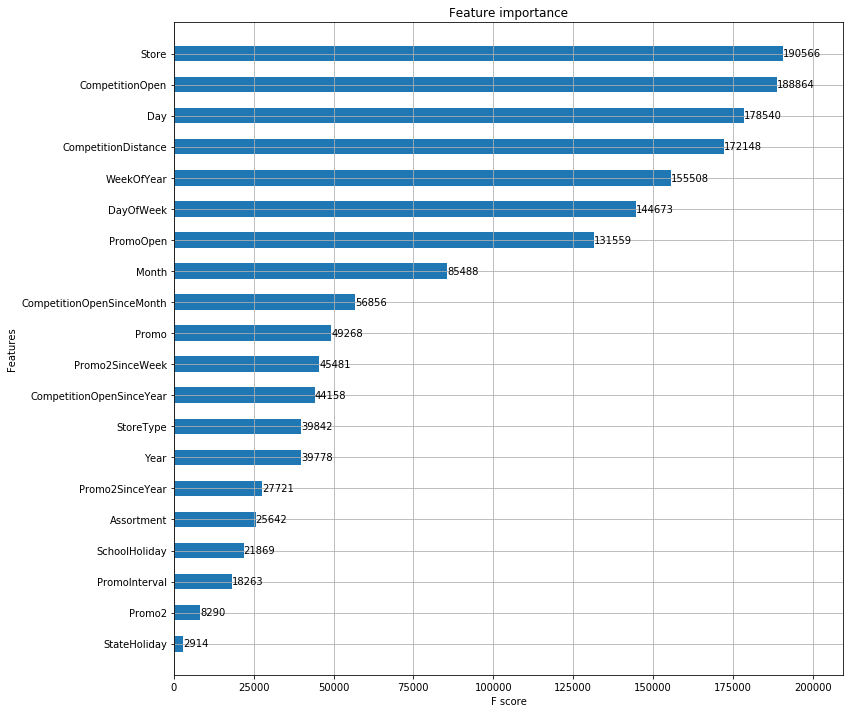

In [158]:
fig,ax = plt.subplots(figsize=(12,12))
plot_importance(xgb_model, height=0.5, ax=ax)

#### LightGBM Plot

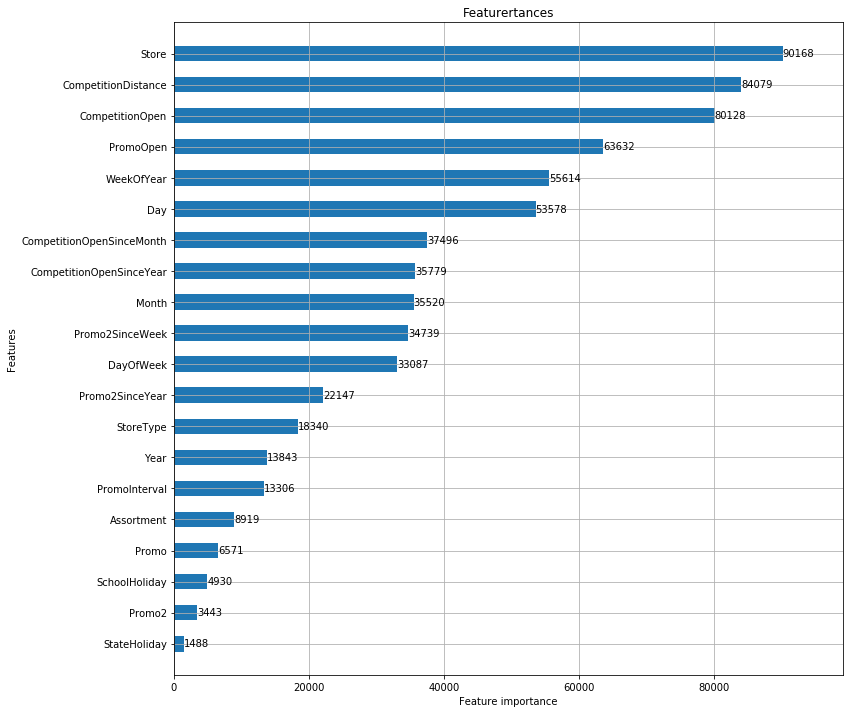

In [163]:
fig,ax = plt.subplots(figsize=(12,12))
lgb.plot_importance(lgb_model, ax=ax, height=0.5)
plt.title("Featurertances")